In [1]:
import sys, os
import importlib
import numpy as np
import pandas as pd
import function
from io import StringIO
import re
import matplotlib
import matplotlib.pyplot as plt
from math import prod as product
# from matplotlib.lines import Line2D
# def squaredify(array):
#  n= int(np.sqrt(array.shape[0]))
#  return np.array(array).reshape((n,n))
from scipy.optimize import minimize
from scipy.optimize import approx_fprime

# from scipy.optimize import fsolve
# import ultranest

In [38]:
import scipy.stats
scipy.integrate.qmc_quad(lambda x: stats.multivariate_normal(mean=np.ones(5), cov=np.identity(5)).pdf(x.T), -np.ones(5),2*np.ones(5))

QMCQuadResult(integral=0.36763929037559384, standard_error=0.0004063132939750265)

In [8]:
def func(X,Y,x0=1,y0=1,sigx = np.array([1,0.5]), sigy=np.array([1,0.5])):
 Vx = sigx.prod(axis=0)
 Vxp = sigx[0]- sigx[1]
 Vy = sigy.prod(axis=0)
 Vyp = sigy[0]- sigy[1]
 return ((X-x0)**2/(Vx+ Vxp*(X-x0))+(Y-y0)**2/(Vy+ Vyp*(Y-y0)))

In [2]:
def fix_index_name(df):
 return df.index.str.replace(r'.*gg.{0,2}H.*',r'ggF',flags=re.I,regex=True)\
 .str.replace(r'.*qq.{0,2}Hq.*',r'VBF',flags=re.I,regex=True)\
 .str.replace(r'.*qq.{0,2}Hlv.*','WH',flags=re.I,regex=True)\
 .str.replace(r'.*qq.{0,2}Hll.*','ZH',flags=re.I,regex=True)\
 .str.replace(r'.*B.{2}.*','none',flags=re.I,regex=True)\
 .str.replace(r'H,.*',r'ttH',regex=True)\
 .str.replace(r'.*(V|W|Z)(H).*',r'\1H',regex=True).rename('production')

# HIGG-19-005

## smeft

### data processing

In [2]:
with open('data/HIG-19-005-pas/SMEFT_raw/smeft_stage_0.txt',encoding='utf-8') as f:
 temp = f.read()
temp=re.sub('‘','l',temp)
temp=re.sub('n','v',temp)
temp=re.sub('!','->',temp)
temp=re.sub('−','-',temp)
temp=re.sub(r'(\n)(?![gg,qq,tt]\D*)',r'',temp,flags=re.MULTILINE) # join interrupted equation
temp=re.sub(r'(^\D*)(?<=\S)(\d)',r'\1 \2',temp,flags=re.MULTILINE) # split sticked label and number
temp=re.sub(r'(\s*×\s*)(\d+)(\d)',r'e\3',temp,flags=re.MULTILINE) # remove multiply character
temp=re.sub(r'(c\w+) (c\w+)',r'\1\2',temp,flags=re.MULTILINE) #merge multiply white space
# print(temp)
temp1=[]
for i in re.split('\n',temp):
 temp1.append(re.search(r'(^\D*)(?=( \d+.{0,1}[\d,e]+ c))',i).group(0))
temp2=[]
for i in re.split('\n', re.sub(r'([gg,qq,tt]\D*)','',temp)):
 temp2.append(pd.DataFrame([[(i[0]+i[1]) for i in re.findall(r'([-,+])? ?(?<!\w)(\d+(\.[\d,e]*)?)',i)]],
 columns=[i for i in re.findall(r'\d (c\w+)',i)]))
temp2=pd.concat(temp2,axis=0).astype(float).fillna(0)
temp2.index=temp1
temp2.index.name='production'

In [133]:
with open('data/HIG-19-005-pas/SMEFT_raw/smeft_stage_1.txt',encoding='utf-8') as f:
 temp = f.read()
temp=re.sub('‘','l',temp)
temp=re.sub('n','v',temp)
temp=re.sub('!','->',temp)
temp=re.sub('−','-',temp)
temp=re.sub(r'(\n)(?![gg,qq,tt]\D*)',r'',temp,flags=re.MULTILINE)
temp=re.sub(r'(\s*×\s*)(\d+)(\d)',r'e\3',temp,flags=re.MULTILINE) # remove multiply character
temp=re.sub(r'(c\w+) (c\w+)',r'\1\2',temp,flags=re.MULTILINE) #merge multiply white space
temp=re.sub(r'(?<![\s,\d,\.,e])(\d+(\.\d+(e\d)?)? c)',r' \1',temp,flags=re.MULTILINE) # split sticked label and number
# print(temp)
temp1=[]
for i in re.split('\n',temp):
 temp1.append(re.split(r'( ?[\+,\-]? ?\d+(.[e,\d]+)?) c.*',i)[0])
temp2=[]
for i in re.split('\n',temp):
 j=re.search(r'([+,-]? ?\d+(.[e,\d]+)?) c.*',i).group(0)
 temp2.append(pd.DataFrame([[(i[0]+i[1]) for i in re.findall(r'([-,+])? ?(?<!\w)(\d+(\.[\d,e]*)?)',j)]],
 columns=[i for i in re.findall(r'\d (c\w+)',j)]))
temp2=pd.concat(temp2,axis=0).astype(float).fillna(0)
temp2.index=temp1
temp2.index.name='production'

### calculate

In [2]:
def make_C_df_eft(C,names,combined=True,prefix='',suffix=''):
 C=np.array(C)
 C=np.append(np.ones((1,C.shape[1])),C,axis=0)
 names.insert(0,'')
 if combined:
  df=pd.DataFrame({('1' if (name_i=='' and name_j=='') else\
      f'{prefix}{name_i}{suffix}2' if name_i==name_j else\
      f'{prefix}{name_i}{prefix}{name_j}'):V_i*V_j for V_j,name_j in zip(C,names)  for V_i,name_i in zip(C,names)})
 return df
make_C_df_eft([[1,1],[1,1],[1,1],[1,1.2]],['cW','cB','cWB','cA'])

,1,cW,cB,cWB,cA,cW2,cBcW,cWBcW,cAcW,cWcB,...,cWBcB,cAcB,cWcWB,cBcWB,cWB2,cAcWB,cWcA,cBcA,cWBcA,cA2
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00
1,1.0,1.0,1.0,1.0,1.2,1.0,1.0,1.0,1.2,1.0,...,1.0,1.2,1.0,1.0,1.0,1.2,1.2,1.2,1.2,1.44


In [3]:
signals=pd.read_csv('data/HIG-19-005-pas/kappa/stage_0/sigma_normalized.csv',index_col=[0])

In [13]:
def tempf(Cs=np.linspace(-0.1,1,1000),names=['cA']):
 C_df=make_C_df_eft([Cs],names)
 y=1+multiply(temp2[:5],C_df)+multiply(temp2[5:],C_df)
 yhat=signals[['cross_sections(exp)']].to_numpy()
 correlation=pd.read_csv('data/HIG-19-005-pas/kappa/stage_0/correlation_production_strength.csv',index_col=[0])
 uncertainty=signals[['cross_sections(exp)_uncertainty+(tot)','cross_sections(exp)_uncertainty-(tot)']].abs().to_numpy()
 return likelihood(y,yhat,correlation,uncertainty)

In [45]:
make_C_df_eft([C,C],['cA','cG'])

,1,cA,cG,cA2,cGcA,cAcG,cG2
0,1.0,-0.020000,-0.020000,4.000000e-04,4.000000e-04,4.000000e-04,4.000000e-04
1,1.0,-0.019979,-0.019979,3.991796e-04,3.991796e-04,3.991796e-04,3.991796e-04
2,1.0,-0.019959,-0.019959,3.983600e-04,3.983600e-04,3.983600e-04,3.983600e-04
3,1.0,-0.019938,-0.019938,3.975413e-04,3.975413e-04,3.975413e-04,3.975413e-04
4,1.0,-0.019918,-0.019918,3.967235e-04,3.967235e-04,3.967235e-04,3.967235e-04
...,...,...,...,...,...,...,...
995,1.0,0.000418,0.000418,1.746554e-07,1.746554e-07,1.746554e-07,1.746554e-07
996,1.0,0.000438,0.000438,1.922283e-07,1.922283e-07,1.922283e-07,1.922283e-07
997,1.0,0.000459,0.000459,2.106433e-07,2.106433e-07,2.106433e-07,2.106433e-07
998,1.0,0.000479,0.000479,2.299006e-07,2.299006e-07,2.299006e-07,2.299006e-07


variational gaussian
min at -0.009616616616616617


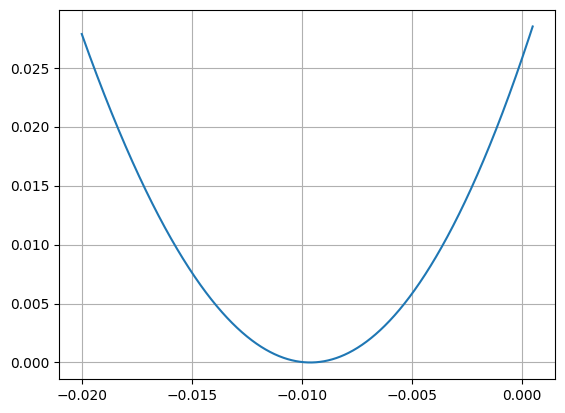

In [26]:
C=np.linspace(-0.02,0.0005,1000)
fig, ax = plt.subplots()
temp=tempf(C,['cA'])[:,0]
print(f'min at {C[temp.argmin()]}')
ax.plot(C,temp-temp.min())
ax.grid(True)

## kappa

### data processing

In [4]:
def fix_columns_name(df):
 temp=df.columns.str.replace(r'.*\$(.*)\$.*(SM).*',r'\1_\2',flags=re.I,regex=True)\
  .str.replace(r'.*\$(.*)\$.*',r'\1',flags=re.I,regex=True)\
  .str.replace(r'.*?st.*(\+|\-).*',r'Δ\1(stat)',flags=re.I,regex=True)\
  .str.replace(r'.*?th.*(\+|\-).*',r'Δ\1(theo)',flags=re.I,regex=True)\
  .str.replace(r'.*?to.*(\+|\-).*',r'Δ\1(tot)',flags=re.I,regex=True)\
  .str.replace(r'.*?sy.*(\+|\-).*',r'Δ\1(sys)',flags=re.I,regex=True)\
  .str.replace(r'.*err.*(\+|\-).*',r'Δ\1',flags=re.I,regex=True)\
  .str.replace(r'sigma',r'σ',flags=re.I,regex=True)\
  .str.replace(r' ?cdot ?',r'•',flags=re.I,regex=True)
 new_col=[]
 for i in temp:
  if 'Δ' not in i:
   temp1=i
   new_col.append(i)
  else:
   new_col.append(f'{i[:2]}{temp1}{i[2:]}')
 df.columns=new_col
 return df


In [41]:
with open('data/HIG-19-005-pas/kappa_raw/stage_0.txt',encoding='utf-8') as f:
 temp = f.read()
temp=re.sub('‘','l',temp)
temp=re.sub('n','v',temp)
temp=re.sub('!','->',temp)
temp=re.sub('−','-',temp)
temp=re.sub(r'(\n)(?![A-Z,a-z])',r'',temp,flags=re.MULTILINE)
temp=re.sub(r'(^\D*)(?<=\S)(\d)',r'\1 \2',temp,flags=re.MULTILINE) # split sticked label and number
temp=re.sub(r'(c\w+) (c\w+)',r'\1\2',temp,flags=re.MULTILINE) #merge multiply white space
temp=re.sub(r'\+ \-(\d(\.\d+)?) (\d(\.\d+)?)',r'+\1 -\3',temp,flags=re.MULTILINE)
# print(temp)
temp1=[]
for i in re.split('\n',temp):
 temp1.append(re.split(r' (\d.*)',i)[0])
temp2=[]
for i in re.split('\n', temp):
 j=re.split(r' (\d.*)',i)[1]
 temp2.append(np.array([(i[0]+i[1]) for i in re.findall(r'([-,+])? ?(?<!\w)(\d+(\.[\d,e]*)?)',j)]).astype(float))
temp=[pd.DataFrame(i,columns=['production']) for i in [['ggH','WH','ZH','ttH'],
['ggH','VBF','WH','ZH','ttH'],
['ggH','VBF','WH','ZH','ttH'],
['ggH','VBF','VH','ttH'],
['ggH','VBF','ttH'],
['ggH','VBF']]]
for Ni,i in enumerate(['bb','tautau','WW','ZZ','gaga','mumu']):
 temp[Ni]['decay']=i
df=pd.DataFrame(np.concatenate(temp2).reshape(-1,7))
df.index=pd.MultiIndex.from_frame(pd.concat(temp))
df=df.swaplevel().set_axis(['(σ•B)/(σ•B)_SM','Δ+(σ•B)/(σ•B)_SM(tot)','Δ-(σ•B)/(σ•B)_SM(tot)','Δ+(σ•B)/(σ•B)_SM(stat)',
 'Δ-(σ•B)/(σ•B)_SM(stat)','Δ+(σ•B)/(σ•B)_SM(sys)','Δ-(σ•B)/(σ•B)_SM(sys)'],axis=1)
# df=fix_columns_name(df)

df.to_csv('data/HIG-19-005-pas/kappa/stage_0/observable.csv')
#
temp=pd.read_csv('data/HIG-19-005-pas/kappa_raw/correlation.txt',sep='\s+',header=None,index_col=[0,1])
temp2=pd.DataFrame(np.flip(np.array(temp),axis=1))
temp=temp2.set_axis(temp.index)
temp.index.names=['decay','production']
temp=temp.set_axis(temp.index,axis=1)
temp.to_csv('data/HIG-19-005-pas/kappa/stage_0/correlation.csv')

In [64]:
with open('data/HIG-19-005-pas/kappa_raw/sigma_normalized.txt',encoding='utf-8') as f:
 temp = f.read()
temp=re.sub('‘','l',temp)
temp=re.sub('n','v',temp)
temp=re.sub('!','->',temp)
temp=re.sub('−','-',temp)
temp=re.sub(r'(\n)(?![A-Z,a-z])',r'',temp,flags=re.MULTILINE)
temp=re.sub(r'(^\D*)(?<=\S)(\d)',r'\1 \2',temp,flags=re.MULTILINE) # split sticked label and number
temp=re.sub(r'(c\w+) (c\w+)',r'\1\2',temp,flags=re.MULTILINE) #merge multiply white space
temp=re.sub(r'\+ \-(\d(\.\d+)?) (\d(\.\d+)?)',r'+\1 -\3',temp,flags=re.MULTILINE)
temp1=[]
for i in re.split('\n',temp):
 temp1.append(re.split(r' (\d.*)',i)[0])
temp2=[]
for i in re.split('\n', temp):
 j=re.split(r' (\d.*)',i)[1]
 temp2.append(np.array([(i[0]+i[1]) for i in re.findall(r'([-,+])? ?(?<!\w)(\d+(\.[\d,e]*)?)',j)]).astype(float))
df=pd.DataFrame(temp2).set_index(pd.Index(temp1))
df=df.set_axis(['σ/σ_SM','Δ+σ/σ_SM(tot)','Δ-σ/σ_SM(tot)','Δ+σ/σ_SM(stat)',
 'Δ-σ/σ_SM(stat)','Δ+σ/σ_SM(sys)','Δ+σ/σ_SM(sys)'],axis=1)
df=fix_columns_name(df)
df.to_csv('data/HIG-19-005-pas/kappa/stage_0/observable_1.csv')
temp=pd.read_csv('data/HIG-19-005-pas/kappa_raw/correlation_production_strength.txt',sep='\s+',header=None,index_col=None)
temp2=pd.DataFrame(np.flip(np.array(temp),axis=1))
temp=temp2.set_axis(df.index)
temp.index.names=['production']
temp=temp.set_axis(temp.index,axis=1)
temp.to_csv('data/HIG-19-005-pas/kappa/stage_0/correlation_1.csv')

In [65]:
df=pd.read_csv('data/HIG-19-005-pas/kappa_raw/decay_normalized.txt',index_col=[0],sep='\s+',header=None)
df=df.set_axis(['Γ/Γ_SM','Δ+Γ/Γ_SM(tot)','Δ-Γ/Γ_SM(tot)','Δ+Γ/Γ_SM(stat)',
 'Δ-Γ/Γ_SM(stat)','Δ+Γ/Γ_SM(sys)','Δ+Γ/Γ_SM(sys)'],axis=1)
df=fix_columns_name(df)
df.to_csv('data/HIG-19-005-pas/kappa/stage_0/observable_2.csv')
temp=pd.read_csv('data/HIG-19-005-pas/kappa_raw/correlation_decay_strength.txt',sep='\s+',header=None,index_col=None)
temp2=pd.DataFrame(np.flip(np.array(temp),axis=1))
temp=temp2.set_axis(df.index)
temp.index.names=['decay']
temp=temp.set_axis(temp.index,axis=1)
temp.to_csv('data/HIG-19-005-pas/kappa/stage_0/correlation_2.csv')

In [222]:
import Fiteft
# import importlib
importlib.reload(Fiteft)


<module 'Fiteft' from 'c:\\project\\Fiteft\\Fiteft.py'>

# Higg 2018-28

## smeft data processing

In [2]:
def read_input(path = 'data/HIGG-2018-28/smeft_parametrization/CP_even_raw.txt'):
 with open(path,'r',encoding='Utf-8') as f:
  S = f.read()
 lines=re.split('\n',S)
 bins , terms = [],[]
 for line in lines:
  bins.append(re.split('\s+',line,1)[0])
  terms.append(re.split('\s+',line,1)[1])
 dfs = []
 for term in terms:
   temp = re.split(r'(?:\s+)?(\+|\-)(?:\s+)?',term)
   coeffs, names = [],[]
   signs = []
   for i in temp:
     if re.match(r'(\d+(?:\.\d+)?)\s?(\w+)?', i):
       coeffs.append(re.match(r'(\d+(?:\.\d+)?)\s?(\w+)?', i).group(1))
       names.append(re.match(r'(\d+(?:\.\d+)?)\s?(\w+)?', i).group(2) or '1')
     else:
       signs.append(i)
   signs = np.array([{'+':1,'-':-1}.get(i) for i in signs])
   coeffs = np.array(coeffs).astype(float)
   coeffs[-signs.shape[0]:] = coeffs[-signs.shape[0]:]* signs
   dfs.append(pd.DataFrame(data=[coeffs], columns=names).reset_index(drop=True))
 df = pd.concat(dfs, axis =0).set_axis(bins,axis=0).fillna(0)
 df.index.name='production_'
 return df

In [31]:
df = read_input('data/HIGG-2018-28/smeft_parametrization/CP_odd_production_raw.txt')
df.to_csv('data/HIGG-2018-28/smeft_parametrization/CP_odd_production.csv')
df = read_input('data/HIGG-2018-28/smeft_parametrization/CP_even_production_raw.txt')
df.to_csv('data/HIGG-2018-28/smeft_parametrization/CP_even_production.csv')
df = read_input('data/HIGG-2018-28/smeft_parametrization/CP_odd_decay_raw.txt')
df.to_csv('data/HIGG-2018-28/smeft_parametrization/CP_odd_decay.csv')
df = read_input('data/HIGG-2018-28/smeft_parametrization/CP_even_decay_raw.txt')
df.to_csv('data/HIGG-2018-28/smeft_parametrization/CP_even_decay.csv')

## calculate

### even

In [2]:
prod = pd.read_csv('data/HIGG-2018-28/smeft_parametrization/CP_even_production.csv',index_col= 0)
decay = pd.read_csv('data/HIGG-2018-28/smeft_parametrization/CP_even_decay.csv',index_col= 0)

In [3]:
temp = '''
α0 0.153 0.003
δHW 0.614 0.027
α1 0.874 0.010
δHB 2.294 0.033
α2 0.881 0.019
δHWB 0.703 0.029
βHW -0.133 0.012
δ(HW,HWB) -1.21 0.04
βHB 0.005 0.005
δ(HB,HWB) -1.22 0.06
βHWB 0.120 0.011
δ(HW,HB) 0.08 0.07
δ 0.05 0.06
'''
acceptance = pd.read_csv(StringIO(temp), sep='\s+', index_col=0, header=None)
acceptance = acceptance.iloc[:, 0]


def calculate_A(rules={'HW': [0, 0]}, derivative = False):
    allowed =['HW','HWB','HB','cHW','cHWB','cHB']
    if isinstance(rules,dict):
        Cvecs = pd.DataFrame(rules)
    else :
        Cvecs = rules.copy()
    keys = np.intersect1d(allowed,Cvecs.columns)
    # Cvecs =Cvecs[keys]
    keys = [re.sub(r'^c','', i) for i in Cvecs.columns]
    if (keys != Cvecs.columns).any():
        Cvecs = Cvecs.set_axis(keys, axis = 1)
    shape = Cvecs.shape[0]
    # # print(rulesp)
    A = acceptance[acceptance.index.str.contains(
        r'α', regex=True)].T
    A.index = A.index.str[1:]
    B =  acceptance[acceptance.index.str.contains(
        r'β\w', regex=True)].T
    B.index = B.index.str[1:]
    D = acceptance[acceptance.index.str.contains(
        r'δ\w', regex=True)].T
    D.index = D.index.str[1:]
    DD = acceptance[acceptance.index.str.contains(
        r'δ\(\w', regex=True)].T
    DD.index = DD.index.str[2:-1]
    if len(keys) ==0:
        return (np.ones(shape)*(A[0]+A[1]**2/(A[2] + (D * (B)**2).sum() ))).reshape(-1,1,1)

    if not derivative:
        return (A['0']+A['1']**2/(A['2'] + sum(D[i] * (Cvecs.get(i,0)+ B[i])**2 for i in ['HW','HB','HWB']) +
                        Cvecs.get('HW', 0)*Cvecs.get('HWB', 0) * DD['HW,HWB'] + \
                        Cvecs.get('HB', 0)*Cvecs.get('HWB', 0) * DD['HB,HWB'] + \
                        Cvecs.get('HW', 0)*Cvecs.get('HB', 0) * DD['HW,HB'] + \
                        acceptance.get(f'δ', 0) *product(Cvecs.get(i,0) for i in ['HW','HB','HWB']) )).to_numpy().reshape(-1,1,1)
    if derivative:
        dF = [(acceptance.get(f'δ', 0)* Cvecs.get('HB', 0) * Cvecs.get('HWB', 0) + 2 * (Cvecs.get('HW', 0) + B['HW'])* D['HW'] + 
                                        Cvecs.get('HB', 0) * DD['HW,HB'] + Cvecs.get('HWB', 0) * DD['HW,HWB']),
              (acceptance.get(f'δ', 0)* Cvecs.get('HW', 0) * Cvecs.get('HWB', 0) + 2 * (Cvecs.get('HB', 0) + B['HB'])* D['HB'] + 
                                        Cvecs.get('HW', 0) * DD['HW,HB'] + Cvecs.get('HWB', 0) * DD['HB,HWB']),
              (acceptance.get(f'δ', 0)* Cvecs.get('HB', 0) * Cvecs.get('HW', 0) +  2 * (Cvecs.get('HWB', 0) + B['HWB'])* D['HWB'] + 
                                        Cvecs.get('HB', 0) * DD['HB,HWB'] + Cvecs.get('HW', 0) * DD['HW,HWB'])]
        dF = np.array(dF).T
        dF = (A['1']**2/(A['2'] + (sum(D[i] * (Cvecs[[i]]* B[i])**2 for Ni,i in enumerate(['HW','HB','HWB']))) +
                        Cvecs.get('HW', 0)*Cvecs.get('HWB', 0) * DD['HW,HWB'] + \
                        Cvecs.get('HB', 0)*Cvecs.get('HWB', 0) * DD['HB,HWB'] + \
                        Cvecs.get('HW', 0)*Cvecs.get('HB', 0) * DD['HW,HB'] + \
                        acceptance.get(f'δ', 0) *Cvecs[['HW','HB','HWB']].prod(axis=1))**2).to_numpy().reshape(-1,1) * dF
        dF = pd.DataFrame(dF, columns = ['HW','HB','HWB'])
        temp = pd.DataFrame(np.zeros(Cvecs.shape), columns = Cvecs.columns)
        temp.update(dF)
        return - temp.to_numpy().reshape(Cvecs.shape[0],1,Cvecs.shape[1])
# 'HW','HB','HWB'
print(calculate_A({'cHB':[-0.3232,1],	'cHW':[-0.693136,1],'cHWB':[-1.088673,1]}))
# print(calculate_A({'cHB':[1],	'cHW':[1],'cHWB':[1]}, True))

# pd.DataFrame({'cHB':[-0.3232],	'cHW':[-0.693136],'cHWB':[-1.088673]})

[[[1.04604089]]

 [[0.49380648]]]


In [64]:
import Fiteft2
importlib.reload(function)
importlib.reload(Fiteft2)
a=Fiteft2.kappa(decay_modes='all',experiment='HIGG-2018-28 copy',stage=1)
# a.calculate_likelihood({'CV':np.array([1,2]),'CF':np.array([1,2])})
index = a.used_observable[0].index.get_level_values('production_')

In [ ]:

for dictt in [
{'cHW':(-4.5,4),'cHB':(-4,4)},
# {'cHB':(-16,16),'cHG':(-0.02,0.08)},
# {'cuH':(-30,40),'cHG':(-0.02,0.02)},
# {'cHW':[-5,6],'cHWB':[-7.5,7.5]},
# {'cHB':(-10,10), 'cHWB':(-15,15)},
# {'cHW': (-5,3), 'cHG':(-0.03,0.03)},
# {'cHWB': (-20,20), 'cHG':(-0.02,0.08)},
]:
 keys, values= list(dictt.keys()),list(dictt.values())
 Cx, Cy = (np.linspace(value[0],value[1],100) for value in values)
 Cxx,Cyy=np.meshgrid(Cx,Cy)
 # bn = pd.read_csv(f'../Liltith/validations/ATLAS/HIGG-2018-28-SMEFT/official-data/{name}.csv') if os.path.exists(f'../Liltith/validations/ATLAS/HIGG-2018-28-SMEFT/official-data/{name}.csv') else None
 exp = (pd.read_csv(f'validation/HIGG-2018-28/{keys[0]}-{keys[1]}_even.csv',header= 1) if os.path.exists(f'validation/HIGG-2018-28/{keys[0]}-{keys[1]}_even.csv') else None)
 C_df = function.make_C_df_eft({keys[0]: Cxx.reshape(-1), keys[1]:Cyy.reshape(-1)})
 prod1 = function.multiply(prod.loc[index], C_df)
 decay1 = function.multiply(decay.loc[['Γ(H→4l)/Γ_SM(H→4l)']], C_df)
 decay2 = function.multiply(decay.loc[['Γ(H→all)/Γ_SM(H→all)']], C_df)
 # y = prod1 * decay1/decay2  * calculate_A({keys[0]: Cxx.reshape(-1), keys[1]:Cyy.reshape(-1)})
 y = prod1 * decay1/decay2 * a.used_observable[0][['(σ•B)_SM']].to_numpy() * calculate_A({keys[0]: Cxx.reshape(-1), keys[1]:Cyy.reshape(-1)})
 # temp = function.likelihood(y, a.observable_list[0][['(σ•B)/(σ•B)_SM']].to_numpy(), a.used_correlation, a.used_observable[0][['Δ+(σ•B)(tot)', 'Δ-(σ•B)(tot)']],
 #  uncertainty_theo= a.observable_list[0][['Δ+(σ•B)/(σ•B)_SM(tot)', 'Δ-(σ•B)/(σ•B)_SM(tot)']],correlation_theo=np.identity(a.used_observable[0].shape[0])
 #  )
 temp = function.likelihood(y, a.used_observable[0][['(σ•B)']], a.used_correlation, a.used_observable[0][['Δ+(σ•B)(tot)', 'Δ-(σ•B)(tot)']],
  uncertainty_theo= a.used_observable[0][['Δ+(σ•B)_SM(tot)', 'Δ-(σ•B)_SM(tot)']],
  correlation_theo=pd.DataFrame(function.make_theo_correlation(alist=[[4],[4],[5],[6],[7],[15],[18],[204,207],[203,206,205,208,209,210],[217,218],[303,403,503],[601]]) ).round(2)
  # correlation_theo=corr.reshape(12,12)
  )
 fig, ax = plt.subplots()
 fig.set_figwidth(5)
 fig.set_figheight(5)
 pl = ax.contourf(Cxx,Cyy,temp.reshape((Cx.shape[0],Cy.shape[0])),temp.min()+[0.1,2.3, 5.99],vmin=-0., vmax=10,colors=['#ff3300', '#ffa500', '#ffff00'])
 ax.plot(Cx[temp.argmin()%Cx.shape[0]],Cy[temp.argmin()//Cx.shape[0]],'*',color = 'k', markersize = 10)
 if exp is not None:
  ax.plot(exp.iloc[:,0],exp.iloc[:,1],'.',color='b',markersize=2, label = 'HIGG-2018-28 exp 95% CL')
  # ax.plot(exp.iloc[:,2],exp.iloc[:,3],'.',color='k',markersize=2, label = 'HIGG-2018-28 SM 95% CL')
 # if bn is not None:
 #  ax.plot(bn.iloc[:,0],bn.iloc[:,1],'.',color='g',markersize=2, label = 'Bao Nhi\'s')
  plt.legend()
 plt.xlabel(keys[0])
 plt.ylabel(keys[1])
 np.savetxt(f'validation/HIGG-2018-28/{list(dictt.keys())[0]}-{list(dictt.keys())[1]}_even.txt',pl.allsegs[0][0][:,0])
 plt.savefig(f'validation/HIGG-2018-28/{list(dictt.keys())[0]}-{list(dictt.keys())[1]}_even.pdf')

In [ ]:
Cs = [{'cuH': np.linspace(-1.5,1.5,10)}]
importlib.reload(function)
for dict in Cs:
 # print(dict.keys())
#  exp = pd.read_csv(f'validation/HIGG-2018-28/{list(dict.keys())[0]}_even.csv',header= 1)
 C_df = function.make_C_df_eft(dict.copy())
 prod1 = function.multiply(prod.loc[index], C_df)
 decay1 = function.multiply(decay.loc[['Γ(H→4l)/Γ_SM(H→4l)']], C_df)
 decay2 = function.multiply(decay.loc[['Γ(H→all)/Γ_SM(H→all)']], C_df)
 y = prod1 * decay1/ decay2 * a.used_observable[0][['(σ•B)_SM']].to_numpy() * calculate_A(dict.copy())
#  y = prod1 * decay1/ decay2  * calculate_A(dict.copy())
 temp = function.likelihood(y, a.used_observable[0][['(σ•B)']], a.used_correlation.round(2), a.used_observable[0][['Δ+(σ•B)(tot)', 'Δ-(σ•B)(tot)']],
  uncertainty_theo= a.used_observable[0][['Δ+(σ•B)_SM(tot)', 'Δ-(σ•B)_SM(tot)']],correlation_theo=np.identity(a.used_observable[0].shape[0]),
  likelihood_type=0
  )
  

In [245]:
Cs =  [
{'cuH':np.linspace(-30,40,3000)},
{'cHG':np.linspace(-20,20,5000)},
{'cHW':np.linspace(-20,20,5000)},
{'cHB':np.linspace(-20,20,5000)},
{'cHWB': np.linspace(-20,20,5000)},
]
for dict in Cs:
 exp = pd.read_csv(f'validation/HIGG-2018-28/{list(dict.keys())[0]}_even.csv',header= 1)
 C_df = function.make_C_df_eft(dict.copy())
 prod1 = function.multiply(prod.loc[index], C_df)
 decay1 = function.multiply(decay.loc[['Γ(H→4l)/Γ_SM(H→4l)']], C_df)
 decay2 = function.multiply(decay.loc[['Γ(H→all)/Γ_SM(H→all)']], C_df)
 y = prod1 * decay1/ decay2 * a.used_observable[0][['(σ•B)_SM']].to_numpy() * calculate_A(dict.copy())
 temp = function.likelihood(y, a.used_observable[0][['(σ•B)']], a.used_correlation.round(2), a.used_observable[0][['Δ+(σ•B)(tot)', 'Δ-(σ•B)(tot)']],
  uncertainty_theo= a.used_observable[0][['Δ+(σ•B)_SM(tot)', 'Δ-(σ•B)_SM(tot)']],correlation_theo=np.identity(a.used_observable[0].shape[0])
  )
 print(f'{dict.keys()} min is {list(dict.values())[0][temp.argmin()]: .3f}')

 # fig, ax = plt.subplots()
 # ax.plot(list(dict.values())[0],temp[:,0,0]-temp.min(), label = 'with identity_theo_correlation')
 # ax.plot(exp.iloc[:,0],exp.iloc[:,1],label = 'HIGGS-2018-28')
 # ax.plot(list(dict.values())[0][temp.argmin()],0,'*',markersize = 10, label = f'{list(dict.values())[0][temp.argmin()]:.2f}')
 # # print(list(dict.values())[0][temp.argmin()])
 # plt.ylabel('likelihood')
 # # plt.text()
 # plt.xlabel(f'{list(dict.keys())[0]}')
 # plt.legend()
 # plt.savefig(f'validation/HIGG-2018-28/{list(dict.keys())[0]}_even.pdf')

dict_keys(['cuH']) min is -5.375
dict_keys(['cHG']) min is -0.004
dict_keys(['cHW']) min is  0.460
dict_keys(['cHB']) min is  0.004
dict_keys(['cHWB']) min is  0.124


### odd

In [1]:
prod = pd.read_csv('data/HIGG-2018-28/smeft_parametrization/CP_odd_production.csv',index_col= 0)
decay = pd.read_csv('data/HIGG-2018-28/smeft_parametrization/CP_odd_decay.csv',index_col= 0)

NameError: name 'pd' is not defined

In [ ]:
decay

In [11]:
temp = '''
α0 0.118 0.001
δHW 0.572 0.003
α1 0.853 0.001
δHB 2.022 0.004
α2 0.826 0.002
δHWB 0.644 0.001
βHW -0.001 0.001
δ(HW,HWB) -1.070 0.004
βHB -0.001 0.001
δ(HB,HWB) -1.085 0.006
βHWB 0.001 0.001
δ(HW,HB) -0.010 0.008
δ -0.060 0.088
'''
acceptance = pd.read_csv(StringIO(temp), sep='\s+', index_col=0, header=None)
acceptance = acceptance.iloc[:, 0]


def calculate_A(rules={'HW': [0, 0]}):
    allowed =['HW','HWB','HB']
    shape =  list(rules.values())[0].shape[0]
    for key in list(rules.keys()):
        rules[key.replace('c', '').replace('_', '')] = rules.pop(key)
    for key in list(rules.keys()):
        if key not in allowed:
            rules.pop(key)
    # print(rules)
    A = acceptance[acceptance.index.str.contains(
        r'α', regex=True)].to_numpy().reshape(-1, 1)
    B = acceptance[acceptance.index.str.contains(
        r'β\w', regex=True)].to_numpy().reshape(-1, 1)
    D = acceptance[acceptance.index.str.contains(
        r'δ\w', regex=True)].to_numpy().reshape(-1, 1)
    if len(rules) ==0:
        return (np.ones(shape)*(A[0]+A[1]**2/(A[2] + (D * (B)**2).sum() ))).reshape(-1,1,1)
    Cs = {'HW': np.zeros(shape), 'HB': np.zeros(shape), 'HWB': np.zeros(shape)}
    Cs.update(rules)
    C = pd.DataFrame(Cs).to_numpy().reshape(-1, 3, 1)
    CC = np.matmul(C, np.transpose(C, axes=[0, 2, 1]))

    def myfunc(a):
        b = a.copy()
        np.fill_diagonal(b, 0)
        return b
    CC = np.vectorize(myfunc, signature='(m,n)->(m,n)')(CC)
    CCC = np.matmul(np.expand_dims(
        np.matmul(C, np.transpose(C, axes=[0, 2, 1])), -1), C[1].T)
    DD = pd.DataFrame(np.zeros((3, 3))).set_axis(
        Cs.keys(), axis=1).set_axis(Cs.keys(), axis=0)
    for i in Cs.keys():
        for j in Cs.keys():
            DD.loc[i, j] = acceptance.get(
                f'δ({i},{j})', 0) 
    DD = DD.to_numpy()
    DDD = np.zeros((3, 3, 3))
    for i, V_i in enumerate(Cs.keys()):
        for j, V_i in enumerate(Cs.keys()):
            for k, V_i in enumerate(Cs.keys()):
                if i != j and i != k and j != k:
                    DDD[i, j, k] = acceptance.get(f'δ', 0)
                else:
                    DDD[i, j, k] = 0
    # print((CCC*DDD).sum(axis=(-1, -2, -3)).max())
    return (A[0]+A[1]**2/(A[2] + (D * (C+B)**2).sum(axis=(1, 2)) +
                         (DD * CC).sum(axis=(1, 2)) + (CCC*DDD).sum(axis=(-1, -2, -3)))).reshape(-1,1,1)

In [245]:
print(f'<expmu dim="{a.used_observable[0].shape[0]}" type="vn">')
print(f'''<experiment>ATLAS</experiment>
  <source type="preliminary">HIGG-2018-28</source>
  <sqrts>13</sqrts>
  <mass>125.09</mass>
  <CL>68%</CL> <!-- optional -->''')
for N,(i,j) in enumerate(a.used_observable[0].droplevel('production_').index):
 print(f'<eff axis="d{N+1}" prod="{i}" decay="{j}">1.0</eff>')
print('<bestfit>')
for N,j in enumerate(a.used_observable[0].droplevel('production_')[a.signature_list[0]]):
 print(f'<d{N+1}>{j}</d{N+1}>')
print('</bestfit>')
print('<param>')
for N,i in enumerate(a.used_observable[0][[f'Δ+{a.signature_list[0]}(tot)',f'Δ-{a.signature_list[0]}(tot)']].values):
 print(f'<uncertainty axis="d{N+1}" side="left">{i[0]}</uncertainty>\n<uncertainty axis="d{N+1}" side="right">+{i[1]}</uncertainty>')
for Ni,i in enumerate(a.used_correlation.loc[a.used_correlation.index,a.used_correlation.index].values):
 for Nj,j in enumerate(i[Ni+1:]):
  print(f'<correlation entry="d{Ni+1}d{Nj+Ni+2}">{j}</correlation>')
print('</param>')
print('</expmu>')


<expmu dim="12" type="vn">
<experiment>ATLAS</experiment>
  <source type="preliminary">HIGG-2018-28</source>
  <sqrts>13</sqrts>
  <mass>125.09</mass>
  <CL>68%</CL> <!-- optional -->
<eff axis="d1" prod="ggF" decay="ZZ">1.0</eff>
<eff axis="d2" prod="ggF" decay="ZZ">1.0</eff>
<eff axis="d3" prod="ggF" decay="ZZ">1.0</eff>
<eff axis="d4" prod="ggF" decay="ZZ">1.0</eff>
<eff axis="d5" prod="ggF" decay="ZZ">1.0</eff>
<eff axis="d6" prod="ggF" decay="ZZ">1.0</eff>
<eff axis="d7" prod="ggF" decay="ZZ">1.0</eff>
<eff axis="d8" prod="VBF" decay="ZZ">1.0</eff>
<eff axis="d9" prod="VBF" decay="ZZ">1.0</eff>
<eff axis="d10" prod="VBF" decay="ZZ">1.0</eff>
<eff axis="d11" prod="VH" decay="ZZ">1.0</eff>
<eff axis="d12" prod="top" decay="ZZ">1.0</eff>
<bestfit>
<d1>0.17</d1>
<d2>0.63</d2>
<d3>0.05</d3>
<d4>0.17</d4>
<d5>0.009</d5>
<d6>0.04</d6>
<d7>0.038</d7>
<d8>0.021</d8>
<d9>0.15</d9>
<d10>0.0005</d10>
<d11>0.022</d11>
<d12>0.025</d12>
</bestfit>
<param>
<uncertainty axis="d1" side="left">0.053

In [ ]:
Cs = [{'cHW': np.linspace(-4,4,100)}]
for dict in Cs:
 print(dict.keys())
 exp = pd.read_csv('validation/HIGG-2018-28/cHW_odd.csv',header= 1)
 C_df = function.make_C_df_eft(dict)
 prod1 = function.multiply(prod.loc[index], C_df)
 decay1 = function.multiply(decay.loc[['Γ(H→4l)/Γ_SM(H→4l)']], C_df)
 decay2 = function.multiply(decay.loc[['Γ(H→all)/Γ_SM(H→all)']], C_df)
 y = prod1 * decay1/ decay2 * a.used_observable[0][['(σ•B)_SM']].to_numpy() * calculate_A(dict)
 temp = function.likelihood(y, a.used_observable[0][['(σ•B)']], a.used_correlation, a.used_observable[0][['Δ+(σ•B)(tot)', 'Δ-(σ•B)(tot)']],
  uncertainty_theo= a.used_observable[0][['Δ+(σ•B)_SM(tot)', 'Δ-(σ•B)_SM(tot)']],correlation_theo=np.identity(a.used_observable[0].shape[0])
  )
 # temp2 = function.likelihood(y, a.used_observable[0][['(σ•B)']], a.used_correlation, a.used_observable[0][['Δ+(σ•B)(tot)', 'Δ-(σ•B)(tot)']],
  # uncertainty_theo= a.used_observable[0][['Δ+(σ•B)_SM(tot)', 'Δ-(σ•B)_SM(tot)']],correlation_theo=np.identity(a.used_observable[0].shape[0])
  # )
 # print(temp)
 fig, ax = plt.subplots()
 plt.figsize
 ax.plot(list(dict.values())[0],temp[:,0,0]-temp.min(), label = 'with identity_theo_correlation')
 # ax.plot(list(dict.values())[0],temp2[:,0,0]-temp2.min(),label ='w/o theo_uncertainty')
 ax.plot(list(dict.values())[0][temp.argmin()],0,'*',markersize = 10)
 ax.plot(exp.iloc[:,0],exp.iloc[:,1],label = 'HIGGS-2018-28')
 plt.xlabel('cHW')
 plt.ylabel('likelihood')
 plt.legend()
 plt.savefig('validation/HIGG-2018-28/cHW_odd.pdf')

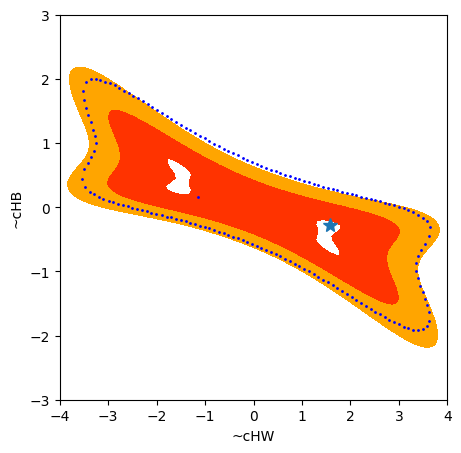

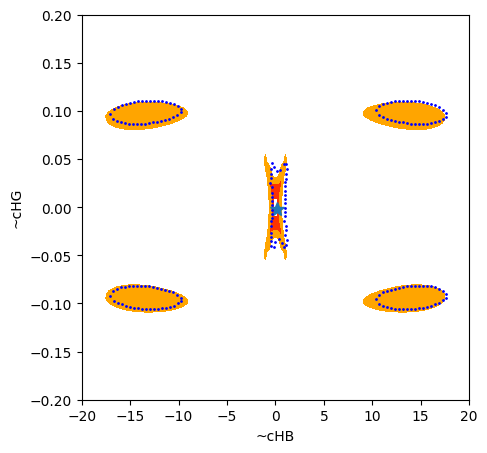

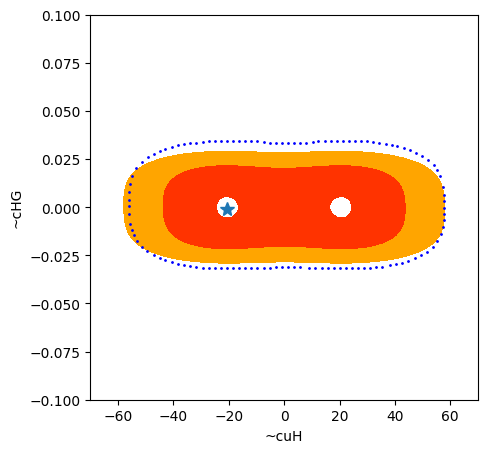

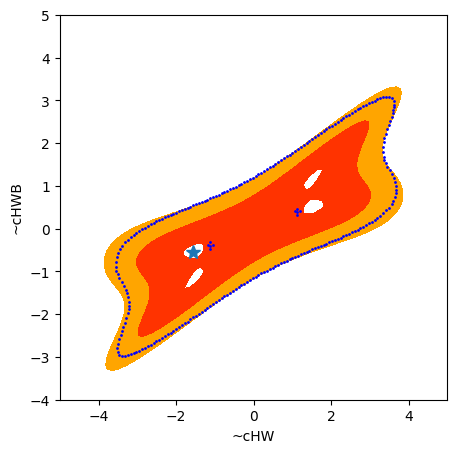

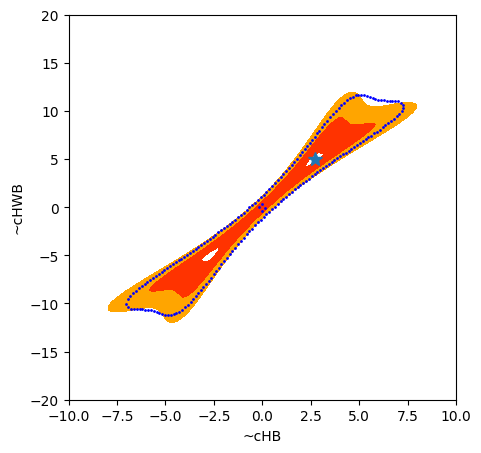

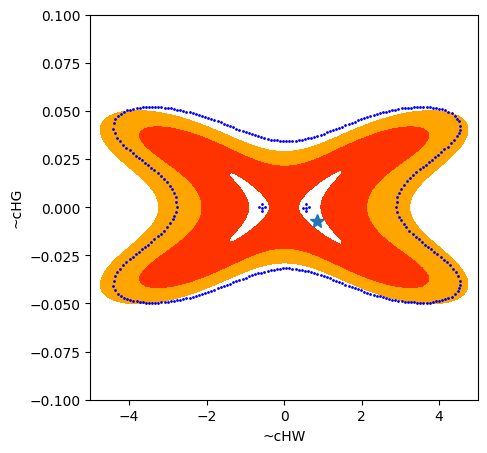

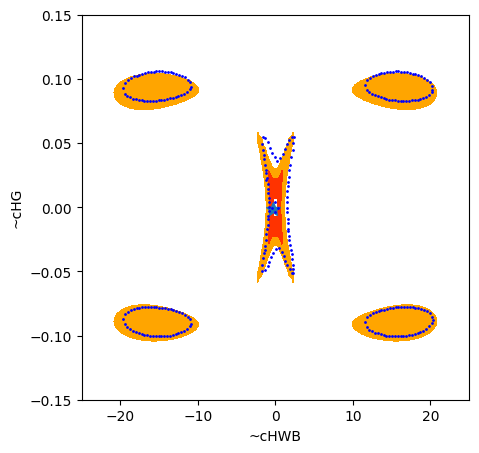

In [261]:
for dict in [{'cHW':(-4,4),'cHB':(-3,3)},
{'cHB':(-20,20),'cHG':(-0.2,0.2)},
{'cuH':(-70,70),'cHG':(-0.1,0.1)},
{'cHW':(-5,5),'cHWB':(-4,5)},
{'cHB':(-10,10), 'cHWB':(-20,20)},
{'cHW': (-5,5), 'cHG':(-0.1,0.1)},
{'cHWB': (-25,25), 'cHG':(-0.15,0.15)},
]:
 keys, values= list(dict.keys()),list(dict.values())
 Cx, Cy = (np.linspace(value[0],value[1],100) for value in values)
 Cxx,Cyy=np.meshgrid(Cx,Cy)
 exp = (pd.read_csv(f'validation/HIGG-2018-28/{keys[0]}-{keys[1]}_odd.csv',header= 1) if os.path.exists(f'validation/HIGG-2018-28/{keys[0]}-{keys[1]}_odd.csv') else None)
 # bn = pd.read_csv(f'../Liltith/validations/ATLAS/HIGG-2018-28-SMEFT/official-data/{name}.csv') if os.path.exists(f'../Liltith/validations/ATLAS/HIGG-2018-28-SMEFT/official-data/{name}.csv') else None
 C_df = function.make_C_df_eft({keys[0]: Cxx.reshape(-1), keys[1]:Cyy.reshape(-1)})
 prod1 = function.multiply(prod.loc[index], C_df)
 decay1 = function.multiply(decay.loc[['Γ(H→4l)/Γ_SM(H→4l)']], C_df)
 decay2 = function.multiply(decay.loc[['Γ(H→all)/Γ_SM(H→all)']], C_df)
 y = prod1 * decay1/decay2 * a.used_observable[0][['(σ•B)_SM']].to_numpy() * calculate_A({keys[0]: Cxx.reshape(-1), keys[1]:Cyy.reshape(-1)})
 temp = function.likelihood(y, a.used_observable[0][['(σ•B)']], a.used_correlation, a.used_observable[0][['Δ+(σ•B)(tot)', 'Δ-(σ•B)(tot)']],
  uncertainty_theo= a.used_observable[0][['Δ+(σ•B)_SM(tot)', 'Δ-(σ•B)_SM(tot)']],correlation_theo=np.identity(a.used_observable[0].shape[0])
  )
 fig, ax = plt.subplots()
 fig.set_figwidth(5)
 fig.set_figheight(5)
 ax.contourf(Cxx,Cyy,temp.reshape((Cx.shape[0],Cy.shape[0])),temp.min()+[0.05,2.3, 5.99],vmin=-0., vmax=10,colors=['#ff3300', '#ffa500', '#ffff00'])
 ax.plot(Cx[temp.argmin()%Cx.shape[0]],Cy[temp.argmin()//Cx.shape[0]],'*', markersize = 10)
 if exp is not None:
  ax.plot(exp.iloc[:,0],exp.iloc[:,1],'.',color='b',markersize=2, label = 'HIGG-2018-28 exp 95% CL')
  # ax.plot(exp.iloc[:,2],exp.iloc[:,3],'.',color='k',markersize=2, label = 'HIGG-2018-28 SM 95% CL')
 # if bn is not None:
 #  ax.plot(bn.iloc[:,0],bn.iloc[:,1],'.',color='g',markersize=2, label = 'Bao Nhi\'s')
 #  plt.legend()
 plt.xlabel(f'~{keys[0]}')
 plt.ylabel(f'~{keys[1]}')
 np.savetxt(f'validation/HIGG-2018-28/{list(dict.keys())[0]}-{list(dict.keys())[1]}_odd.txt',pl.allsegs[0][0])
 plt.savefig(f'validation/HIGG-2018-28/{list(dict.keys())[0]}-{list(dict.keys())[1]}_odd.pdf')

dict_keys(['cHWB'])


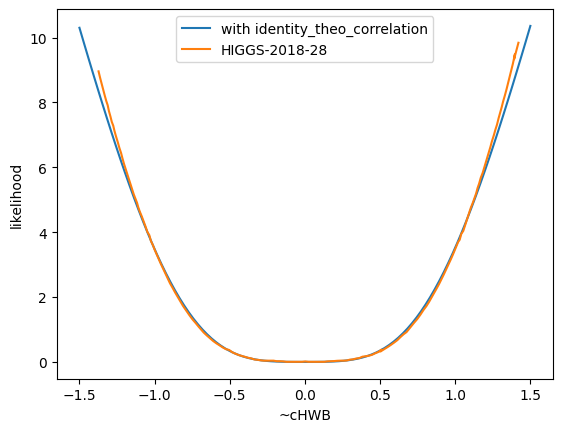

In [50]:
Cs = [{'cHWB': np.linspace(-1.5,1.5,100)}]

for dict in Cs:
 print(dict.keys())
 exp = pd.read_csv(f'validation/HIGG-2018-28/{list(dict.keys())[0]}_odd.csv',header= 1)
 C_df = function.make_C_df_eft(dict.copy())
 prod1 = function.multiply(prod.loc[index], C_df)
 decay1 = function.multiply(decay.loc[['Γ(H→4l)/Γ_SM(H→4l)']], C_df)
 decay2 = function.multiply(decay.loc[['Γ(H→all)/Γ_SM(H→all)']], C_df)
 y = prod1 * decay1/ decay2 * a.used_observable[0][['(σ•B)_SM']].to_numpy() * calculate_A(dict.copy())
 temp = function.likelihood(y, a.used_observable[0][['(σ•B)']], a.used_correlation, a.used_observable[0][['Δ+(σ•B)(tot)', 'Δ-(σ•B)(tot)']],
  uncertainty_theo= a.used_observable[0][['Δ+(σ•B)_SM(tot)', 'Δ-(σ•B)_SM(tot)']],correlation_theo=np.identity(a.used_observable[0].shape[0])
  )
 # print(temp)
 fig, ax = plt.subplots()
 ax.plot(list(dict.values())[0],temp[:,0,0]-temp.min(), label = 'with identity_theo_correlation')
 # ax.plot(list(dict.values())[0],temp2[:,0,0]-temp2.min(),label ='w/o theo_uncertainty')
 ax.plot(exp.iloc[:,0],exp.iloc[:,1],label = 'HIGGS-2018-28')
 # plt.xlabel('cHWB')
 plt.ylabel('likelihood')
 plt.xlabel(f'~{list(dict.keys())[0]}')
 plt.legend()
 plt.savefig(f'validation/HIGG-2018-28/{list(dict.keys())[0]}_odd.pdf')

In [251]:
Cs =  [
{'cuH':np.linspace(-30,40,10000)},
{'cHG':np.linspace(-20,20,10000)},
{'cHW':np.linspace(-20,20,10000)},
{'cHB':np.linspace(-20,20,10000)},
{'cHWB': np.linspace(-20,20,10000)},
]
for dict in Cs:
 exp = pd.read_csv(f'validation/HIGG-2018-28/{list(dict.keys())[0]}_even.csv',header= 1)
 C_df = function.make_C_df_eft(dict.copy())
 prod1 = function.multiply(prod.loc[index], C_df)
 decay1 = function.multiply(decay.loc[['Γ(H→4l)/Γ_SM(H→4l)']], C_df)
 decay2 = function.multiply(decay.loc[['Γ(H→all)/Γ_SM(H→all)']], C_df)
 y = prod1 * decay1/ decay2 * a.used_observable[0][['(σ•B)_SM']].to_numpy() * calculate_A(dict.copy())
 temp = function.likelihood(y, a.used_observable[0][['(σ•B)']], a.used_correlation.round(2), a.used_observable[0][['Δ+(σ•B)(tot)', 'Δ-(σ•B)(tot)']],
  uncertainty_theo= a.used_observable[0][['Δ+(σ•B)_SM(tot)', 'Δ-(σ•B)_SM(tot)']],correlation_theo=np.identity(a.used_observable[0].shape[0])
  )
 print(f'{dict.keys()} min is {list(dict.values())[0][temp.argmin()]: .3f}')

dict_keys(['cuH']) min is  20.524
dict_keys(['cHG']) min is -0.002
dict_keys(['cHW']) min is  0.650
dict_keys(['cHB']) min is  0.002
dict_keys(['cHWB']) min is -0.006


# HIGG-19-005 pas

In [216]:
# read_input()
path = 'data/HIG-19-005-pas/SMEFT_raw/smeft_stage_1.1.txt'
with open(path, 'r', encoding='Utf-8') as f:
    S = f.read()
lines = re.split('\n', S)
bins, terms = [], []
for line in lines:
    # print(line)
    bins.append(re.split(r', *(?=-?\d*(?:\.[\de]*)? ?c)', line, 1)[0])
    terms.append(re.split(r', *(?=-?\d*(?:\.[\de]*)? ?c)', line, 1)[1])
bins = [i.replace(' ','') for i in bins]
dfs = []
for term in terms:
    # print(term)
    temp = re.split(r'(?:\s+)?(\+|\-)(?:\s+)?', term)
    coeffs, names = [], []
    signs = []
    for i in temp:
        if re.match(r'(\d+(?:\.[\de]+)?) ?(c[\w\(\)]*)+', i):
            coeffs.append(
                re.match(r'(\d+(?:\.[\de]+)?) ?(c[\w\(\)]*)+', i).group(1))
            names.append(
                re.match(r'(\d+(?:\.[\de]+)?) ?(c[\w\(\)]*)+', i).group(2) or '1')
        else:
            signs.append(i)
    signs = [i for i in signs if i]
    signs = np.array([{'+': 1, '-': -1}.get(i) for i in signs])
    coeffs = np.array(coeffs).astype(float)
    if signs.any():
        coeffs[-signs.shape[0]:] = coeffs[-signs.shape[0]:] * signs
    dfs.append(pd.DataFrame(data=[coeffs],
                columns=names).reset_index(drop=True))
df = pd.concat(dfs, axis=0).set_axis(bins, axis=0).fillna(0)

df.index.name = 'production_'

In [212]:
df.to_csv('data/HIG-19-005-pas/smeft_parametrization/production_stage_1.1.csv')

In [218]:
df.index.duplicated()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

# ATLASA-CONF-2021-053

## smeft data processing

In [27]:
path = 'data/ATLAS-CONF-2021-053/raw data/smeft parametrization.txt'
with open(path, 'r', encoding='Utf-8') as f:
    S = f.read()
lines = re.split('\n', S)
bins, terms = [], []
for line in lines:
    # print(N)
    bins.append(re.split(r', (?=-?\d.\d* ?c)', line, 1)[0])
    terms.append(re.split(r', (?=-?\d.\d* ?c)', line, 1)[1])
bins = [i.replace(' ','') for i in bins]
dfs = []
count=0
for term in terms:
    # print(term)
    temp = re.split(r'(?:\s+)?(\+|\-)(?:\s+)?', term)
    coeffs, names = [], []
    signs = []
    for i in temp:
        # print(temp)
        if re.match(r'(\d+(?:\.\d+)?) ?(c[\w\(\)]*)+', i):
            coeffs.append(
                re.match(r'(\d+(?:\.\d+)?) ?(c[\w\(\)]*)+', i).group(1))
            names.append(
                re.match(r'(\d+(?:\.\d+)?) ?(c[\w\(\)]*)+', i).group(2) or '1')
        else:
            signs.append(i)
    signs = [i for i in signs if i]
    signs = np.array([{'+': 1, '-': -1}.get(i) for i in signs])
    coeffs = np.array(coeffs).astype(float)
    coeffs[-signs.shape[0]:] = coeffs[-signs.shape[0]:] * signs
    dfs.append(pd.DataFrame(data=[coeffs],
                columns=names).reset_index(drop=True))
df = pd.concat(dfs, axis=0).set_axis(bins, axis=0).fillna(0)
df.index.name = 'production_'
# return df

In [28]:
def fix_index_name(df):
 return df.index.str.replace(r'.*gg.{0,2}H.*',r'ggF',flags=re.I,regex=True)\
 .str.replace(r'.*qq.{0,3}Hq.*',r'VBF',flags=re.I,regex=True)\
 .str.replace(r'.*qq.{0,3}Hlν.*','WH',flags=re.I,regex=True)\
 .str.replace(r'.*pp.{0,3}Hll.*','ZH',flags=re.I,regex=True)\
 .str.replace(r'.*B.{2}.*','none',flags=re.I,regex=True)\
 .str.replace(r'tt.*',r'ttH',regex=True)\
 .str.replace(r'.*(V|W|Z)(H).*',r'\1H',regex=True).rename('production')

In [8]:
pd.concat({'σ/σ_SM-1': df[:-6]}, names=['signature']).to_csv('data/ATLAS-CONF-2021-053/smeft_parametrization/production.csv')
pd.concat({'Γ/Γ_SM-1': df[-6:]}, names=['signature']).to_csv('data/ATLAS-CONF-2021-053/smeft_parametrization/decay.csv')

In [29]:
id = fix_index_name(df[:-6])
prod = pd.concat({'σ/σ_SM-1': df[:-6]}, names=['signature'])
prod['production']=id
prod['decay']= 'mixed'
prod.reset_index().set_index(['signature','production_','production','decay']).to_csv('data/ATLAS-CONF-2021-053/smeft_parametrization/production.csv')

In [31]:
id =  df[-6:].index.str.replace('`','l',regex=True)\
 .str.replace(r".*WW.*",'WW',regex=True)\
 .str.replace('.*bb.*','bb',regex=True)\
 .str.replace(r'.*γγ.*','gaga',regex=True)\
 .str.replace(r'.*ZZ.*','ZZ',regex=True)\
 .str.replace(r'.*all.*','all',regex=True)\
 .str.replace('.*tt.*','tautau',regex=True).to_list()
decay = pd.concat({'Γ/Γ_SM-1': df[-6:]}, names=['signature'])
decay['decay']=id
decay['production']= 'mixed'
decay.reset_index().set_index(['signature','production_','production','decay']).to_csv('data/ATLAS-CONF-2021-053/smeft_parametrization/decay.csv')

## calculate

In [2]:
import Fiteft2
importlib.reload(function)
importlib.reload(Fiteft2)
a=Fiteft2.kappa(decay_modes='all',experiment='ATLAS-CONF-2021-053',stage=1)
# a.calculate_likelihood({'CV':np.array([1,2]),'CF':np.array([1,2])})
index = a.used_observable[0].index.get_level_values('production_')

In [3]:
ob = pd.read_csv('data/ATLAS-CONF-2021-053/stage_1.2/observable.csv')
para = pd.read_csv('data/ATLAS-CONF-2021-053/smeft_parametrization/production.csv')
ins = pd.read_csv('data/ATLAS-CONF-2021-053/smeft_parametrization/instruction.csv',header=None)

In [ ]:
para.set_index(['signature','decay']).loc[pd.MultiIndex.from_frame(ins[[2,3]])].iloc[:,2:]*ins[[1]].to_numpy()

In [49]:
temp1 = para.loc[para['production_'] == 'qq->Hlv,pTV<75GeV']
temp2 = para.loc[para['production_'] == 'qq->Hlv,pTV<150GeV']

In [4]:
prod = pd.read_csv('data/ATLAS-CONF-2021-053/smeft_parametrization/production.csv',index_col=[0,1,2,3])
decay = pd.read_csv('data/ATLAS-CONF-2021-053/smeft_parametrization/decay.csv',index_col=[0,1,2,3])
decay_Z = decay.iloc[[0],:]
decay_H = decay.iloc[[5],:]
decay = decay.iloc[[2,3,1,4],:]

In [7]:
mat= '''1
1
1
-0.62 0.78
-0.83 0.55
-0.26 0.87 -0.42
0.24 -0.37 -0.9
-0.84 -0.27 0.47 0 -0.02 -0.05 -0.02
-0.31 0.95 -0.02 0.05 -0.02 -0.04 -0.01
0.43 0.17 0.88 0.13 0.03 0.07 0.04
1 0.04 0
0.04 -1 -0.09
-0.2 -0.05 -0.02 -0.38  -0.08 -0.78 -0.01 -0.23 -0.05 -0.02 -0.37'''
cs = '''c(3)Hq cdH ceH cHe c(1)Hl c(3)Hl c0ll cHd cHu c(1)Hq cHB cHW cHWB cHDD cW cuB cuW cHG cuG cuH cG c(8)qd c(1)qq cqq c(3)qq c(31)qq c(1)qu c(8)qu c(8)ud cuu c(1)uu'''
temp = [1,1,1,1,1,2,3,2,1]
temp1 =re.split('\n', mat)
count = 0
temp2 = []
for i in temp:
 temp2.append('\n'.join(temp1[count:count+i]))
 count +=i
temp3 = [pd.read_csv(StringIO(i),sep = '\s+',header=None) for i in temp2]
mat = np.zeros((sum([i.shape[0] for i in temp3]),sum([i.shape[1] for i in temp3])))
count = np.array([0,0])
for i in temp3:
 mat[count[0]:i.shape[0]+count[0],count[1]:count[1]+i.shape[1]]= i.to_numpy()
 count += [i.shape[0],i.shape[1]]
mat = pd.DataFrame(mat)
couplings =pd.read_csv(StringIO(cs),sep='\s+',header = None)
mat.columns = couplings.loc[0]
csp='''c[1]top
c[2]HG-uG-uH
c[1]HG-uG-uH
c[3]HW-HB-HWB-HDD-uW-uB-W
c[2]HW-HB-HWB-HDD-uW-uB-W
c[1]HW-HB-HWB-HDD-uW-uB-W
c[2]Hu-Hd-Hq(1)
c[1]Hu-Hd-Hq(1)
c[1]Hl(3)-ll0
c[1]Hl(1)-He
ceH
cdH
c(3)Hq'''
mat = mat.set_axis(pd.read_csv(StringIO(csp),header= None).values[::-1,0])
mat.to_csv('data/ATLAS-CONF-2021-053/smeft_parametrization/rotate.csv')

In [6]:
prod = pd.read_csv('data/ATLAS-CONF-2021-053/smeft_parametrization/production.csv',index_col=[0])
decay = pd.read_csv('data/ATLAS-CONF-2021-053/smeft_parametrization/decay.csv',index_col=[0])
decay_Z = decay.iloc[[0],:]
decay_H = decay.iloc[[5],:]
decay = decay.iloc[[2,3,1,4],:]
temp = pd.read_csv('data/ATLAS-CONF-2021-053/stage_1.2/observable.csv',index_col=[0,1,2])
ob = pd.concat([
    pd.read_csv('data/ATLAS-CONF-2021-053/stage_1.2/observable.csv',index_col=[0,1,2]).abs(),
    pd.read_csv('data/ATLAS-CONF-2021-053/stage_1.2/observable2.csv',index_col=[0,1,2]).abs().set_axis(temp.columns, axis=1)],axis=0)
cor = pd.read_csv('data/ATLAS-CONF-2021-053/stage_1.2/correlation.csv',index_col=[0,1,2],header=[0,1,2])

# temp =pd.concat([prod,decay.iloc[:5,4:]- decay.iloc[5,4:]],axis=0).\
#  set_axis(index.append(pd.Index(decay[:5]['production_'])))
# temp=temp.drop(columns =['production_',	'production',	'decay','signature'])

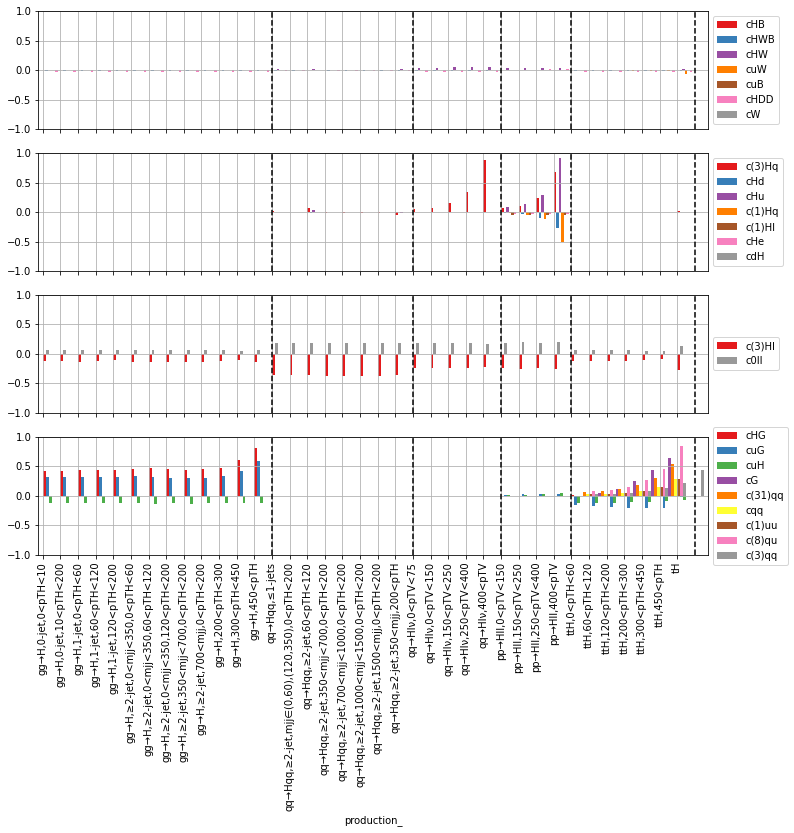

In [17]:
temp = prod
temp['cHW'] = temp['cHW'] + 0.1622
temp['cHB'] = temp['cHB'] + 0.021
temp['cHWB'] = temp['cHWB'] - 0.162
temp2 = decay -   decay_H.to_numpy()
temp2['cHW'] = temp2['cHW'] - 0.1622
temp2['cHB'] = temp2['cHB'] - 0.021
temp2['cHWB'] = temp2['cHWB'] + 0.162
linearized = pd.concat([temp,temp2],axis=0)
fig, axes = plt.subplots(nrows=4, ncols=1, sharex= True)
(prod.loc[:,['cHB','cHWB','cHW','cuW','cuB','cHDD','cW']]*[0.02,0.04,0.04,0.4,0.4,1,0.4]).plot.bar(ax=axes[0],colormap = 'Set1',figsize= (12,10), grid =True, ylim=[-1,1],align='edge',width= 1)
(prod.loc[:,['c(3)Hq','cHd','cHu','c(1)Hq','c(1)Hl','cHe','cdH']]*[0.04,0.2,0.2,0.2,1,1,1]).plot.bar(ax=axes[1],colormap = 'Set1',figsize= (12,10), grid =True, ylim=[-1,1],align='edge',width= 1)
(prod.loc[:,['c(3)Hl','c0ll']]*[1,1]).plot.bar(ax=axes[2],colormap = 'Set1',figsize= (12,10), grid =True, ylim=[-1,1],align='edge',width = 2/6)
(prod.loc[:,['cHG','cuG','cuH','cG','c(31)qq','cqq','c(1)uu','c(8)qu','c(3)qq']]*[0.01,0.2,1,1,0.2,0.2,0.2,1,1]).plot.bar(ax=axes[3],colormap = 'Set1',figsize= (12,10), grid =True, ylim=[-1,1],align='edge',width =9/6)
for ax in axes:
     ax.vlines(x= [13,21,26,30,37],ymin=-1,ymax=1, color='k', linestyle='--')
     ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.savefig('validation/ATLAS-CONF-2021-053/parameter.pdf',bbox_inches='tight')


In [7]:
def l(dictt = {'ceH': np.array([-0.05, 0.05])}):
# dictt = {'ceH': np.array([-5, 5])}
  C_df = function.make_C_df_eft(dictt.copy())
  prod_ = function.multiply(prod, C_df)
  decay_ = function.multiply(decay, C_df)
  decay_Z_ = function.multiply(decay_Z, C_df)
  decay_H_ = function.multiply(decay_H, C_df)
  add_signature = [function.theoretical_signature(i) for i in a.signature_list]
  y = np.concatenate((((prod_+1) * (decay_Z_+1)/(decay_H_+1))*a.used_observable[0].loc[:,[add_signature[0]]].to_numpy(),
                    (((decay_+1) / (decay_Z_+1) ) * a.used_observable[1].loc[:,[add_signature[1]]].to_numpy())), axis=1)
  return function.likelihood(y, np.concatenate(a.used_yhat, axis=0),
    a.used_correlation,
    np.concatenate(a.used_uncertainty, axis=0),
    correlation_theo=np.identity(
      a.used_observable[0].shape[0]+a.used_observable[1].shape[0]),
      uncertainty_theo=np.concatenate(
      a.used_theo_uncertainty, axis=0),
      likelihood_type=0
  )


In [8]:
def symetrize(array,type = 'sys', sensitivity = 1):# [-,+]-> sigma, delta
  array = np.abs(np.array(array))
  if type == 'sys':
   return array.sum(axis=1, keepdims= True)/2, (array[:,1:2] -array[:,0:1])/2
  if type == 'stat':
   return array.sum(axis=1, keepdims= True)/2, (array[:,1:2] -array[:,0:1])/2*sensitivity
temp = prod+decay_Z.to_numpy() - decay_H.to_numpy()
temp['cHW'] = temp['cHW'] + 0.1622
temp['cHB'] = temp['cHB'] + 0.021
temp['cHWB'] = temp['cHWB'] - 0.162
temp2 = decay - decay_Z.to_numpy()
temp2['cHW'] = temp2['cHW'] - 0.1622
temp2['cHB'] = temp2['cHB'] - 0.021
temp2['cHWB'] = temp2['cHWB'] + 0.162
linearized = pd.concat([temp,temp2],axis=0)\
 *ob[['σ_SM']].to_numpy()
linearized = linearized.loc[:,mat.columns].dot(mat.T)
sigma_stat, delta_stat = symetrize(ob.iloc[:,[4,3]], 'stat')
sigma_sys, delta_sys = symetrize(ob.iloc[:,[6,5]], 'sys')
# sig = (sigma_stat**2 + sigma_sys**2)**0.5
sig = (ob.iloc[:,[1]].to_numpy()+ob.iloc[:,[2]].to_numpy())/2
delta = delta_stat + delta_sys
cov = sig.dot(sig.T)*(cor)
sig_th = np.array((ob[['Δ+σ_SM(tot)','Δ-σ_SM(tot)']].abs().sum(axis=1))/2).reshape(-1,1)
cov_th = sig_th.dot(sig_th.T)*(np.identity((ob.shape[0])))
cov = cov + cov_th
# cov = sig.dot(sig.T)*cor

In [50]:
A = linearized.to_numpy()
yhat = (ob.iloc[:,0:1] - ob[['σ_SM']].to_numpy() ).to_numpy()
temp = np.linalg.inv(A.T.dot(np.linalg.inv(cov)).dot(A)).dot(A.T).dot(np.linalg.inv(cov)).dot(yhat)
temp

array([[-0.01240456],
       [ 2.48482498],
       [ 2.32658976],
       [-0.66261465],
       [-0.30468996],
       [ 0.17033206],
       [-2.40558158],
       [ 0.00411749],
       [ 0.62545974],
       [-2.46520894],
       [-0.00424721],
       [-0.39485264],
       [ 0.12135726]])

In [66]:
temp2 = np.array([[-4.70362803e-03,  2.13633892e+00,  1.89574086e+00,  2.37702548e+00,
       -5.05553754e-03,  9.87872005e-02, -1.84138275e+00,  3.20196757e-03,
        4.90522729e-01, -1.74505241e+00, -2.15918961e-03, -2.99181820e-01,
        1.11186735e-01]]).T
# temp2 = np.ones((13,1))*0.5
(yhat - A.dot(temp2)).T.dot(np.linalg.inv(cov)).dot(yhat - A.dot(temp2))

array([[55.13297392]])

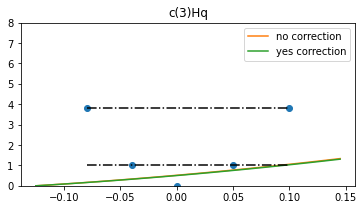

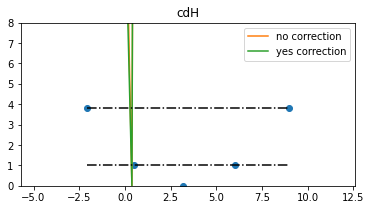

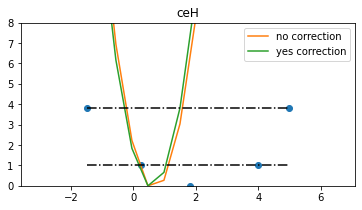

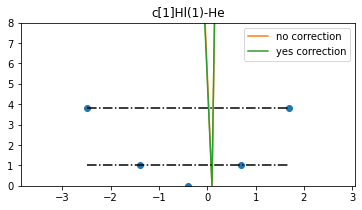

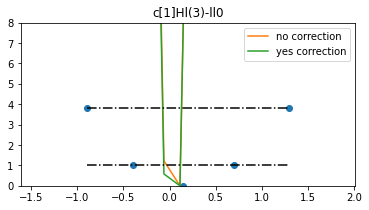

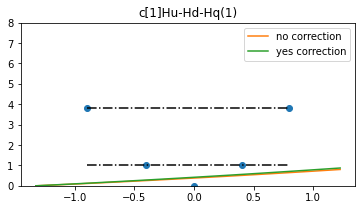

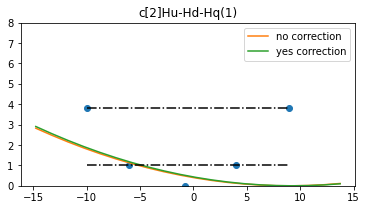

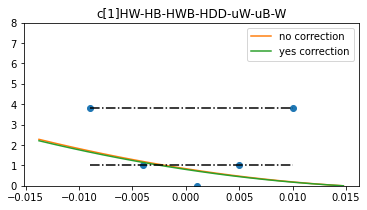

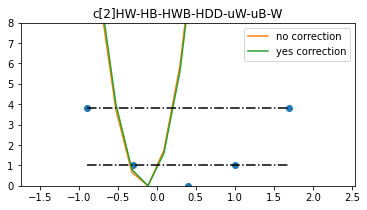

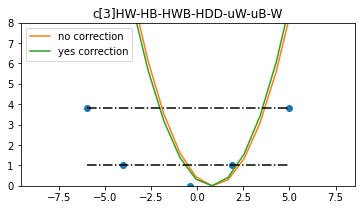

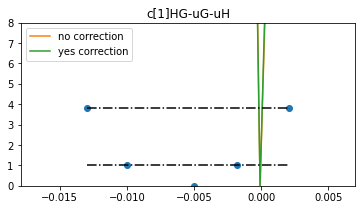

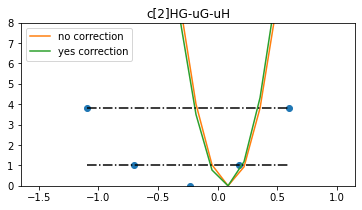

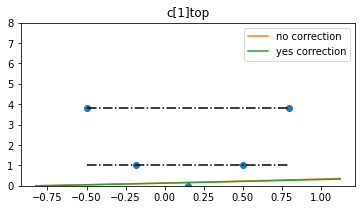

In [10]:
exp_df = pd.read_csv('validation/ATLAS-CONF-2021-053/2021-053.csv', index_col=0)
for i in mat.index:
   fig, ax = plt.subplots( figsize=(6, 3))
   ax.plot(exp_df.loc[i],[0,1,1,3.84,3.84], '.', markersize=12)
   l_list = []
   xrange = exp_df.loc[i].max() - exp_df.loc[i].min()
   xcenter = (exp_df.loc[i].max() + exp_df.loc[i].min())/2
   cs = np.linspace(xcenter-xrange*0.75,xcenter+xrange*0.75,20)
   for correction in [0,1]:
      l_list2 = []
      for ci in cs:
         ai = linearized[[i]].to_numpy()
         A = linearized.drop(columns = i).to_numpy()
         yhat = (ob.iloc[:,0:1] - ob[['σ_SM']].to_numpy() + delta*correction -ai * ci).to_numpy()
         temp = np.linalg.inv(A.T.dot(np.linalg.inv(cov)).dot(A)).dot(A.T).dot(np.linalg.inv(cov)).dot(yhat)
         # temp = np.insert(temp, Ni, ci, axis =0)
         l_list2.append((yhat - A.dot(temp)).T.dot(np.linalg.inv(cov)).dot(yhat - A.dot(temp))[0,0])
      l_list.append(l_list2)
   ax.plot(cs , l_list[0] - min(l_list[0]), label= 'no correction')
   ax.plot(cs , l_list[1] - min(l_list[1]),  label= 'yes correction')
   ax.hlines([1,3.84], xmin=exp_df.loc[i].min(),xmax=exp_df.loc[i].max(), linestyles ='-.',colors = 'k')
   ax.set_title(i)
   ax.legend()
   plt.ylim([0,8])

In [ ]:
linearized = pd.concat([prod+decay_Z.to_numpy()-decay_H.to_numpy()\
,decay - decay_Z.to_numpy()],axis=0)*ob[:,[3]]
# (np.linalg.eig(linearized.T.dot(np.linalg.inv(cov).dot(linearized)))[0]>0.1).sum()
sig = np.absolute(ob[:,[2]]*np.abs(ob[:,[1]])+(ob[:,[1]]-np.abs(ob[:,[2]]))*(ob[:,[3]]-ob[:,[0]]))**(1/2)
# cov = sig.dot(sig.T)*(cor)
cov = 0
sig_th = np.absolute(ob[:,[4]]*np.abs(ob[:,[5]])+(ob[:,[4]]-np.abs(ob[:,[5]]))*(ob[:,[3]]-ob[:,[0]]))**(1/2)
cov_th = sig.dot(sig.T)*(np.identity(ob.shape[0]))
val= (np.linalg.eig(linearized.iloc[:].T.dot(np.linalg.inv(cov).dot(linearized.iloc[:]))))[0]
vec = (np.linalg.eig(linearized.iloc[:].T.dot(np.linalg.inv(cov).dot(linearized.iloc[:]))))[1]
df = pd.DataFrame(np.real(vec).T,columns=linearized.columns).set_axis(np.real(val))
df.index.name= 'eigen value'
# df.iloc[:13].style.background_gradient( vmin=-1, vmax=1,cmap='PuOr').format(precision=2).to_html('validation/ATLAS-CONF-2020-053/eigenvalue.html')
df = df.loc[:,linearized.columns]
temp=['c(3)Hq', 'cHB', 'cHW', 'cHWB', 'cuB', 'cuW', 'cHDD', 'cHd', 'cHu' ,'c(1)Hq', 'cHe' ,'c(1)Hl' ,'c(3)Hl', 'c0ll', 'cHG', 'cuG', 'cG' ,'c(8)qd' ,'c(1)qq', 'cqq' ,'c(3)qq' ,'c(31)qq' ,'c(1)qu' ,'c(8)qu', 'cuH' ,'c(8)ud', 'cuu' ,'c(1)uu', 'cHbox', 'cdH', 'cW', 'ceH']
temp.extend(list(np.setdiff1d(linearized.columns,temp)))
df.index += df.index+np.vectorize(lambda x:0.00000001 if x else 0.)(df.index.duplicated())
style = df\
.iloc[:].loc[:,temp].round(2).style.background_gradient( vmin=-1, vmax=1,cmap='PuOr').\
format(lambda x: '' if x==0 else x)\
.set_table_styles([{'selector': 'table', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})\
.set_table_styles([{'selector': 'th', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})\
.format_index(precision=2)
style.to_html('validation/ATLAS-CONF-2020-053/latex/eigen_vectors.html')
style

In [11]:
def sub_vec(columns, threshold_value =0.2):
    # sig = np.absolute(ob[:,[2]]*np.abs(ob[:,[1]])+(ob[:,[1]]-np.abs(ob[:,[2]]))*(ob[:,[3]]-ob[:,[0]]))**(1/2)
    # cov = sig.dot(sig.T)*(cor)
    # sig_th = np.absolute(ob[:,[4]]*np.abs(ob[:,[5]])+(ob[:,[4]]-np.abs(ob[:,[5]]))*(ob[:,[3]]-ob[:,[0]]))**(1/2)
    # cov_th = sig.dot(sig.T)*(np.identity(ob.shape[0]))
    val= (np.linalg.eig(linearized.loc[:,columns].T.dot(np.linalg.inv(cov_th+cov).dot(linearized.loc[:,columns]))))[0]
    vec = (np.linalg.eig(linearized.loc[:,columns].T.dot(np.linalg.inv(cov_th+cov).dot(linearized.loc[:,columns]))))[1]
    df = pd.DataFrame(np.real(vec).T,columns=columns).set_axis(np.real(val))
    return df[val>threshold_value]
df = pd.concat([
    sub_vec(['c(3)Hq'],0),
    sub_vec(['cdH'],0),
    sub_vec(['ceH'],0),
    sub_vec(['cHe','c(1)Hl'],0),
    sub_vec([ 'c(3)Hl', 'c0ll'],0),
    sub_vec(['cHd', 'cHu','c(1)Hq'],0),
    sub_vec(['cHB','cHW','cHWB','cHDD','cW','cuB','cuW'],0),
    sub_vec(['cHG', 'cuG','cuH'],0),
    sub_vec(['cG','c(8)qd', 'c(1)qq', 'cqq', 'c(3)qq', 'c(31)qq', 'c(1)qu', 'c(8)qu', 'cuu', 'c(1)uu'],0),
])
df.index.name='eigen value of subspace'
style = df.round(2).style.background_gradient( vmin=-1, vmax=1,cmap='PuOr')\
.format(lambda x: '' if x==0 else x)\
.set_table_styles([{'selector': 'table', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})\
.set_table_styles([{'selector': 'th', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})\
.format_index(precision=2).format(na_rep='', precision = 2)
style.to_html('validation/ATLAS-CONF-2021-053/rotation/sub_vec_full.html')
style

,c(3)Hq,cdH,ceH,cHe,c(1)Hl,c(3)Hl,c0ll,cHd,cHu,c(1)Hq,cHB,cHW,cHWB,cHDD,cW,cuB,cuW,cHG,cuG,cuH,cG,c(8)qd,c(1)qq,cqq,c(3)qq,c(31)qq,c(1)qu,c(8)qu,cuu,c(1)uu
eigen value of subspace,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
826.67,1.00,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.33,,1.00,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.04,,,1.00,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.01,,,,-0.76,-0.65,,,,,,,,,,,,,,,,,,,,,,,,,
1.33,,,,0.65,-0.76,,,,,,,,,,,,,,,,,,,,,,,,,
6.58,,,,,,0.80,-0.60,,,,,,,,,,,,,,,,,,,,,,,
0.05,,,,,,0.60,0.80,,,,,,,,,,,,,,,,,,,,,,,
23.96,,,,,,,,-0.25,0.86,-0.44,,,,,,,,,,,,,,,,,,,,
0.00,,,,,,,,0.93,0.34,0.12,,,,,,,,,,,,,,,,,,,,


In [12]:
df = pd.concat([
    sub_vec(['c(3)Hq'],0.02),
    sub_vec(['cdH'],0.02),
    sub_vec(['ceH'],0.02),
    sub_vec(['cHe','c(1)Hl'],0.02),
    sub_vec([ 'c(3)Hl', 'c0ll'],0.02),
    sub_vec(['cHd', 'cHu','c(1)Hq'],0.02),
    sub_vec(['cHB','cHW','cHWB','cHDD','cW','cuB','cuW'],0.02),
    sub_vec(['cHG', 'cuG','cuH'],0.02),
    sub_vec(['cG','c(8)qd', 'c(1)qq', 'cqq', 'c(3)qq', 'c(31)qq', 'c(1)qu', 'c(8)qu', 'cuu', 'c(1)uu'],0.02),
])
df.index.name='eigen value of subspace'
style = df.round(2).style.background_gradient( vmin=-1, vmax=1,cmap='PuOr')\
.format(lambda x: '' if x==0 else x)\
.set_table_styles([{'selector': 'table', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})\
.set_table_styles([{'selector': 'th', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})\
.format_index(precision=2).format(na_rep='', precision = 2)
style.to_html('validation/ATLAS-CONF-2021-053/rotation/sub_vec_partial.html')
style

,c(3)Hq,cdH,ceH,cHe,c(1)Hl,c(3)Hl,c0ll,cHd,cHu,c(1)Hq,cHB,cHW,cHWB,cHDD,cW,cuB,cuW,cHG,cuG,cuH,cG,c(8)qd,c(1)qq,cqq,c(3)qq,c(31)qq,c(1)qu,c(8)qu,cuu,c(1)uu
eigen value of subspace,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
826.67,1.00,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.33,,1.00,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.04,,,1.00,,,,,,,,,,,,,,,,,,,,,,,,,,,
1.33,,,,0.65,-0.76,,,,,,,,,,,,,,,,,,,,,,,,,
6.58,,,,,,0.80,-0.60,,,,,,,,,,,,,,,,,,,,,,,
0.05,,,,,,0.60,0.80,,,,,,,,,,,,,,,,,,,,,,,
23.96,,,,,,,,-0.25,0.86,-0.44,,,,,,,,,,,,,,,,,,,,
0.06,,,,,,,,-0.26,0.38,0.89,,,,,,,,,,,,,,,,,,,,
4692.39,,,,,,,,,,,-0.84,-0.27,0.47,-0.01,-0.02,-0.05,-0.02,,,,,,,,,,,,,


In [ ]:
temp3 =pd.concat([prod3.iloc[np.r_[:14,16,14,15,17:19,39,19,20,41,42,21:26],:],decay3.iloc[[1,0,2],:]-decay3.iloc[3,:]],axis=0).\
 set_axis(ob.iloc[np.r_[:14,16,14,15,17:19,39,19,20,41,42,21:26],:].droplevel(['production','decay']).index.append(pd.Index(decay[:3]['production_'])))
fig, axes = plt.subplots(nrows=4, ncols=1, sharex= True)
(temp3.iloc[:,1:4]*[0.02,1,1]).plot.bar(ax= axes[0],colormap = 'Set1',figsize= (12,10), grid =True, ylim=[-1,1],width=1,align='edge')
(temp3.iloc[:,4:6]*[0.5,5]).plot.bar(ax=axes[1],colormap = 'Set1',figsize= (12,10), grid =True, ylim=[-1,1],width=2/3,align='edge')
(temp3.iloc[:,6:7]).plot.bar(ax=axes[2],colormap = 'Set1',figsize= (12,10), grid =True, ylim=[-1,1],width=1/3,align='edge')
(temp3.iloc[:,7:]*[0.01,0.5,1]).plot.bar(ax=axes[3],colormap = 'Set1',figsize= (12,10), grid =True, ylim=[-1,1],width=1,align='edge')
for ax in axes:
     ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
     ax.vlines(x= [11,17,24,29],ymin=-1,ymax=1, color='k', linestyle='--')
plt.savefig('validation/ATLAS-CONF-2020-053/rotated_parameter.pdf',bbox_inches='tight')


# ATLA-CONF-2020-053

## data processing

In [4]:
path = 'data/ATLAS-CONF-2020-053/raw data/smeft parametrization.txt'
with open(path, 'r', encoding='Utf-8') as f:
    S = f.read()
lines = re.split('\n', S)
bins, terms = [], []
for line in lines:
    # print(N)
    bins.append(re.split(r', (?=-?\d+.\d* ?c)', line, 1)[0])
    terms.append(re.split(r', (?=-?\d+.\d* ?c)', line, 1)[1])
bins = [i.replace(' ','') for i in bins]
dfs = []
count=0
for term in terms:
    # print(term)
    temp = re.split(r'(?:\s+)?(\+|\-)(?:\s+)?', term)
    coeffs, names = [], []
    signs = []
    for i in temp:
        # print(temp)
        if re.match(r'(\d+(?:\.\d+)?) ?(c[\w\(\)]*)+', i):
            coeffs.append(
                re.match(r'(\d+(?:\.\d+)?) ?(c[\w\(\)]*)+', i).group(1))
            names.append(
                re.match(r'(\d+(?:\.\d+)?) ?(c[\w\(\)]*)+', i).group(2) or '1')
        else:
            signs.append(i)
    signs = [i for i in signs if i]
    signs = np.array([{'+': 1, '-': -1}.get(i) for i in signs])
    coeffs = np.array(coeffs).astype(float)
    coeffs[-signs.shape[0]:] = coeffs[-signs.shape[0]:] * signs
    dfs.append(pd.DataFrame(data=[coeffs],
                columns=names).reset_index(drop=True))
df = pd.concat(dfs, axis=0).set_axis(bins, axis=0).fillna(0)
df.index.name = 'production_'
# return df

In [138]:
def fix_index_name(df):
 return df.index.str.replace(r'.*gg.{0,2}H.*',r'ggF',flags=re.I,regex=True)\
 .str.replace(r'.*qq.{0,3}Hq.*',r'VBF',flags=re.I,regex=True)\
 .str.replace(r'.*qq.{0,3}Hlν.*','WH',flags=re.I,regex=True)\
 .str.replace(r'.*pp.{0,3}Hll.*','ZH',flags=re.I,regex=True)\
 .str.replace(r'.*B.{2}.*','none',flags=re.I,regex=True)\
 .str.replace(r'tt.*',r'ttH',regex=True)\
 .str.replace(r'.*(V|W|Z)(H).*',r'\1H',regex=True).rename('production')

In [139]:
id =  df[-4:].index.str.replace('`','l',regex=True)\
 .str.replace(r".*WW.*",'WW',regex=True)\
 .str.replace('.*bb.*','bb',regex=True)\
 .str.replace(r'.*γγ.*','gaga',regex=True)\
 .str.replace(r'.*ZZ.*','ZZ',regex=True)\
 .str.replace(r'.*all.*','all',regex=True)\
 .str.replace('.*tt.*','tautau',regex=True).to_list()
decay = pd.concat({'Γ/Γ_SM-1': df[-4:]}, names=['signature'])
decay['decay']=id
decay['production']= 'mixed'
decay.reset_index().set_index(['signature','production_','production','decay']).to_csv('data/ATLAS-CONF-2020-053/smeft_parametrization/decay.csv')

In [18]:
pd.concat({'σ/σ_SM-1': df[:-4]}, names=['signature']).to_csv('data/ATLAS-CONF-2020-053/smeft_parametrization/production.csv')
pd.concat({'Γ/Γ_SM-1': df[-4:]}, names=['signature']).to_csv('data/ATLAS-CONF-2020-053/smeft_parametrization/decay.csv')

In [140]:
id = fix_index_name(df[:-4])
prod = pd.concat({'σ/σ_SM-1': df[:-4]}, names=['signature'])
prod['production']=id
prod['decay']= 'mixed'
prod.reset_index().set_index(['signature','production_','production','decay'])\
 .to_csv('data/ATLAS-CONF-2020-053/smeft_parametrization/production.csv')

## calculate

In [104]:
mat= '''1
-0.84 -0.27 0.47 -0.05 -0.02 0
0.19 -0.96 -0.2 0.02 0 0
0.5  -0.08 0.86 0.06 0.03 0.07
0.26  -0.87 0.42
-0.62 0.78
0.87  -0.5
0.99 0.03 0 0 0 0 0 0 0 0 0 0 0 0
-0.03 0.73  -0.18  -0.04  -0.03  -0.23 -0.05 -0.54  -0.01  -0.15 0.06 -0.04 -0.02  -0.24
-0.03 0.67 0.29 0.03 0.04 0.25 0.05 0.55 0.01 0.16 0.1 0.03 0.02 0.26'''
cs = '''c(3)Hq cHB cHW cHWB cuB cuW cHDD cHd cHu c(1)Hq cHe c(1)Hl c(3)Hl c0ll cHG cuG cG c(8)qd c(1)qq cqq c(3)qq c(31)qq c(1)qu c(8)qu cuH c(8)ud cuu c(1)uu'''
csp='''c[3]HG-uG-uH-top
c[2]HG-uG-uH-top
c[1]HG-uG-uH-top
c[1]Hl(3)-ll0
c[1]Hl(1)-He
c[1]Hu-Hd-Hq(1)
c[3]HW-HB-HWB-HDD-uW-uB
c[2]HW-HB-HWB-HDD-uW-uB
c[1]HW-HB-HWB-HDD-uW-uB
c(3)Hq'''
temp = [1,3,1,1,1,3]
temp1 =re.split('\n', mat)
count = 0
temp2 = []
for i in temp:
 temp2.append('\n'.join(temp1[count:count+i]))
 count +=i
temp3 = [pd.read_csv(StringIO(i),sep = '\s+',header=None) for i in temp2]
mat = np.zeros((sum([i.shape[0] for i in temp3]),sum([i.shape[1] for i in temp3])))
count = np.array([0,0])
for i in temp3:
 mat[count[0]:i.shape[0]+count[0],count[1]:count[1]+i.shape[1]]= i.to_numpy()
 count += [i.shape[0],i.shape[1]]
mat = pd.DataFrame(mat)
couplings =pd.read_csv(StringIO(cs),sep='\s+',header = None)
mat.columns = couplings.loc[0]
mat = mat.set_axis(pd.read_csv(StringIO(csp),header= None).values[::-1,0])

In [95]:
prod = pd.read_csv('data/ATLAS-CONF-2020-053/smeft_parametrization/production copy.csv').drop(columns=['production','signature','decay'])
decay = pd.read_csv('data/ATLAS-CONF-2020-053/smeft_parametrization/decay copy.csv').drop(columns=['production','signature','decay'])
# prod1 = pd.read_csv('data/ATLAS-CONF-2021-053/smeft_parametrization/production.csv').drop(columns=['production','signature','decay'])
VBF = pd.read_csv('global_data/correlation_theory/VBF/uncertainty.csv')
prod1 = pd.read_csv('data/ATLAS-CONF-2021-053/smeft_parametrization/production.csv',index_col=[0])
decay1 = pd.read_csv('data/ATLAS-CONF-2021-053/smeft_parametrization/decay.csv',index_col=[0])
VH = pd.read_csv('global_data/correlation_theory/VH/uncertainty.csv')

In [96]:
def combine(vv, ii ,prod = prod):
 s = 0
 if 'production_' in prod.columns: 
  for v,i in zip(vv,ii):
   s += (v)/(sum(vv))*prod.drop(columns ='production_').loc[i]
 else:
  for v,i in zip(vv,ii):
   s += (v)/(sum(vv))*prod.iloc[i]
 return s.to_frame().T
prod2= pd.concat([
    #ggF
    prod.loc[[4,5,6,7,8]],
    combine([1,1],[9,10]),
    prod.loc[[11]],
    combine([1,1,1,1],[12,13,14,15]),
    prod.loc[[0,1]],
    prod1.iloc[[12]],
    #qqHqq
    combine([VBF.iloc[1,2],VBF.iloc[2,2]],[21,22]),
    combine([VBF.iloc[3,2]+VBF.iloc[6,2],VBF.iloc[5,2]+VBF.iloc[8,2]],[23,25]),
    prod.loc[[24]],
    combine([VBF.iloc[9,2],VBF.iloc[10,2]],[27,28]),
    combine([VBF.iloc[11,2]+VBF.iloc[13,2]+VBF.iloc[15,2],VBF.iloc[12,2]+VBF.iloc[14,2]+VBF.iloc[16,2]],[29,30]),
    prod.loc[[26]],
    #qqHlv
    combine([VH.iloc[0,2],VH.iloc[1,2]],[31,32]),
    combine([1,1,0.2],[33,34,35]),
    #gg/qqHll
    prod1.iloc[[26]],
    combine([32,4,4],[27,28,29],prod1),
    #ttH
    prod.loc[[41,42,43]],
    combine([1,0.5],[44,45]),
    # tH
    prod.loc[[46]],
    #ggH
    prod.loc[[4,5,6,7,8]],
    combine([1.17,1.8,0.94,0.61/2,0.62/2,0.27/2,0.27/2],[9,10,11,12,13,14,15]),
    combine([0.46,0.106,0.018/2,0.018/2],[0,1,2,3]),
    #qqHqq
    combine([VBF.iloc[9,2],VBF.iloc[10,2],VBF.iloc[11:17:2,2].sum(),VBF.iloc[12:17:2,2].sum()],[27,28,29,30]),
    prod.loc[[24]],
    prod.loc[[26]],
    #VHlep
    combine([216.4,135.0,41.24/2,41.24/2,12.16,112.4,87.0,32.3/2,32.3/2,8.33,6.7,17.0,10.2/2,10.2/2,1.94],[31,32,33,34,35,36,37,38,39,40,16,17,18,19,20]),
    #top
    #b.used_observable[0].loc[(slice(None),['ttH','tH'],slice(None))]['σ_SM'].tolist()
    combine([0.118, 0.178, 0.126, 0.053, 0.019+ 0.0054, 0.085],[41,42,43,44,45,46]),
    #qqHlv
    combine([VH.iloc[0,2],VH.iloc[1,2],VH.iloc[2,2]/2,VH.iloc[2,2]/2],[31,32,33,34]),
    prod.iloc[[35]],
    #gg/qqHll
    prod1.iloc[[26]],
    prod1.iloc[[27]],
    combine([4,1],[28,29],prod1)
    ]
,ignore_index=True,axis=0).drop(columns= 'production_').fillna(0)
prod2 = prod2.reset_index(drop=True) /prod2.reset_index(drop=True).iloc[:,0:1].to_numpy()*0.12

In [63]:
ob = pd.read_csv('data/ATLAS-CONF-2020-053/stage_1.2/observable.csv',index_col=[0,1,2])
cor = pd.read_csv('data/ATLAS-CONF-2020-053/stage_1.2/correlation.csv',index_col=[0,1,2],header=[0,1,2])
prod3 = prod2.loc[:,mat.columns].dot(mat.T)
decay3 = decay.loc[:,mat.columns].dot(mat.T)
temp =pd.concat([prod2.iloc[np.r_[:14,16,14,15,17:19,39,19,20,41,42,21:26],:],decay.iloc[[1,0,2],:].drop(columns='production_')-decay.iloc[3,:].drop(columns='production_')],axis=0).\
 set_axis(ob.iloc[np.r_[:14,16,14,15,17:19,39,19,20,41,42,21:26],:].droplevel(['production','decay']).index.append(pd.Index(decay[:3]['production_'])))

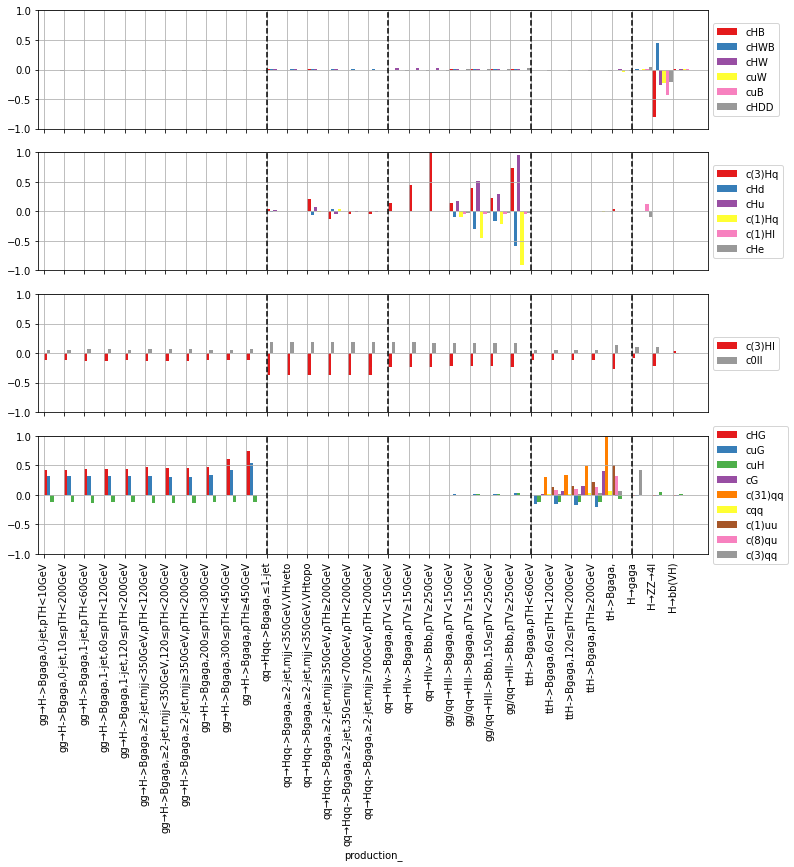

In [64]:
fig, axes = plt.subplots(nrows=4, ncols=1, sharex= True)
(temp.loc[:,['cHB','cHWB','cHW','cuW','cuB','cHDD']]*[0.02,0.02,0.02,0.2,0.2,1]).plot.bar(ax=axes[0],colormap = 'Set1',figsize= (12,10), grid =True, ylim=[-1,1],align='edge',width= 1)
(temp.loc[:,['c(3)Hq','cHd','cHu','c(1)Hq','c(1)Hl','cHe']]*[0.1,1,0.5,1,1,1]).plot.bar(ax=axes[1],colormap = 'Set1',figsize= (12,10), grid =True, ylim=[-1,1],align='edge',width= 1)
(temp.loc[:,['c(3)Hl','c0ll']]*[1,1]).plot.bar(ax=axes[2],colormap = 'Set1',figsize= (12,10), grid =True, ylim=[-1,1],align='edge',width = 2/6)
(temp.loc[:,['cHG','cuG','cuH','cG','c(31)qq','cqq','c(1)uu','c(8)qu','c(3)qq']]*[0.01,0.2,1,1,1,1,1,1,1]).plot.bar(ax=axes[3],colormap = 'Set1',figsize= (12,10), grid =True, ylim=[-1,1],align='edge',width =9/6)
for ax in axes:
     ax.vlines(x= [11,17,24,29],ymin=-1,ymax=1, color='k', linestyle='--')
     ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.savefig('validation/ATLAS-CONF-2020-053/parameter.pdf',bbox_inches='tight')


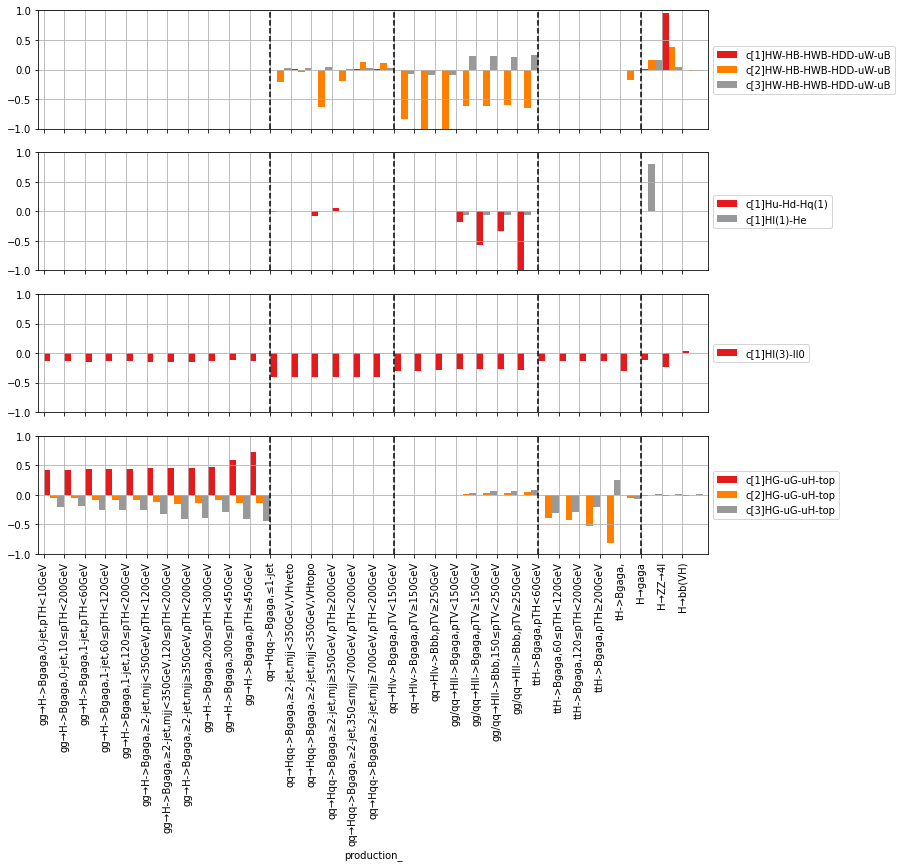

In [7]:
temp3 =pd.concat([prod3.iloc[np.r_[:14,16,14,15,17:19,39,19,20,41,42,21:26],:],decay3.iloc[[1,0,2],:]-decay3.iloc[3,:]],axis=0).\
 set_axis(ob.iloc[np.r_[:14,16,14,15,17:19,39,19,20,41,42,21:26],:].droplevel(['production','decay']).index.append(pd.Index(decay[:3]['production_'])))
fig, axes = plt.subplots(nrows=4, ncols=1, sharex= True)
(temp3.iloc[:,1:4]*[0.02,1,1]).plot.bar(ax= axes[0],colormap = 'Set1',figsize= (12,10), grid =True, ylim=[-1,1],width=1,align='edge')
(temp3.iloc[:,4:6]*[0.5,5]).plot.bar(ax=axes[1],colormap = 'Set1',figsize= (12,10), grid =True, ylim=[-1,1],width=2/3,align='edge')
(temp3.iloc[:,6:7]).plot.bar(ax=axes[2],colormap = 'Set1',figsize= (12,10), grid =True, ylim=[-1,1],width=1/3,align='edge')
(temp3.iloc[:,7:]*[0.01,0.5,1]).plot.bar(ax=axes[3],colormap = 'Set1',figsize= (12,10), grid =True, ylim=[-1,1],width=1,align='edge')
for ax in axes:
     ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
     ax.vlines(x= [11,17,24,29],ymin=-1,ymax=1, color='k', linestyle='--')
plt.savefig('validation/ATLAS-CONF-2020-053/rotated_parameter.pdf',bbox_inches='tight')


In [141]:
decay_ga =decay3[0:1]
decay_Z =decay3[1:2]
decay_b =decay3[2:3]
decay_H =decay3[3:4]
  
linearized = prod3+(pd.concat([pd.concat([decay_ga]*26),pd.concat([decay_Z]*12),pd.concat([decay_b]*5)],axis =0, ignore_index= True))-decay_H.to_numpy()

def l(C_df, type =2, Acc= 1):
  # temp = (C_df.loc[:,mat.index]).dot(mat)
  # C_df =pd.DataFrame(np.zeros((1,10)),columns = mat.index)
  y = (1+function.multiply(linearized,C_df))
  Acc = calculate_A(C_df.loc[:,mat.index].dot(mat))
  # print(Acc)
  Acc = np.concatenate((np.ones((C_df.shape[0],26,1)),
                np.tile(Acc,(1,12,1)),
                np.ones((C_df.shape[0],5,1))),axis=1) 
  y = y* Acc
  # print(calculate_A(temp))
  return (function.likelihood(y,ob.iloc[:,:1] ,
   cor,
   ob.iloc[:,1:3].abs(),
   # correlation_theo=np.identity(
   #   a.used_observable[0].shape[0]+a.used_observable[1].shape[0]),
   #   uncertainty_theo=np.concatenate(
   #   a.used_theo_uncertainty, axis=0),
     likelihood_type=type
 ))
def l2(array):
  return l(pd.DataFrame(array.T, columns=mat.index) )[0,0,0]
def l3_scipy(array):
  return l(pd.DataFrame(array.reshape(1,-1), columns=mat.index) )[0,0,0]
def l3_scipy_profile(loc, val):
  def temp(array):
    return l(pd.DataFrame(np.insert(array, loc, val).reshape(1,-1), columns=mat.index))[0,0,0]
  return temp


In [31]:
sigma = np.array(ob.iloc[:,1:3].abs()).sum(axis=1,keepdims=True)/2
cov = sigma.dot(sigma.T)*cor
A = linearized.copy()
Cp = pd.DataFrame(temp.T, columns = mat.index)
C = Cp.loc[:,mat.index].dot(mat)
y = (1+function.multiply(linearized,Cp))
Acc = calculate_A(C)
Acc = np.concatenate((np.ones((C.shape[0],26,1)),
              np.tile(Acc,(1,12,1)),
              np.ones((C.shape[0],5,1))),axis=1)
dAcc = calculate_A(C, True)
dAcc = np.concatenate((np.zeros((C.shape[0],26,C.shape[1])),
              np.tile(dAcc,(1,12,1)),
              np.zeros((C.shape[0],5,C.shape[1]))),axis=1)
dL_dC = - 2 * np.matmul(np.matmul(np.transpose(ob.iloc[:,:1].to_numpy() - Acc * y, [0,2,1]),(np.linalg.inv(cov))),((dAcc * y).dot(mat.T) + Acc * A.to_numpy()))

In [67]:
temp2 = temp.copy()

In [142]:
l3_scipy_profile(5,10)(np.ones((9)))

611639.6561644027

In [90]:
# temp = temp2.copy() +0.05
# L0 = l(pd.DataFrame(temp, index=mat.index).T)
for i in range(100):
 Cp = pd.DataFrame(temp.T, columns = mat.index)
 C = Cp.loc[:,mat.index].dot(mat)
 y = (1+function.multiply(linearized,Cp))
 Acc = calculate_A(C)
 Acc = np.concatenate((np.ones((C.shape[0],26,1)),
               np.tile(Acc,(1,12,1)),
               np.ones((C.shape[0],5,1))),axis=1)
 dAcc = calculate_A(C, True)
 dAcc = np.concatenate((np.zeros((C.shape[0],26,C.shape[1])),
               np.tile(dAcc,(1,12,1)),
               np.zeros((C.shape[0],5,C.shape[1]))),axis=1)
 dL_dC = - 2 * np.matmul(np.matmul(np.transpose(ob.iloc[:,:1].to_numpy() - Acc * y, [0,2,1]),(np.linalg.inv(cov))),((dAcc * y).dot(mat.T) + Acc * A.to_numpy()))
 
 temp0 = temp.copy()
 temp = temp - 0.000001*dL_dC[0].T
 L1 = l(pd.DataFrame(temp, index=mat.index).T)
 print(L0)
 if (L1 > L0).any():
  break
 L0 = L1
 # print(l(pd.DataFrame(temp - 0.00001*dL_dC[0].T, index=mat.index).T))

[[[27.72631624]]]
[[[27.72457209]]]
[[[27.7228409]]]
[[[27.7211226]]]
[[[27.71941707]]]
[[[27.71772423]]]
[[[27.71604398]]]
[[[27.71437622]]]
[[[27.71272087]]]
[[[27.71107782]]]
[[[27.70944699]]]
[[[27.70782829]]]
[[[27.70622163]]]
[[[27.70462691]]]
[[[27.70304405]]]
[[[27.70147295]]]
[[[27.69991354]]]
[[[27.69836572]]]
[[[27.6968294]]]
[[[27.6953045]]]
[[[27.69379094]]]
[[[27.69228863]]]
[[[27.69079749]]]
[[[27.68931743]]]
[[[27.68784836]]]
[[[27.68639022]]]
[[[27.68494291]]]
[[[27.68350636]]]
[[[27.68208048]]]
[[[27.6806652]]]
[[[27.67926043]]]
[[[27.6778661]]]
[[[27.67648213]]]
[[[27.67510844]]]
[[[27.67374495]]]
[[[27.67239159]]]
[[[27.67104829]]]
[[[27.66971497]]]
[[[27.66839154]]]
[[[27.66707795]]]
[[[27.66577411]]]
[[[27.66447996]]]
[[[27.66319542]]]
[[[27.66192041]]]
[[[27.66065488]]]
[[[27.65939874]]]
[[[27.65815192]]]
[[[27.65691437]]]
[[[27.655686]]]
[[[27.65446675]]]
[[[27.65325655]]]
[[[27.65205533]]]
[[[27.65086303]]]
[[[27.64967958]]]
[[[27.64850492]]]
[[[27.64733897]]]


In [160]:
def dL_dC(array):
 Cp = pd.DataFrame(array.reshape(1,-1), columns = mat.index)
 C = Cp.loc[:,mat.index].dot(mat)
 y = (1+function.multiply(linearized,Cp))
 Acc = calculate_A(C)
 Acc = np.concatenate((np.ones((C.shape[0],26,1)),
               np.tile(Acc,(1,12,1)),
               np.ones((C.shape[0],5,1))),axis=1)
 dAcc = calculate_A(C, True)
 dAcc = np.concatenate((np.zeros((C.shape[0],26,C.shape[1])),
               np.tile(dAcc,(1,12,1)),
               np.zeros((C.shape[0],5,C.shape[1]))),axis=1)
 return - 2 * np.matmul(np.matmul(np.transpose(ob.iloc[:,:1].to_numpy() - Acc * y, [0,2,1]),(np.linalg.inv(cov))),((dAcc * y).dot(mat.T) + Acc * A.to_numpy()))[0,0]
def dL_dC_profile(array, loc, val):
 Cp = pd.DataFrame(np.insert(array.reshape(1,-1),loc,val, axis =1), columns = mat.index)
 C = Cp.loc[:,mat.index].dot(mat)
 y = (1+function.multiply(linearized,Cp))
 Acc = calculate_A(C)
 Acc = np.concatenate((np.ones((C.shape[0],26,1)),
               np.tile(Acc,(1,12,1)),
               np.ones((C.shape[0],5,1))),axis=1)
 dAcc = calculate_A(C, True)
 dAcc = np.concatenate((np.zeros((C.shape[0],26,C.shape[1])),
               np.tile(dAcc,(1,12,1)),
               np.zeros((C.shape[0],5,C.shape[1]))),axis=1)
 temp = - 2 * np.matmul(np.matmul(np.transpose(ob.iloc[:,:1].to_numpy() - Acc * y, [0,2,1]),(np.linalg.inv(cov))),((dAcc * y).dot(mat.T) + Acc * A.to_numpy()))[0,0]
 return np.delete(temp, loc)

In [ ]:
res = minimize(l3_scipy, temp.T[0]+0.1, method='BFGS', jac=dL_dC,
               options={'disp': True})
res.x

In [180]:
loc = 3
val = -0.8009
res = minimize(l3_scipy_profile(loc,val), np.delete(temp2.T[0], loc), method='BFGS', jac=lambda x: dL_dC_profile(x, loc, val))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 31.517145205421688
        x: [ 2.536e-02 -1.311e-02  5.348e-01 -1.700e-03 -1.747e+00
            -9.731e-01  3.570e-03  3.673e-02  8.137e-01]
      nit: 29
      jac: [-6.185e-09  1.876e-08  2.605e-09  1.340e-09  4.969e-10
            -1.243e-09  3.744e-08 -6.461e-10 -1.516e-09]
 hess_inv: [[ 1.294e-03  2.476e-05 ...  1.942e-03  3.348e-03]
            [ 2.476e-05  9.210e-05 ...  1.130e-03  5.726e-04]
            ...
            [ 1.942e-03  1.130e-03 ...  4.955e-02  8.230e-03]
            [ 3.348e-03  5.726e-04 ...  8.230e-03  4.473e-01]]
     nfev: 39
     njev: 39

In [179]:
loc = 3
ls = []
for i in [0.91629]:
 val = i
 res = minimize(l3_scipy_profile(loc,val), np.delete(temp.T[0], loc), method='BFGS', jac=lambda x: dL_dC_profile(x, loc, val),
               options={'disp': True})
 ls.append(res.fun)

Optimization terminated successfully.
         Current function value: 35.559526
         Iterations: 25
         Function evaluations: 29
         Gradient evaluations: 29


In [154]:
sigma = np.array(ob.iloc[:,1:3].abs()).sum(axis=1,keepdims=True)/2
cov = sigma.dot(sigma.T)*cor
A = linearized.copy()

temp = np.linalg.inv(A.T.dot(np.linalg.inv(cov)).dot(A)).dot(A.T).dot(np.linalg.inv(cov)).dot(ob.iloc[:,0:1]-1)
pd.DataFrame(temp, index=mat.index)
l(pd.DataFrame(temp, index=mat.index).T, Acc=1)
# l(pd.DataFrame(np.zeros((10,1)), index=mat.index).T, acc = True)

array([[[26.93113482]]])

In [30]:
sigma = np.array(ob.iloc[:,1:3].abs()).sum(axis=1,keepdims=True)/2
cov = sigma.dot(sigma.T)*cor
A = linearized.copy()
Acc = 0.5
for i in range(20):
  Acc_m = np.concatenate((np.ones((26,1)),
                np.tile(Acc,(12,1)),
                np.ones((5,1))),axis=0)
  A = linearized.copy() * Acc_m
  yhat = (ob.iloc[:,0:1]-Acc_m)
  temp = np.linalg.inv(A.T.dot(np.linalg.inv(cov)).dot(A)).dot(A.T).dot(np.linalg.inv(cov)).dot(yhat)
  Acc = calculate_A((mat.T).dot(temp).T)[0,0,0]
  # print(l(pd.DataFrame(temp.T, columns= mat.index)))

[[[54.44015143]]]
[[[28.47201888]]]
[[[27.43853768]]]
[[[27.3971226]]]
[[[27.3959686]]]
[[[27.39583773]]]
[[[27.39584967]]]
[[[27.3958468]]]
[[[27.39584734]]]
[[[27.39584723]]]
[[[27.39584725]]]
[[[27.39584725]]]
[[[27.39584725]]]
[[[27.39584725]]]
[[[27.39584725]]]
[[[27.39584725]]]
[[[27.39584725]]]
[[[27.39584725]]]
[[[27.39584725]]]
[[[27.39584725]]]


In [328]:
def profile(cs = np.linspace(-0.02,0.02,20), loc =1, iter = 10):
  sigma = np.array(ob.iloc[:,1:3].abs()).sum(axis=1,keepdims=True)/2
  cov = sigma.dot(sigma.T)*cor
  Acc = 0.5
  llhs = []
  for c in cs:
    for i in range(iter):
      col_name = linearized.columns[loc]
      col = linearized.loc[:, [col_name]]
      Acc_m = np.concatenate((np.ones((26,1)),
                    np.tile(Acc,(12,1)),
                    np.ones((5,1))),axis=0)
      A = linearized.drop(columns = col_name).copy() * Acc_m
      yhat = (ob.iloc[:,0:1] - (Acc_m * (1+ col* c)).to_numpy())
      temp = np.linalg.inv(A.T.dot(np.linalg.inv(cov)).dot(A)).dot(A.T).dot(np.linalg.inv(cov)).dot(yhat)
      temp = np.insert(temp, loc , c , axis =0)
      Acc = calculate_A((mat.T).dot(temp).T)[0,0,0]
      print(Acc)
    llhs.append(temp)
  return llhs

(0.0, 6.96471)

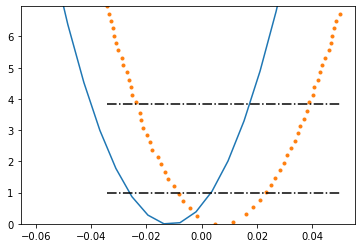

In [45]:
temp = pd.read_csv(f'validation/ATLAS-CONF-2020-053/{mat.index[1]}.csv', header=0)
fig, ax = plt.subplots()
cs = np.linspace(-0.06,0.05,20)
temp2 = profile(cs,1)
yy = l(pd.DataFrame(np.array(temp2).reshape(20,10), columns =mat.index)).reshape(-1)
ax.plot(cs,yy-yy.min())
ax.plot(temp['x'],temp[' y'],'.')
ax.hlines([1,3.84], xmin=temp['x'].min(),xmax=temp['x'].max(), linestyles ='-.',colors = 'k')
plt.ylim([temp[' y'].min(),temp[' y'].max()])

(-0.02439, 6.97561)

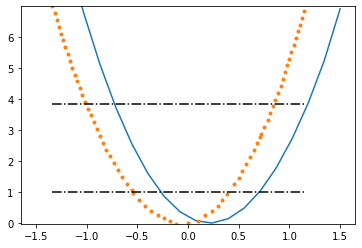

In [46]:
temp = pd.read_csv(f'validation/ATLAS-CONF-2020-053/{mat.index[2]}.csv', header=0)
fig, ax = plt.subplots()
cs = np.linspace(-1.5,1.5,20)
temp2 = profile(cs,2)
yy = l(pd.DataFrame(np.array(temp2).reshape(20,10), columns =mat.index)).reshape(-1)
ax.plot(cs,yy-yy.min())
ax.plot(temp['x'],temp[' y'],'.')
ax.hlines([1,3.84], xmin=temp['x'].min(),xmax=temp['x'].max(), linestyles ='-.',colors = 'k')
plt.ylim([temp[' y'].min(),temp[' y'].max()])

(0.0, 8.0)

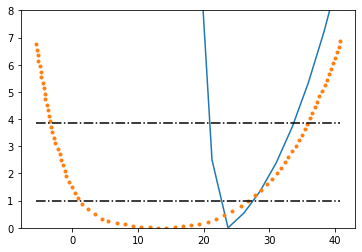

In [58]:
loc = 5
temp = pd.read_csv(f'validation/ATLAS-CONF-2020-053/{mat.index[loc]}.csv', header=0)
fig, ax = plt.subplots()
xrange = temp['x'].max() - temp['x'].min()
xcenter = (temp['x'].max() + temp['x'].min())/2
cs = np.linspace(xcenter-xrange*0.5,xcenter+xrange*0.5,20)
temp2 = profile(cs,loc)
yy = l(pd.DataFrame(np.array(temp2).reshape(20,10), columns =mat.index)).reshape(-1)
ax.plot(cs,yy-yy.min())
ax.plot(temp['x'],temp[' y'],'.')
ax.hlines([1,3.84], xmin=temp['x'].min(),xmax=temp['x'].max(), linestyles ='-.',colors = 'k')
plt.ylim([0,8])

In [166]:
def symetrize(df,type = 'sys', sensitivity = 1):
  df = np.abs(df.to_numpy())
  if type == 'sys':
   return df.sum(axis=1, keepdims= True)/2,(df[:,1:2] -df[:,0:1])/2
  if type == 'stat':
   return df.sum(axis=1, keepdims= True)/2,(df[:,1:2] -df[:,0:1])/2*sensitivity
sigma_sys, delta_sys  = symetrize(ob.iloc[:,[5,6]], 'sys')
sigma_stat, delta_stat  = symetrize(ob.iloc[:,[3,4]], 'stat')
obsp = ob.iloc[:,0:1]+ delta_sys + delta_stat
sigma = np.sqrt(sigma_sys**2 + sigma_stat**2)
# sigma = np.array(ob.iloc[:,1:3]).sum(axis=1,keepdims=True)/2
cov = sigma.dot(sigma.T)*cor
A = linearized.copy()
# np.linalg.inv(A.T.dot(np.linalg.inv(cov)).dot(A)).dot(A.T).dot(np.linalg.inv(cov)).dot(obsp)
temp = np.linalg.inv(A.T.dot(np.linalg.inv(cov)).dot(A)).dot(A.T).dot(np.linalg.inv(cov)).dot(obsp)
pd.DataFrame(temp, index=mat.index)

In [28]:
norm = np.array([[5,100,1,1,10,0.5,1,100,3,1]])/6
C_rand = (np.random.rand(100,10)-0.5)/norm
x = np.linspace(-1.5,1.5,100)
ML =[]
for Ni,i in enumerate(x):
  temp = C_rand.copy()
  temp[:,1] = i/norm[0,1]
  ML.append(l(pd.DataFrame(temp,columns= mat.index), type=2).sum())
# fig, ax = plt.subplots()
# count = 1
# X = np.zeros((200,10))
# X[:,N] = x
# temp = l(pd.DataFrame(X,columns= mat.index), type=2)[:,0,0]
# ax.plot(x,temp, label = f'loop {count}')
# ax.set_title(mat.index[N])
# count+=1
# X = np.zeros((200,10))
# plt.savefig('validation/ATLAS-CONF-2020-053/rotated_parameter_guess.pdf',bbox_inches='tight')

### modified

In [ ]:
decay_ga =decay3[0:1]
decay_Z =decay3[1:2]
decay_b =decay3[2:3]
decay_H =decay3[3:4]
def symetrize(df,type = 'sys', sensitivity = 0.8):
  df = np.abs(df.to_numpy())
  if type == 'sys':
   return df.sum(axis=1, keepdims= True)/2,(df[:,1:2] -df[:,0:1])/2
  if type == 'stat':
   return df.sum(axis=1, keepdims= True)/2,(df[:,1:2] -df[:,0:1])/2*sensitivity
  
linearized = prod3+(pd.concat([pd.concat([decay_ga]*26),pd.concat([decay_Z]*12),pd.concat([decay_b]*5)],axis =0, ignore_index= True))-decay_H.to_numpy()
# sigma_sys, delta_sys  = symetrize(ob.iloc[:,[5,6]], 'sys')
# sigma_stat, delta_stat  = symetrize(ob.iloc[:,[3,4]], 'stat')
# obsp = ob.iloc[:,0:1]+ delta_sys + delta_stat
# sigma = np.sqrt(sigma_sys**2 + sigma_stat**2)
sigma = np.array(ob.iloc[:,1:3]).sum(axis=1,keepdims=True)/2
obsp = ob.iloc[:,0:1]
def l(C_df, type =2):
 temp = (C_df.loc[:,mat.index]).dot(mat)
 # C_df =pd.DataFrame(np.zeros((1,10)),columns = mat.index)
 y = (1+function.multiply(linearized,C_df))
 y_acceptance= y*np.concatenate((np.ones((C_df.shape[0],26,1)),
                np.tile(calculate_A(temp),(1,12,1)),
                np.ones((C_df.shape[0],5,1))),axis=1)
#  return y
 return (function.likelihood(y_acceptance,obsp ,
   cor,
   sigma,
   # correlation_theo=np.identity(
   #   a.used_observable[0].shape[0]+a.used_observable[1].shape[0]),
   #   uncertainty_theo=np.concatenate(
   #   a.used_theo_uncertainty, axis=0),
     likelihood_type=type
 ))


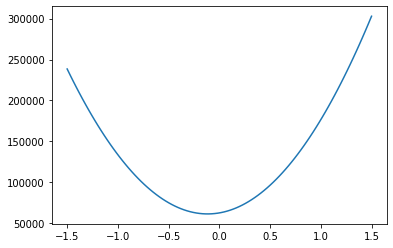

In [29]:
fig, ax = plt.subplots()
ax.plot(x,ML)

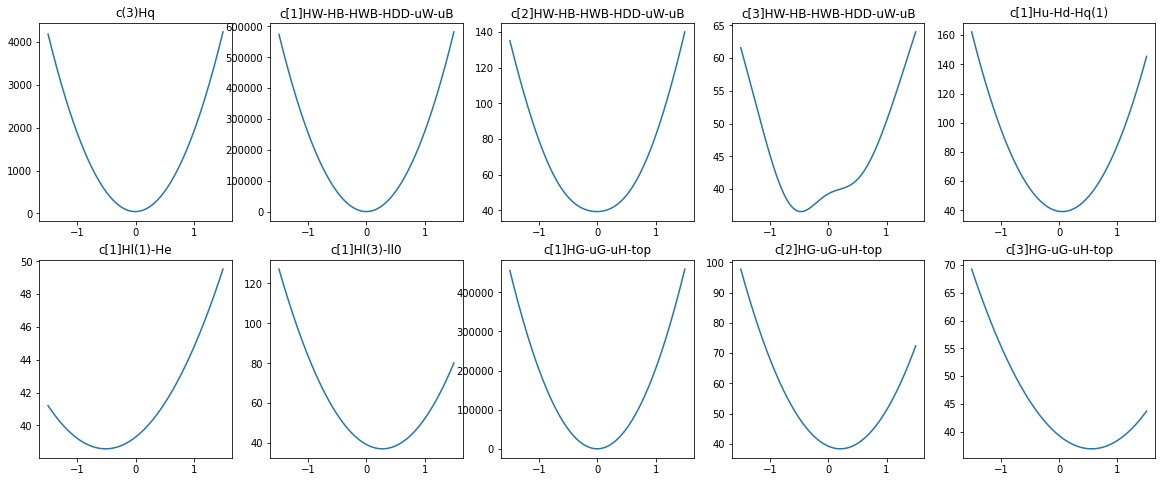

In [23]:
x = np.linspace(-1.5,1.5,200)
fig, axes = plt.subplots(ncols=5,nrows=2, figsize = (20,8))
count = 1
for N,ax in enumerate(axes.flatten()):
 X = np.zeros((200,10))
 X[:,N] = x
 temp = l(pd.DataFrame(X,columns= mat.index), type=2)[:,0,0]
 ax.plot(x,temp, label = f'loop {count}')
 ax.set_title(mat.index[N])
count+=1
X = np.zeros((200,10))
plt.savefig('validation/ATLAS-CONF-2020-053/rotated_parameter_guess.pdf',bbox_inches='tight')

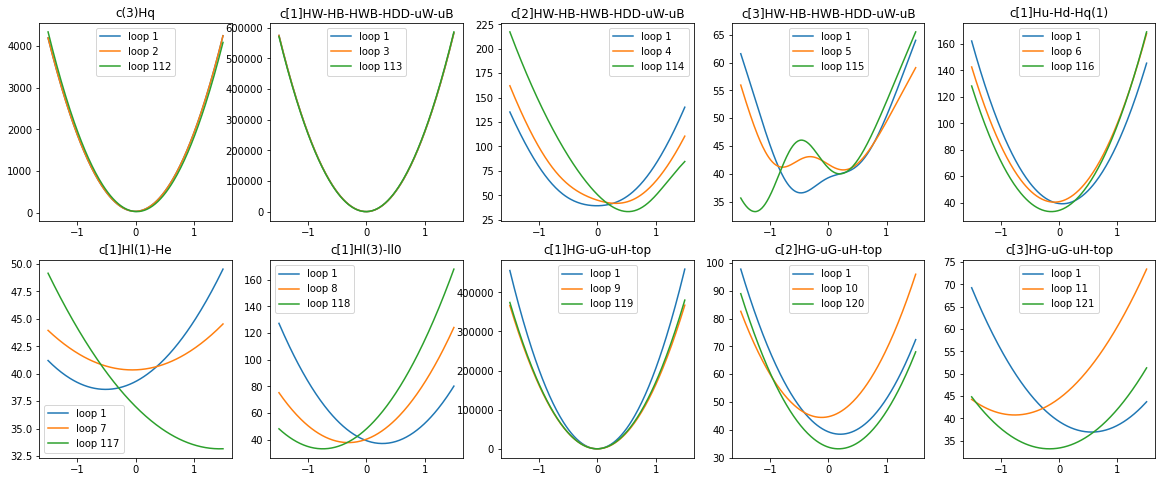

In [26]:

x = np.linspace(-1.5,1.5,200)
fig, axes = plt.subplots(ncols=5,nrows=2, figsize = (20,8))
count = 1
for N,ax in enumerate(axes.flatten()):
 X = np.zeros((200,10))
 X[:,N] = x
 temp = l(pd.DataFrame(X,columns= mat.index))[:,0,0]
 ax.plot(x,temp, label = f'loop {count}')
 ax.set_title(mat.index[N])
count+=1
X = np.zeros((200,10))
for N,ax in enumerate(axes.flatten()):
 X[:,N] = x
 temp = l(pd.DataFrame(X,columns= mat.index))[:,0,0]
 ax.plot(x,temp, label = f'loop {count}')
 X[:,N] = x[temp.argmin()]
 ax.legend()
 count+=1
for i in range (10):
 for N,ax in enumerate(axes.flatten()):
  X[:,N] = x
  temp = l(pd.DataFrame(X,columns= mat.index))[:,0,0]
  X[:,N] = x[temp.argmin()]
  count+=1
for N,ax in enumerate(axes.flatten()):
 X[:,N] = x
 temp = l(pd.DataFrame(X,columns= mat.index))[:,0,0]
 ax.plot(x,temp, label = f'loop {count}')
 X[:,N] = x[temp.argmin()]
 ax.legend()
 count+=1


In [81]:
temp.min()

26.56601377917974

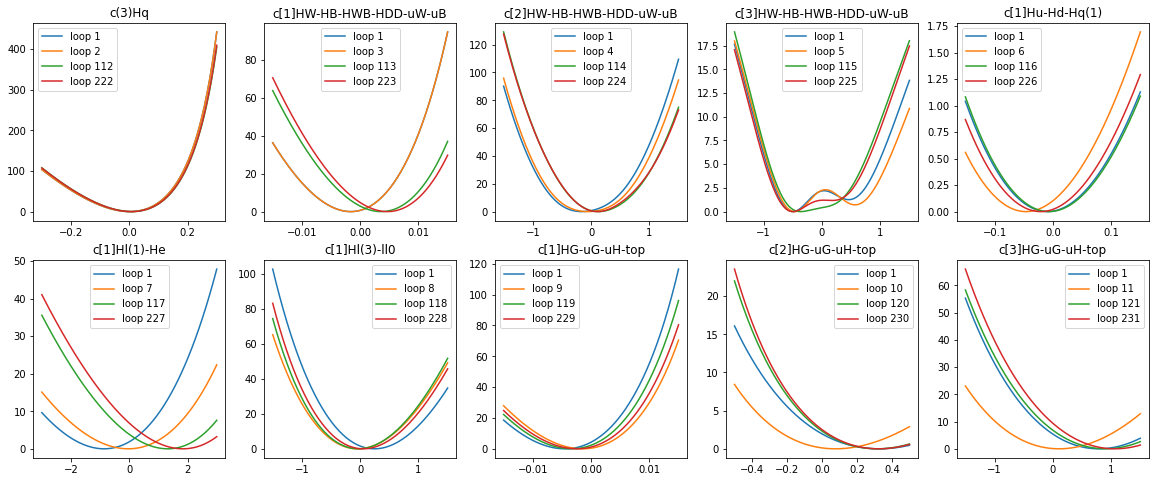

In [82]:
norm = np.array([5,100,1,1,10,0.5,1,100,3,1])
x = np.tile(np.linspace(-1.5,1.5,200),(10,1))/norm.reshape(-1,1)
fig, axes = plt.subplots(ncols=5,nrows=2, figsize = (20,8))
count = 1
for N,ax in enumerate(axes.flatten()):
 X = np.zeros((200,10))
 X[:,N] = x[N]
 temp = l(pd.DataFrame(X,columns= mat.index))[:,0,0]
 ax.plot(x[N],temp-temp.min(), label = f'loop {count}')
 ax.set_title(mat.index[N])
count+=1
X = np.zeros((200,10))
for N,ax in enumerate(axes.flatten()):
 X[:,N] = x[N]
 temp = l(pd.DataFrame(X,columns= mat.index))[:,0,0]
 ax.plot(x[N],temp-temp.min(), label = f'loop {count}')
 X[:,N] = x[N][temp.argmin()]
 ax.legend()
 count+=1
for i in range (10):
 for N,ax in enumerate(axes.flatten()):
  X[:,N] = x[N]
  temp = l(pd.DataFrame(X,columns= mat.index))[:,0,0]
  X[:,N] = x[N][temp.argmin()]
  count+=1
for N,ax in enumerate(axes.flatten()):
 X[:,N] = x[N]
 temp = l(pd.DataFrame(X,columns= mat.index))[:,0,0]
 ax.plot(x[N],temp-temp.min(), label = f'loop {count}')
 X[:,N] = x[N][temp.argmin()]
 ax.legend()
 count+=1
for i in range (10):
 for N,ax in enumerate(axes.flatten()):
  X[:,N] = x[N]
  temp = l(pd.DataFrame(X,columns= mat.index))[:,0,0]
  X[:,N] = x[N][temp.argmin()]
  count+=1
for N,ax in enumerate(axes.flatten()):
 X[:,N] = x[N]
 temp = l(pd.DataFrame(X,columns= mat.index))[:,0,0]
 ax.plot(x[N],temp-temp.min(), label = f'loop {count}')
 X[:,N] = x[N][temp.argmin()]
 ax.legend()
 count+=1
plt.savefig('validation/ATLAS-CONF-2020-053/likelihood.pdf')

In [ ]:
X = np.zeros((100,10))
x = np.linspace(-1,1,100)
X[:,0] = x

fig, ax = plt.subplots()
ax.plot(x,l(pd.DataFrame(X,columns= mat.index))[:,0,0])

In [179]:
decay_ga =decay[0:1]
decay_Z =decay[1:2]
decay_b =decay[2:3]
decay_H =decay[3:4]
linearized = prod2+(pd.concat([pd.concat([decay_ga]*26),pd.concat([decay_Z]*12),pd.concat([decay_b]*5)],axis =0, ignore_index= True).drop(columns= 'production_').to_numpy())-decay_H.drop(columns= 'production_').to_numpy()

In [ ]:
sig = (ob.to_numpy()[:,[2]]*np.abs(ob.to_numpy()[:,[1]])+(ob.to_numpy()[:,[2]]-np.abs(ob.to_numpy()[:,[1]]))*(1-ob.to_numpy()[:,[0]]))**(1/2)
cov = sig.dot(sig.T)*(cor)
# cov = np.absolute(ob[:,1:3]/2).sum(axis=1,keepdims=True).T*np.absolute(ob[:,1:3]/2).sum(axis=1,keepdims=True)*cor.to_numpy()
# val= (np.linalg.eig(linearized.T.dot(np.linalg.inv(cov).dot(linearized))))[0]
# vec = (np.linalg.eig(linearized.T.dot(np.linalg.inv(cov).dot(linearized))))[1]
val= (np.linalg.eig(linearized.iloc[:].T.dot(np.linalg.inv(cov).dot(linearized.iloc[:]))))[0]
vec = (np.linalg.eig(linearized.iloc[:].T.dot(np.linalg.inv(cov).dot(linearized.iloc[:]))))[1]
df = pd.DataFrame(np.real(vec).T,columns=linearized.columns).set_axis(np.real(val))
df.index.name= 'eigen value'
df = df.loc[:,linearized.columns]
temp=['c(3)Hq', 'cHB', 'cHW', 'cHWB', 'cuB', 'cuW', 'cHDD', 'cHd', 'cHu' ,'c(1)Hq', 'cHe' ,'c(1)Hl' ,'c(3)Hl', 'c0ll', 'cHG', 'cuG', 'cG' ,'c(8)qd' ,'c(1)qq', 'cqq' ,'c(3)qq' ,'c(31)qq' ,'c(1)qu' ,'c(8)qu', 'cuH' ,'c(8)ud', 'cuu' ,'c(1)uu', 'cHbox', 'cdH', 'cW', 'ceH']
temp.extend(list(np.setdiff1d(linearized.columns,temp)))
df.index += np.vectorize(lambda x:0.00000001 if x else 0.)(df.index.duplicated())
style = df\
.iloc[:].loc[:,temp].round(2).style.background_gradient( vmin=-1, vmax=1,cmap='PuOr').\
format(lambda x: '' if x==0 else x)\
.set_table_styles([{'selector': 'table', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})\
.set_table_styles([{'selector': 'th', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})\
.format_index(precision = 2)
# style.to_html('validation/ATLAS-CONF-2020-053/latex/eigen_vectors.html')
style

In [104]:
style = df\
.iloc[:12].loc[:,temp].round(2).style.background_gradient( vmin=-1, vmax=1,cmap='PuOr').\
format(lambda x: '' if x==0 else x)\
.set_table_styles([{'selector': 'table', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})\
.set_table_styles([{'selector': 'th', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})\
.format_index(precision = 2)
style.to_html('validation/ATLAS-CONF-2020-053/latex/eigen_vectors_partial.html')
style

,c(3)Hq,cHB,cHW,cHWB,cuB,cuW,cHDD,cHd,cHu,c(1)Hq,cHe,c(1)Hl,c(3)Hl,c0ll,cHG,cuG,cG,c(8)qd,c(1)qq,cqq,c(3)qq,c(31)qq,c(1)qu,c(8)qu,cuH,c(8)ud,cuu,c(1)uu,cHbox,cdH,cW,ceH,c(1)qd,c(1)ud
eigen value,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
324696.20,,-0.65,-0.21,0.36,-0.03,-0.02,,,,,,,-0.01,,0.64,0.02,,,,,,,,,,,,,,,-0.02,,,
128654.68,-0.01,0.54,0.17,-0.3,0.03,0.02,,,,,,,,,0.77,0.03,,,,,,,,,,,,,,,0.01,,,
1901.40,0.99,-0.01,0.1,0.02,,,,-0.03,0.09,-0.04,,,-0.02,0.02,,0.01,,,,,,,,,,,,,0.01,,,,,
34.61,0.1,-0.09,0.03,-0.14,,,-0.02,0.26,-0.85,0.4,0.02,0.02,0.05,-0.04,,-0.08,,,0.01,,,0.01,,,-0.02,,,0.01,-0.03,,,,,
19.06,0.01,0.1,-0.18,0.06,0.01,-0.01,0.01,-0.01,0.03,-0.02,-0.07,0.09,-0.15,0.11,0.02,-0.67,0.17,0.03,0.22,0.03,0.05,0.52,0.01,0.15,-0.08,0.04,0.02,0.23,0.09,0.06,0.01,,,
8.86,0.08,-0.01,-0.56,-0.33,-0.01,-0.01,-0.02,-0.03,0.07,-0.08,0.13,-0.13,0.56,-0.4,0.01,-0.06,0.02,,0.02,,,0.06,,0.02,-0.02,,,0.03,-0.2,-0.08,,-0.01,,
5.54,-0.07,-0.23,0.74,0.01,-0.03,-0.02,-0.04,-0.02,0.08,-0.01,0.1,-0.15,0.42,-0.24,0.01,-0.12,0.09,0.02,0.1,0.02,0.02,0.23,,0.07,-0.01,0.02,0.01,0.1,-0.06,-0.11,-0.01,,,
1.24,0.01,0.03,-0.09,,,,0.02,0.02,-0.05,0.02,,-0.01,-0.08,0.03,-0.03,0.7,0.28,0.03,0.23,0.04,0.04,0.51,0.01,0.15,0.08,0.03,0.02,0.24,-0.01,,,,,
0.23,-0.02,-0.41,0.06,-0.71,-0.02,-0.01,-0.11,-0.04,0.01,-0.26,0.19,-0.04,-0.41,0.08,,-0.06,0.06,,0.01,,,,,,0.09,,,0.01,0.03,-0.15,-0.01,,,


In [ ]:
linearized\
.round(2).style.\
format(lambda x: '' if x==0 else x)\
.set_table_styles([{'selector': 'table', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})\
.set_table_styles([{'selector': 'th', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})\
.format_index(precision=2)

In [108]:
def sub_vec(columns, threshold_value =0.2):
 val= (np.linalg.eig(linearized.loc[:,columns].T.dot(np.linalg.inv(cov).dot(linearized.loc[:,columns]))))[0]
 vec = (np.linalg.eig(linearized.loc[:,columns].T.dot(np.linalg.inv(cov).dot(linearized.loc[:,columns]))))[1]
 df = pd.DataFrame(np.real(vec).T,columns=columns).set_axis(np.real(val))
 return df[val>threshold_value]
df = pd.concat([
    sub_vec(['c(3)Hq'],0),
    sub_vec(['cHB','cHW','cHWB','cuB','cuW','cHDD'],0),
    sub_vec(['cHd', 'cHu','c(1)Hq'],0),
    sub_vec(['cHe','c(1)Hl'],0),
    sub_vec([ 'c(3)Hl', 'c0ll'],0),
    sub_vec([ 'cHG', 'cuG', 'cG','c(8)qd', 'c(1)qq', 'cqq', 'c(3)qq', 'c(31)qq', 'c(1)qu', 'c(8)qu','cuH', 'c(8)ud', 'cuu', 'c(1)uu'],0),
])
df.index.name='eigen value of subspace'
df.round(2).style.background_gradient( vmin=-1, vmax=1,cmap='PuOr')\
.format(lambda x: '' if x==0 else x)\
.set_table_styles([{'selector': 'table', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})\
.set_table_styles([{'selector': 'th', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})\
.format_index(precision=2).format(na_rep='', precision = 2)\
# .to_html('validation/ATLAS-CONF-2020-053/latex/sub_vectors.html')

,c(3)Hq,cHB,cHW,cHWB,cuB,cuW,cHDD,cHd,cHu,c(1)Hq,cHe,c(1)Hl,c(3)Hl,c0ll,cHG,cuG,cG,c(8)qd,c(1)qq,cqq,c(3)qq,c(31)qq,c(1)qu,c(8)qu,cuH,c(8)ud,cuu,c(1)uu
eigen value of subspace,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1866.39,1.00,,,,,,,,,,,,,,,,,,,,,,,,,,,
244941.79,,0.84,0.27,-0.47,0.05,0.02,0.00,,,,,,,,,,,,,,,,,,,,,
31.01,,-0.22,0.96,0.16,-0.02,-0.01,-0.01,,,,,,,,,,,,,,,,,,,,,
3.94,,-0.49,0.03,-0.87,-0.07,-0.04,-0.07,,,,,,,,,,,,,,,,,,,,,
0.00,,0.07,-0.01,0.04,-0.90,0.31,-0.31,,,,,,,,,,,,,,,,,,,,,
0.01,,-0.06,0.01,-0.05,0.14,0.88,0.45,,,,,,,,,,,,,,,,,,,,,
0.02,,0.01,0.01,-0.02,-0.41,-0.36,0.83,,,,,,,,,,,,,,,,,,,,,
51.13,,,,,,,,0.27,-0.87,0.41,,,,,,,,,,,,,,,,,,
0.00,,,,,,,,-0.96,-0.24,0.11,,,,,,,,,,,,,,,,,,


In [168]:
df = pd.concat([
    sub_vec(['c(3)Hq'],0.4),
    sub_vec(['cHB','cHW','cHWB','cuB','cuW','cHDD'],0.4),
    sub_vec(['cHd', 'cHu','c(1)Hq'],0.4),
    sub_vec(['cHe','c(1)Hl'],0.4),
    sub_vec([ 'c(3)Hl', 'c0ll'],0.4),
    sub_vec([ 'cHG', 'cuG', 'cG','c(8)qd', 'c(1)qq', 'cqq', 'c(3)qq', 'c(31)qq', 'c(1)qu', 'c(8)qu','cuH', 'c(8)ud', 'cuu', 'c(1)uu'],0.4),
])
df.index.name='eigen value of subspace'
style = df.round(2).style.background_gradient( vmin=-1, vmax=1,cmap='PuOr')\
.format(lambda x: '' if x==0 else x)\
.set_table_styles([{'selector': 'table', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})\
.set_table_styles([{'selector': 'th', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})\
.format_index(precision=2).format(na_rep='', precision = 2)
style.to_html('validation/ATLAS-CONF-2020-053/latex/sub_vectors_partial.html')
style

,c(3)Hq,cHB,cHW,cHWB,cuB,cuW,cHDD,cHd,cHu,c(1)Hq,cHe,c(1)Hl,c(3)Hl,c0ll,cHG,cuG,cG,c(8)qd,c(1)qq,cqq,c(3)qq,c(31)qq,c(1)qu,c(8)qu,cuH,c(8)ud,cuu,c(1)uu
eigen value of subspace,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1866.39,1.00,,,,,,,,,,,,,,,,,,,,,,,,,,,
244941.79,,0.84,0.27,-0.47,0.05,0.02,0.00,,,,,,,,,,,,,,,,,,,,,
31.01,,-0.22,0.96,0.16,-0.02,-0.01,-0.01,,,,,,,,,,,,,,,,,,,,,
3.94,,-0.49,0.03,-0.87,-0.07,-0.04,-0.07,,,,,,,,,,,,,,,,,,,,,
51.13,,,,,,,,0.27,-0.87,0.41,,,,,,,,,,,,,,,,,,
2.88,,,,,,,,,,,0.62,-0.78,,,,,,,,,,,,,,,,
27.65,,,,,,,,,,,,,0.87,-0.50,,,,,,,,,,,,,,
208274.82,,,,,,,,,,,,,,,1.00,0.04,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00
19.95,,,,,,,,,,,,,,,-0.03,0.72,-0.18,-0.04,-0.23,-0.03,-0.05,-0.55,-0.01,-0.16,0.06,-0.04,-0.02,-0.24


In [136]:
for Ni,i in     enumerate([['c(3)Hq'],
    ['cHB','cHW','cHWB','cuB','cuW','cHDD'],
    ['cHd', 'cHu','c(1)Hq'],
    ['cHe','c(1)Hl'],
    [ 'c(3)Hl', 'c0ll'],
    [ 'cHG', 'cuG', 'cG','c(8)qd', 'c(1)qq', 'cqq', 'c(3)qq', 'c(31)qq', 'c(1)qu', 'c(8)qu','cuH', 'c(8)ud', 'cuu', 'c(1)uu']]):
 df=sub_vec(i,0)
 df.index.name='eigen value of subspace'
 df.round(2).style.background_gradient( vmin=-1, vmax=1,cmap='PuOr')\
 .format(lambda x: '' if x==0 else x)\
 .set_table_styles([{'selector': 'table', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})\
 .set_table_styles([{'selector': 'th', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})\
 .format_index(precision=2).format(na_rep='', precision = 2)\
 # .to_html(f'validation/ATLAS-CONF-2020-053/latex/sub_vectors_{Ni}.html')

In [114]:
# def expand_inv()
# m,n = temp.shape
# temp = np.pad(temp,[(0,n-m),(0,0)])
# for i in range(m,n):
#   temp[i,i] = 1
# np.linalg.inv(temp)
# ls[0]

,c(3)Hq
1866.39304,1.0


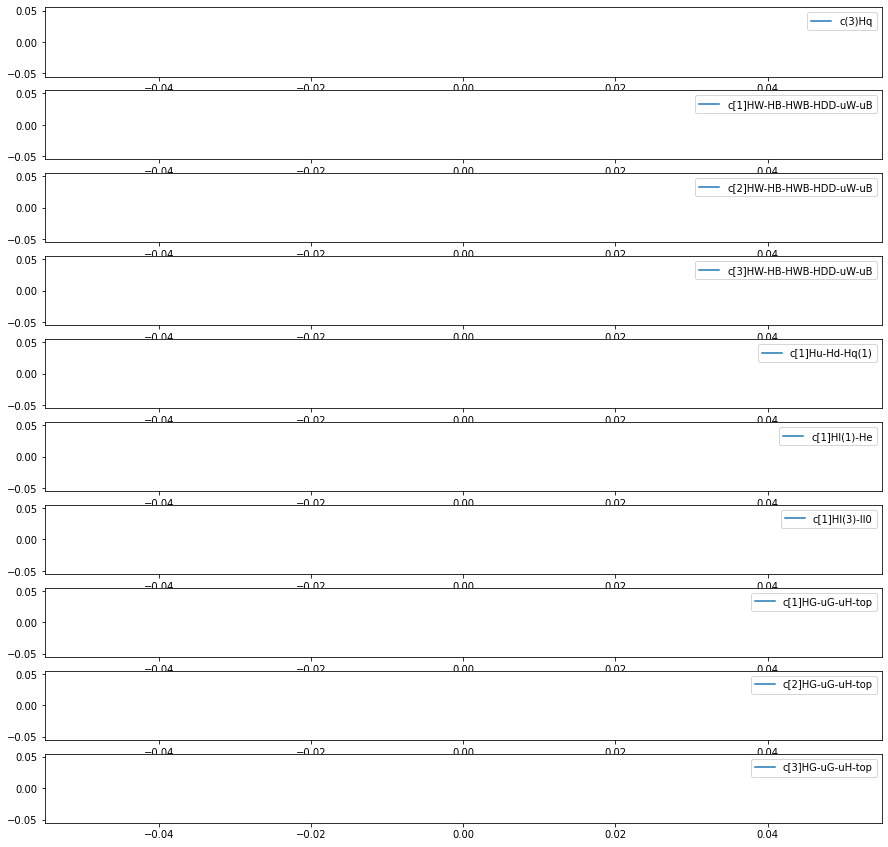

In [182]:
vec = np.zeros((1,10))
vec0 = np.zeros((1,10))
fig, axes = plt.subplots(nrows=10, ncols=1,  figsize=(15, 15))
for i,ax in enumerate(axes):
    grid = np.zeros((2000,10))
    vecspan = np.linspace(-span[i],span[i],2000)
    grid[:,i]= vecspan
    temp = l(pd.DataFrame(grid,columns= mat.index))
    ax.plot(vecspan,temp[:,0]-temp.min(),label=mat.index[i])
    ax.legend()

In [181]:
def calculate_gamma(unc, opt =0):
    if opt == 0:
        def func(x):
            return (1-x*unc[:,0:1])/(1+x*unc[:,1:2])-np.exp(-x*(unc[:,0:1]+unc[:,1:2]))
        def grad(x):
            return np.exp(-x*(unc[:,0:1]+unc[:,1:2]))*(unc[:,0:1]+unc[:,1:2])*(-np.exp(x*(unc[:,0:1]+unc[:,1:2]))+(1+x*unc[:,1:2])**2)/(1+x*unc[:,1:2])**2
        x=1/unc[:,0:1]
        for i in range(30):
            x = x-0.5*func(x)/grad(x)
        return x
    if opt == 1:
        def func(x,unc ):
            return ((1-x*unc[0])/(1+x*unc[1])-np.exp(-x*(unc[0]+unc[1])))
        return np.vectorize(lambda x:fsolve(func , 1/x[0],args=x),signature='(2)->(1)')(unc)
    if opt == 2:
        def func(x, unc):
            return ((1-x*unc[0])/(1+x*unc[1])-np.exp(-x*(unc[0]+unc[1])))
        return np.array([fsolve(func , 1/i[0],i) for i in unc])
def calculate_nu(gamma,unc):
    return 1/(2*(gamma*unc[:,1:2]-np.log(1+gamma*unc[:,1:2])))
def likelihood_poisson(mu,muhat,ga,nu):
    return -nu*ga*(mu-muhat)+nu*np.log(np.maximum(0.0001,1+ga*(mu-muhat)))

decay_ga =decay3[0:1]
decay_Z =decay3[1:2]
decay_b =decay3[2:3]
decay_H =decay3[3:4]
linearized = prod3+(pd.concat([pd.concat([decay_ga]*26),pd.concat([decay_Z]*12),pd.concat([decay_b]*5)],axis =0, ignore_index= True))-decay_H.to_numpy()
def l(C_df):
 temp = (C_df.loc[:,mat.index]).dot(mat)
 # C_df =pd.DataFrame(np.zeros((1,10)),columns = mat.index)
 y = (1+function.multiply(linearized,C_df))
 y_acceptance= y*np.concatenate((np.ones((C_df.shape[0],26,1)),
                np.tile(calculate_A(temp),(12,1)),
                np.ones((C_df.shape[0],5,1))),axis=1)
 unc = ob.iloc[:,1:3].abs().to_numpy()
 muhat = ob.iloc[:,0:1].to_numpy()
 ga = calculate_gamma(unc)
 nu = calculate_nu(ga,unc)
 return -2*likelihood_poisson(y_acceptance,muhat,ga,nu).sum(axis=1,keepdims=True)


NameError: name 'span' is not defined

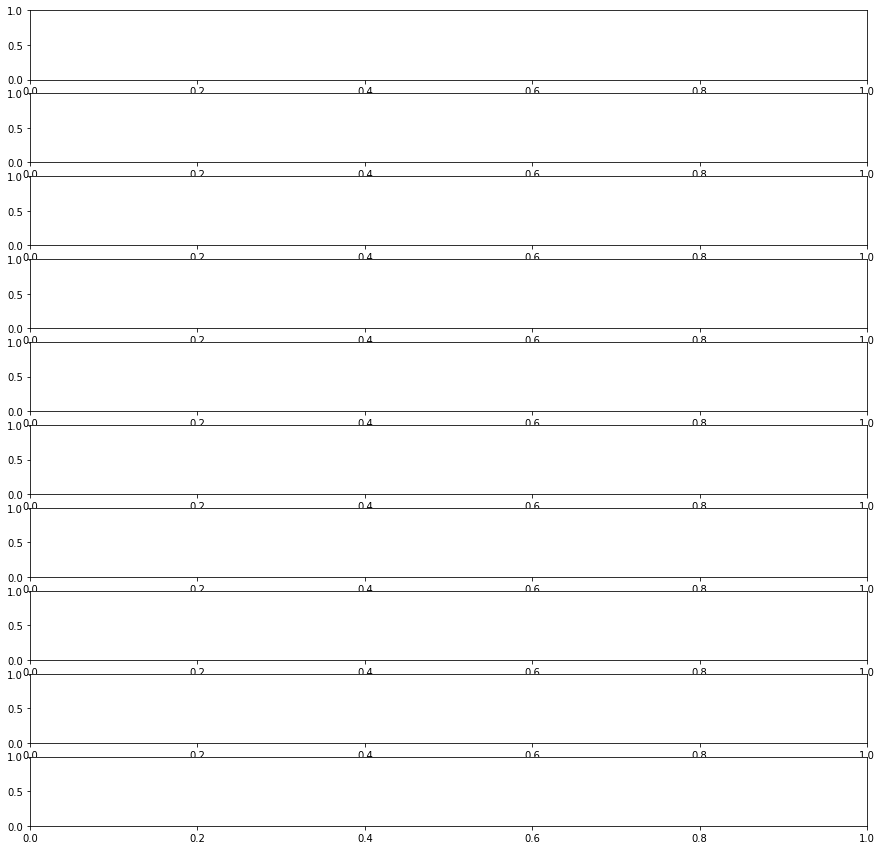

In [138]:
vec = np.zeros((1,10))
vec0 = np.zeros((1,10))
fig, axes = plt.subplots(nrows=10, ncols=1,  figsize=(15, 15))
for i,ax in enumerate(axes):
    grid = np.zeros((2000,10))
    vecspan = np.linspace(-span[i],span[i],2000)
    grid[:,i]= vecspan
    temp = l(pd.DataFrame(grid,columns= mat.index))
    ax.plot(vecspan,temp[:,0]-temp.min(),label=mat.index[i])
    ax.legend()

In [195]:
def lfunc(x):
 return l(pd.DataFrame(x.reshape(1,-1),columns= mat.index))[0,0,0]

In [161]:
minimize(lfunc, np.zeros(10), method='BFGS', tol=0.1).x

      fun: 25.2469078689743
 hess_inv: array([[ 1.90678071e-03, -1.58392591e-05,  1.06034876e-02,
         2.16311872e-02,  6.29887218e-03, -1.88745531e-01,
         4.94434947e-03, -3.92999525e-05,  1.33917316e-03,
         5.64771487e-04],
       [-1.58392591e-05,  1.45646651e-04, -2.74055912e-03,
         3.15922313e-03, -1.12309111e-04,  2.51293512e-02,
         1.06679600e-02, -3.82086512e-05,  1.68203870e-03,
         5.27658937e-04],
       [ 1.06034876e-02, -2.74055912e-03,  1.33758236e-01,
         1.12479517e-02,  2.12497118e-02, -1.27254824e+00,
        -1.73972935e-01,  3.32555887e-04, -1.52930753e-02,
         7.95764236e-04],
       [ 2.16311872e-02,  3.15922313e-03,  1.12479517e-02,
         1.04593457e+00,  2.00863799e-01, -6.14061144e+00,
         3.72222168e-01, -1.43507165e-03,  2.39903614e-02,
        -3.09911837e-02],
       [ 6.29887218e-03, -1.12309111e-04,  2.12497118e-02,
         2.00863799e-01,  5.75986201e-02, -1.43657484e+00,
         1.86861010e-02,  1.469

In [12]:
minimize(lfunc, np.zeros(10), method='L-BFGS-B')

      fun: 25.24765391302792
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.02022844, -0.0173344 , -0.00269686,  0.02529639,  0.0174829 ,
       -0.00090878,  0.00391367,  0.01618616,  0.00308553,  0.01788152])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 8272
      nit: 662
     njev: 752
   status: 0
  success: True
        x: array([-2.17225445e-02,  2.60562768e-02, -4.99358184e-01, -4.64179113e-01,
       -1.25646220e-01,  8.93843445e+00,  1.29351934e+00, -5.45910436e-03,
        5.15223780e-01,  1.15826657e+00])

In [165]:
def lfunc(x, index, value):
 return l(pd.DataFrame(np.insert(x,index,value).reshape(1,-1),columns= mat.index))[0,0,0]
vec= []
for i in np.linspace(-0.2,0.15,20):
 vec.append(minimize(lfunc, np.zeros(9),args=(0,i), method='BFGS', tol=0.1).x)

In [189]:
np.concatenate((np.linspace(-0.2,0.15,20).reshape(-1,1),np.concatenate(vec).reshape(-1,9)), axis= 1)

array([[-2.00000000e-01,  1.94888624e-02, -1.38373850e+00,
        -3.25424285e+00, -8.05131145e-01,  3.14324371e+01,
         1.79557645e-01,  6.39618573e-05,  2.62397428e-01,
         9.40874400e-01],
       [-1.81578947e-01,  2.03046527e-02, -1.29691130e+00,
        -2.92354084e+00, -7.35528646e-01,  2.98089139e+01,
         3.10685676e-01, -5.20923266e-04,  2.90073374e-01,
         9.61727273e-01],
       [-1.63157895e-01,  2.11137152e-02, -1.20911740e+00,
        -2.60563754e+00, -6.65987467e-01,  2.79749112e+01,
         4.39886177e-01, -1.10936804e-03,  3.17898427e-01,
         9.82937236e-01],
       [-1.44736842e-01,  2.19089844e-02, -1.12061228e+00,
        -2.29881822e+00, -5.95782619e-01,  2.59120243e+01,
         5.66466885e-01, -1.70219971e-03,  3.45706658e-01,
         1.00415535e+00],
       [-1.26315789e-01,  2.27043591e-02, -1.03079107e+00,
        -2.00376841e+00, -5.25934287e-01,  2.36276036e+01,
         6.91671735e-01, -2.30010788e-03,  3.73924741e-01,
         1.

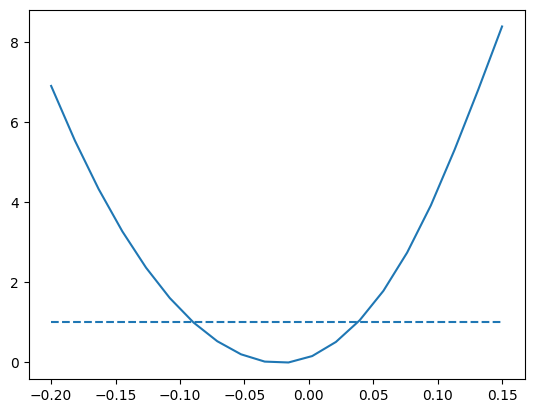

In [186]:
temp =l(pd.DataFrame(np.concatenate((np.linspace(-0.2,0.15,20).reshape(-1,1),np.concatenate(vec).reshape(-1,9)), axis= 1),columns=mat.index))
fig,ax= plt.subplots()
ax.plot( np.linspace(-0.2,0.15,20),temp[:,0]-temp.min(),label = mat.index[0])
ax.hlines(y=1,xmin=-0.2,xmax=0.15,linestyles='--')
# ax.plot( np.linspace(-0.2,0.15,20),pd.DataFrame(np.concatenate(vecj),columns= mat.index)['c[1]Hl(1)-He']-5.7799875,label = mat.index[0])
# ax.plot( np.linspace(-0.2,0.15,20),pd.DataFrame(np.concatenate(vecj),columns= mat.index)['c[1]HW-HB-HWB-HDD-uW-uB'],label = mat.index[0])

In [ ]:
vec1= []
for i in np.linspace(-4,4,20):
       vec1.append(minimize(lfunc, np.zeros(9),args=(9,i), method='BFGS', tol=0.1).x)
       

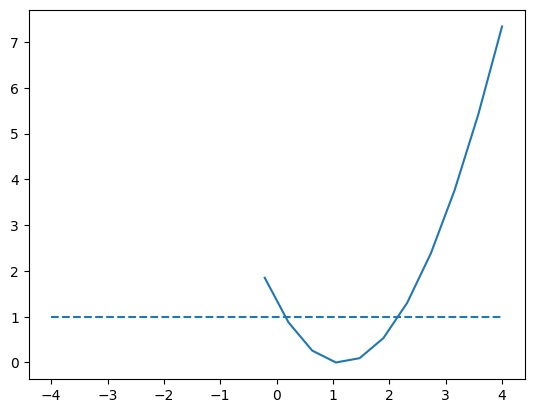

In [233]:
temp =l(pd.DataFrame(np.insert(np.concatenate(vec1).reshape(-1,9), [9],np.linspace(-4,4,20).reshape(-1,1),axis=1),columns=mat.index)[9:])
fig,ax= plt.subplots()
ax.plot( np.linspace(-4,4,20)[9:],temp[:,0]-temp.min(),label = mat.index[0])
ax.hlines(y=1,xmin=-4,xmax=4,linestyles='--')

In [236]:
vec1= []
for i in np.linspace(-8,4,20):
       vec1.append(minimize(lfunc, np.zeros(9),args=(3,i), method='BFGS', tol=0.1).x)

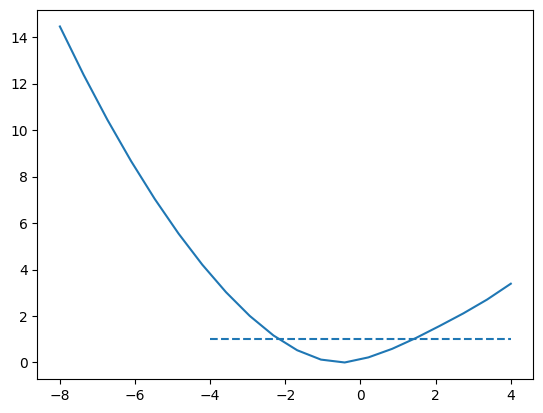

In [242]:
temp =l(pd.DataFrame(np.insert(np.concatenate(vec1).reshape(-1,9), [3],np.linspace(-8,4,20).reshape(-1,1),axis=1),columns=mat.index))
fig,ax= plt.subplots()
ax.plot( np.linspace(-8,4,20),temp[:,0]-temp.min(),label = mat.index[0])
ax.hlines(y=1,xmin=-4,xmax=4,linestyles='--')

# HIGG-2022-17

In [134]:
ob = pd.read_csv('data/HIGG-2022-17/observable.csv',index_col=[0,1,2,3,4], header = 0)
ob = ob.bfill(axis=1)
cor = pd.read_csv('data/HIGG-2022-17/correlation.csv',index_col=[0,1],header =[0,1])
cor_exp = pd.read_csv('data/HIGG-2022-17/correlation_expected.csv',index_col=[0,1],header =[0,1])
para = pd.read_csv('data/HIGG-2022-17/parametrization.csv',index_col=0, header = 0)
mat = pd.read_csv('data/HIGG-2022-17/rotate.csv',index_col=0)

In [38]:
# exp = 'HIGG-2022-17'
exp = 'ATLAS-CONF-2021-053'
ob = pd.read_csv(f'data/{exp}/observable.csv',index_col=[0,1,2,3], header = 0)
ob = ob.bfill(axis=1)
cor = pd.read_csv(f'data/{exp}/correlation.csv',index_col=[0,1],header =[0,1])
para = pd.read_csv(f'data/{exp}/parametrization.csv',index_col=[0], header = 0).fillna(0)
para.loc['none']=0
mat = pd.read_csv(f'data/{exp}/rotate.csv',index_col=0)

In [6]:
text = a.obs[:10].style.format_index(escape="latex", axis=1)\
      .format_index(escape="latex", axis=0)\
      .format(precision=2).to_latex( multicol_align = 't',
      column_format='l|l|l|l|c|c|c|c|c|c|c|c|c|c|c',
      clines='all;data',
      hrules= True).replace('production_','production\_')
text = re.sub(r'(cline{\d+-\d+}).*', r'\1', text)
text = re.sub(r'\\cline{\d+-\d+}\n\\bottomrule\n\\end{tabular}','\\\end{tabular}',text)
with open('report/obs_table.tex','w') as f:
  f.write(text)

In [64]:
Nls = []
Dls = []
gr = ob.groupby('signature')
for signature,df in gr:
  if signature == 'CS*BR/(CS_SM*BR_SM)':
    numerator =  para.loc[df.index.get_level_values('production')]
    numerator += para.loc[df.index.get_level_values('decay')].to_numpy()
    numerator += para.loc[df.index.get_level_values('acceptance')].to_numpy()
    denumerator = para.loc[['H->all']*df.shape[0]]
  if signature == 'BR/BR_ZZ':
    numerator =  para.loc[df.index.get_level_values('production')]
    numerator += para.loc[df.index.get_level_values('acceptance')].to_numpy()
    denumerator = para.loc[['H->ZZ->4l']*df.shape[0]]
  if signature == 'CS*BR_ZZ/BR_ZZSM':
    numerator =  para.loc[df.index.get_level_values('production')]
    numerator += para.loc[['H->ZZ->4l']].to_numpy()
    numerator += para.loc[df.index.get_level_values('acceptance')].to_numpy()
    numerator = numerator * df[['central']].to_numpy()
    denumerator = para.loc[['H->all']*df.shape[0]]
  numerator.index = df.index
  denumerator.index = df.index
  Nls.append(numerator)
  Dls.append(denumerator)

In [65]:
Ndf = pd.concat(Nls,axis=0)
Ddf = pd.concat(Dls,axis=0)
Ndf2 = Ndf[mat.columns].dot(mat.T)
Ddf2 = Ddf[mat.columns].dot(mat.T)


In [142]:
# A = linearized[mat.columns].dot(mat.T).copy()
# cov = cov_exp + cov_th
def l(C_df, type =2):
  if 'central_SM' in ob.columns:
    y = (ob[['central_SM']].to_numpy() * (1 + Ndf2[C_df.columns].dot(C_df.T).to_numpy())  / ( 1+ Ddf2[C_df.columns].dot(C_df.T).to_numpy()))
    y = y.T.reshape(C_df.shape[0],-1,1)
  else:
    y =  ((1 + Ndf2[C_df.columns].dot(C_df.T).to_numpy())  / ( 1+ Ddf2[C_df.columns].dot(C_df.T).to_numpy()))
    y = y.T.reshape(C_df.shape[0],-1,1)
  return function.likelihood(
    y = y
    ,yhat = ob[['central']]
    ,correlation_exp = cor
    ,uncertainty_exp = ob.loc[:,['+total','-total']]
    ,correlation_theo = (np.identity(ob.shape[0]) if '+total_SM' in ob.columns else None)
    ,uncertainty_theo = (ob[['+total_SM','-total_SM']].abs() if '+total_SM' in ob.columns else None)
    ,likelihood_type = type
    )
def dl(C_df, delta=1e-8):
  array = np.array(C_df)
  array = np.expand_dims(array , 1)
  array = array + np.identity(C_df.shape[1])*delta
  array = array.reshape(-1,C_df.shape[1])
  C_df2 = pd.DataFrame(array, columns=mat.index)
  return (l(C_df2).reshape(C_df.shape[0],-1,C_df.shape[1]) - l(C_df))/delta
def l2(array):
  return -l(pd.DataFrame(array.reshape(-1,mat.shape[0]), columns=mat.index) )[0,0]
def l3_scipy(array):
  return l(pd.DataFrame(array.reshape(1,-1), columns=mat.index) )[0,0,0]
def l3_scipy_profile(loc, val,likelihood_type = 0):
  return lambda array: l(pd.DataFrame(np.insert(array, loc, val).reshape(1,-1), columns=mat.index), type=likelihood_type)[0,0,0]
# l2(np.zeros((10,2)))
dl(pd.DataFrame(np.zeros((2,19)), columns=mat.index))

array([[[ 1.71036935e+02, -1.78903758e+02,  3.81643162e-01,
          4.08061823e+01,  3.59906550e+02, -1.14044376e+01,
          3.18315330e-01, -1.85870228e+02,  5.36354165e+01,
          1.37291565e+00,  8.41180352e+00, -6.33005470e-01,
          1.40282452e-02, -7.34495131e-02,  6.24021297e+00,
          1.23259980e-01, -1.38606282e-01,  5.06468680e+00,
          1.81940507e+00]],

       [[ 1.71036935e+02, -1.78903758e+02,  3.81643162e-01,
          4.08061823e+01,  3.59906550e+02, -1.14044376e+01,
          3.18315330e-01, -1.85870228e+02,  5.36354165e+01,
          1.37291565e+00,  8.41180352e+00, -6.33005470e-01,
          1.40282452e-02, -7.34495131e-02,  6.24021297e+00,
          1.23259980e-01, -1.38606282e-01,  5.06468680e+00,
          1.81940507e+00]]])

In [91]:
dl(pd.DataFrame(np.zeros((1,10)), columns=mat.index))
def dl2(array):
  return dl(pd.DataFrame(array.reshape(1,-1), columns=mat.index))[0,0]


array([  -17.49263239, -1195.18013   ,    -2.71550322,    -7.96131849,
           5.59531641,    -2.78124571,    15.68180799, -1223.90186739,
           8.45243454,     8.52124929])

In [155]:
linearized = Ndf- Ddf.to_numpy()
sig = ((ob[['+total']] + ob[['-total']].abs().to_numpy())/2).to_numpy()
cov = sig.dot(sig.T)*cor_exp
val, vec= (np.linalg.eig(linearized.T.dot(np.linalg.inv(cov).dot(linearized))))
df = pd.DataFrame(np.real(vec).T,columns=linearized.columns).set_axis(np.real(val))
df.index.name= 'eigen value'
df = df.loc[:,linearized.columns]
# temp=['c(3)Hq', 'cHB', 'cHW', 'cHWB', 'cuB', 'cuW', 'cHDD', 'cHd', 'cHu' ,'c(1)Hq', 'cHe' ,'c(1)Hl' ,'c(3)Hl', 'c0ll', 'cHG', 'cuG', 'cG' ,'c(8)qd' ,'c(1)qq', 'cqq' ,'c(3)qq' ,'c(31)qq' ,'c(1)qu' ,'c(8)qu', 'cuH' ,'c(8)ud', 'cuu' ,'c(1)uu', 'cHbox', 'cdH', 'cW', 'ceH']
# temp.extend(list(np.setdiff1d(linearized.columns,temp)))
df.index += df.index+np.vectorize(lambda x:0.00000001 if x else 0.)(df.index.duplicated())
df = df.loc[df.index>0.01]
style = df\
.round(2).style.background_gradient( vmin=-1, vmax=1,cmap='PuOr').\
format(lambda x: '' if x==0 else x)\
.set_table_styles([{'selector': 'table', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})\
.set_table_styles([{'selector': 'th', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})\
.format_index(precision=2)
# style.to_html('validation/ATLAS-CONF-2020-053/latex/eigen_vectors.html')
style

,"ceH,22","ceH,33",c(3)Hq,cbH,cHG,ctG,ctH,cHB,cHW,cHWB,ctB,ctW,cW,cHu,c(1)Hq,cHd,"c(3)Hl,33",cHt,"cHe,33","c(1)Hl,33",cHb,cG,"c(1,8)Qq","c(3,1)Qq",c(8)tq,c(8)Qu,c(8)tu,c(8)td,c(8)Qd,"c(3,8)Qq","c(1,1)Qq",c(1)tu,c(1)tq,c(1)Qu,c(1)Qd,cHbox,"c(3)Hl,11","c(3)Hl,22","cll,1221","c(1)Hl,11","c(1)Hl,22","cHe,11","cHe,22",cHDD,c(3)HQ,c(1)HQ,cH10
eigen value,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3677619.17,,-0.01,,-0.05,-0.53,0.02,,0.72,0.22,-0.4,-0.02,-0.01,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
321936.13,-0.13,-0.09,-0.01,0.05,0.84,-0.03,,0.44,0.13,-0.24,-0.01,-0.01,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
196672.81,-0.99,0.02,,,-0.11,,,-0.06,-0.02,0.03,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
17344.82,0.01,0.99,0.02,-0.13,0.08,,,0.05,0.01,-0.02,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4423.84,,-0.05,0.96,-0.25,0.02,,,-0.03,0.11,0.01,,,,0.07,-0.03,-0.02,,,,,,,,,,,,,,,,,,,,0.01,,,,,,,,,,,
1289.27,-0.01,-0.12,-0.27,-0.93,0.06,0.04,0.01,-0.12,0.14,-0.11,,-0.01,,-0.01,,,,,,,,,,,,,,,,,,,,,,-0.03,0.03,0.03,-0.03,-0.01,-0.01,0.01,0.01,,,,0.01
1092.21,,0.04,-0.03,0.23,-0.01,-0.01,,-0.47,0.69,-0.49,,-0.02,,-0.01,,,,,,,,,,,,,,,,,,,,,,0.01,,,,,,,,0.01,,,
51.77,,,-0.1,-0.01,-0.01,-0.36,-0.02,0.03,0.11,0.11,,,,0.81,-0.31,-0.25,0.01,-0.01,-0.01,-0.01,0.01,0.06,0.05,0.02,0.05,0.03,0.03,0.02,0.02,0.01,0.01,,,,,0.07,-0.04,-0.04,0.03,,,-0.01,-0.01,0.02,-0.02,,-0.03
42.73,,,0.03,-0.04,-0.02,-0.86,-0.11,-0.01,-0.04,-0.05,,-0.01,,-0.34,0.13,0.11,,0.01,,,,0.18,0.14,0.05,0.14,0.08,0.08,0.05,0.05,0.04,0.02,0.01,0.01,0.01,,0.07,0.01,0.01,,0.01,0.01,-0.01,-0.01,-0.01,0.01,,-0.08


In [165]:
def sub_vec(columns, threshold_value =0.2):
 val,vec = (np.linalg.eig(linearized.loc[:,columns].T.dot(np.linalg.inv(cov).dot(linearized.loc[:,columns]))))
 df = pd.DataFrame(np.real(vec).T,columns=columns).set_axis(np.real(val))
 return df[val>threshold_value]
df = pd.concat([
    sub_vec(['ceH,22'],0.01),
    sub_vec(['ceH,33'],0.01),
    sub_vec(['c(3)Hq'],0.01),
    sub_vec(['cbH'],0.02),
    sub_vec(['cHG', 'ctG', 'ctH'],0.02),
    sub_vec(['cHB', 'cHW','cHWB','ctB','ctW'],0.03),
    sub_vec(['cHu', 'c(1)Hq', 'cHd', 'c(3)Hl,33', 'cHt','cHe,33', 'c(1)Hl,33', 'cHb'],0.01),
    sub_vec(['cG', 'c(1,8)Qq', 'c(3,1)Qq', 'c(8)tq','c(8)Qu', 'c(8)tu', 'c(8)td', 'c(8)Qd', 'c(3,8)Qq', 'c(1,1)Qq','c(1)tu', 'c(1)tq', 'c(1)Qu', 'c(1)Qd'],0.005    ),
    sub_vec(['cHbox', 'c(3)Hl,11','c(3)Hl,22', 'cll,1221'],0.5),
    sub_vec(['c(1)Hl,11', 'c(1)Hl,22', 'cHe,11', 'cHe,22','cHDD', 'c(3)HQ', 'c(1)HQ'],0.5),
])
df.index.name='eigen value of subspace'
df.round(2).style.background_gradient( vmin=-1, vmax=1,cmap='PuOr')\
.format(lambda x: '' if x==0 else x)\
.set_table_styles([{'selector': 'table', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})\
.set_table_styles([{'selector': 'th', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})\
.format_index(precision=2).format(na_rep='', precision = 2).highlight_null(color="white")\
# .to_html('validation/ATLAS-CONF-2020-053/latex/sub_vectors.html')

,"ceH,22","ceH,33",c(3)Hq,cbH,cHG,ctG,ctH,cHB,cHW,cHWB,ctB,ctW,cHu,c(1)Hq,cHd,"c(3)Hl,33",cHt,"cHe,33","c(1)Hl,33",cHb,cG,"c(1,8)Qq","c(3,1)Qq",c(8)tq,c(8)Qu,c(8)tu,c(8)td,c(8)Qd,"c(3,8)Qq","c(1,1)Qq",c(1)tu,c(1)tq,c(1)Qu,c(1)Qd,cHbox,"c(3)Hl,11","c(3)Hl,22","cll,1221","c(1)Hl,11","c(1)Hl,22","cHe,11","cHe,22",cHDD,c(3)HQ,c(1)HQ
eigen value of subspace,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
99354.26,1.00,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9854.09,,1.00,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2080.04,,,1.00,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5455.86,,,,1.00,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
625074.91,,,,,1.00,-0.03,-0.00,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20.87,,,,,-0.03,-0.99,-0.11,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.15,,,,,-0.00,-0.11,0.99,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1367757.05,,,,,,,,-0.85,-0.25,0.47,0.02,0.01,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
566.44,,,,,,,,-0.49,0.73,-0.48,-0.00,-0.02,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [ ]:
cor.where(cor.abs() > 0.001).style.background_gradient( vmin=-1, vmax=1,cmap='PuOr').format_index(precision=2).format(na_rep='', precision = 2).highlight_null(color="white")

In [23]:
A = linearized.copy()
sig  = (ob.loc[:,['+total','-total']].abs().sum(axis =1)/2).to_numpy().reshape(-1,1)
# cov = sig.dot(sig.T)*(np.identity(78))
cov = sig.dot(sig.T)*(cor.to_numpy())
np.linalg.inv(cov)

array([[ 1.45258244e+01,  1.83770210e+00,  1.51351692e-01, ...,
        -3.13875631e-02, -5.71926559e-03, -4.66701928e-03],
       [ 1.83770210e+00,  3.74185244e+01,  3.99126539e+00, ...,
         1.27138593e-01,  3.27562235e-02,  1.94026350e-02],
       [ 1.51351692e-01,  3.99126539e+00,  7.76663325e+00, ...,
         8.86186215e-03,  4.69859256e-03,  2.88707881e-03],
       ...,
       [-3.13875631e-02,  1.27138593e-01,  8.86186215e-03, ...,
         1.51855565e+00,  2.92659696e-01, -3.89607669e-05],
       [-5.71926559e-03,  3.27562235e-02,  4.69859256e-03, ...,
         2.92659696e-01,  6.67541200e-01, -3.04816008e-05],
       [-4.66701928e-03,  1.94026350e-02,  2.88707881e-03, ...,
        -3.89607669e-05, -3.04816008e-05,  1.10899076e+00]])

In [ ]:
l_list = []
for i in mat.index:
   exp_df = pd.read_csv(f'validation/HIGG-2022-17/{i}.csv', index_col=None)
   fig, ax = plt.subplots( figsize=(6, 3))
   ax.plot(exp_df['x'],exp_df[' y'], '.', markersize=10)
   xrange = exp_df['x'].max() - exp_df['x'].min()
   xcenter = (exp_df['x'].max() + exp_df['x'].min())/2
   cs = np.linspace(xcenter-xrange*0.75,xcenter+xrange*0.75,20)
   l_list2 = []
   for ci in cs:
      ai = linearized[[i]].to_numpy()
      A = linearized.drop(columns = i).to_numpy()
      yhat = (ob.loc[:,['central']] - 1 - ai * ci).to_numpy()
      temp = np.linalg.inv(A.T.dot(np.linalg.inv(cov)).dot(A)).dot(A.T).dot(np.linalg.inv(cov)).dot(yhat)
      # temp = np.insert(temp, Ni, ci, axis =0)
      l_list2.append((yhat - A.dot(temp)).T.dot(np.linalg.inv(cov)).dot(yhat - A.dot(temp))[0,0])

   l_list.append(l_list2)
   ax.plot(cs , l_list[0] - min(l_list[0]))
   ax.hlines([1,3.84], xmin=xcenter-xrange*0.75,xmax=xcenter+xrange*0.75, linestyles ='-.',colors = 'k')
   ax.set_title(i)
   # ax.legend()
   plt.ylim([0,8])

In [ ]:
exp_df = pd.read_csv('validation/ATLAS-CONF-2021-053/2021-053.csv', index_col=0)
for i in mat.index:
   fig, ax = plt.subplots( figsize=(6, 3))
   ax.plot(exp_df.loc[i],[0,1,1,3.84,3.84], '.', markersize=12)
   l_list = []
   xrange = exp_df.loc[i].max() - exp_df.loc[i].min()
   xcenter = (exp_df.loc[i].max() + exp_df.loc[i].min())/2
   cs = np.linspace(xcenter-xrange*0.75,xcenter+xrange*0.75,20)
   for correction in [0,1]:
      l_list2 = []
      for ci in cs:
         ai = linearized[[i]].to_numpy()
         A = linearized.drop(columns = i).to_numpy()
         yhat = (ob.iloc[:,0:1] - ob[['σ_SM']].to_numpy() + delta*correction - ai * ci).to_numpy()
         temp = np.linalg.inv(A.T.dot(np.linalg.inv(cov)).dot(A)).dot(A.T).dot(np.linalg.inv(cov)).dot(yhat)
         # temp = np.insert(temp, Ni, ci, axis =0)
         l_list2.append((yhat - A.dot(temp)).T.dot(np.linalg.inv(cov)).dot(yhat - A.dot(temp))[0,0])
      l_list.append(l_list2)
   ax.plot(cs , l_list[0] - min(l_list[0]), label= 'no correction')
   ax.plot(cs , l_list[1] - min(l_list[1]),  label= 'yes correction')
   ax.hlines([1,3.84], xmin=exp_df.loc[i].min(),xmax=exp_df.loc[i].max(), linestyles ='-.',colors = 'k')
   ax.set_title(i)
   ax.legend()
   plt.ylim([0,8])

# tables

In [10]:
import Fiteft
importlib.reload(Fiteft)
a = Fiteft.fiteft(experiment='HIGG-2022-17')

Your input to the likelihood function is a DataFrame with at least one of these colums:
['ceH,22', 'ceH,33', 'c(3)Hq', 'cbH', 'e[1]ggF', 'e[2]ggF', 'e[3]ggF', 'e[1]Hgaga,Zga', 'e[2]Hgaga,Zga', 'e[3]Hgaga,Zga', 'e[1]ZH', 'e[2]ZH', 'e[3]ZH', 'e[4]ZH', 'e[1]ttH', 'e[2]ttH', 'e[3]ttH', 'e[1]glob', 'e[1]Hllll']


In [ ]:
A = (a.Ndf - a.Ddf.to_numpy()).to_numpy()
ysm = 1
yhat = a.obs[['central']].to_numpy()
rho = a.cor_exp.to_numpy()
Delta = (a.obs[['+total']]+a.obs[['-total']].abs().to_numpy()).to_numpy()/2
V = rho*Delta.dot(Delta.T)
array = -np.linalg.inv((ysm*A).T.dot(np.linalg.inv(V)).dot(A*ysm)).dot((ysm*A).T).dot(np.linalg.inv(V)).dot(ysm-yhat)
array

In [7]:
text = a.obs[:5][['central','+total','-total']].style.format_index(escape="latex", axis=1)\
      .format_index(escape="latex", axis=0)\
      .format(precision=2).to_latex( multicol_align = 't',
      column_format='l|l|l|l|c|c|c|c|c|c|c|c|c|c|c',
      clines='all;data',
      hrules= True).replace('production_','production\_')
text = re.sub(r'(cline{\d+-\d+}).*', r'\1', text)
text = re.sub(r'\\cline{\d+-\d+}\n\\bottomrule\n\\end{tabular}','\\\end{tabular}',text)
with open('report/obs_table0.tex','w') as f:
  f.write(text)

In [6]:
import Fiteft
importlib.reload(Fiteft)
a = Fiteft.fiteft(experiment='ATLAS-CONF-2021-053')

Your input to the likelihood function is a DataFrame with at least one of these colums:
['c(3)Hq', 'cdH', 'ceH', 'c[1]Hl(1)-He', 'c[1]Hl(3)-ll0', 'c[1]Hu-Hd-Hq(1)', 'c[2]Hu-Hd-Hq(1)', 'c[1]HW-HB-HWB-HDD-uW-uB-W', 'c[2]HW-HB-HWB-HDD-uW-uB-W', 'c[3]HW-HB-HWB-HDD-uW-uB-W', 'c[1]HG-uG-uH', 'c[2]HG-uG-uH', 'c[1]top']


In [9]:
text = a.obs[:10].style.format_index(escape="latex", axis=1)\
      .format_index(escape="latex", axis=0)\
      .format(precision=2).to_latex( multicol_align = 't',
      column_format='l|l|l|l|c|c|c|c|c|c|c|c|c|c|c',
      clines='all;data',
      hrules= True).replace('production_','production\_')
text = re.sub(r'(cline{\d+-\d+}).*', r'\1', text)
text = re.sub(r'\\cline{\d+-\d+}\n\\bottomrule\n\\end{tabular}','\\\end{tabular}',text)
with open('report/obs_table.tex','w') as f:
  f.write(text)

In [6]:
text = a.cor_exp.iloc[:10,:5].style.background_gradient( vmin=-1, vmax=1,cmap='PuOr')\
.format(lambda x: '' if x==0 else x).format_index(escape="latex", axis=1)\
      .format_index(escape="latex", axis=0)\
      .format(precision=2).to_latex( multicol_align = 't',
      column_format='l|l|c|c|c|c|c|c|c|c|c|c|c|c|c',
      clines='all;data',
      hrules= True,convert_css=True).replace('production_','production\_')
text = re.sub(r'(cline{\d+-\d+}).*', r'\1', text)
text = re.sub(r'\\cline{\d+-\d+}\n\\bottomrule\n\\end{tabular}','\\\end{tabular}',text)
with open('report/cor_exp_table.tex','w') as f:
  f.write(text)

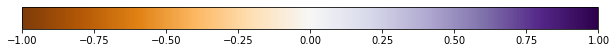

In [38]:
text = a.Adf.droplevel(['acceptance','signature']).style.background_gradient( vmin=-1, vmax=1,cmap='PuOr')\
.format(lambda x: '' if x==0 else x)\
.set_table_styles([{'selector': 'table', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})\
.set_table_styles([{'selector': 'th', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})\
.format_index(precision=2).format_index(escape="latex", axis=0).format(na_rep='', precision = 2).highlight_null(color="white")\
  .to_latex(hrules= True,convert_css=True).replace('production_','production\_').replace('\\thsolid','').replace('\\begin{table}','').replace('\\end{table}','')

with open('report/A_matrix_example.tex','w') as f:
  f.write(text)
temp = np.array([[-1,1]])
plt.figure(figsize=(10, 0.5))
img = plt.imshow(temp, cmap='PuOr')
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
plt.colorbar(orientation="horizontal", cax=cax)
plt.savefig("report/colorbar_A_matrix_example.pdf",bbox_inches='tight')

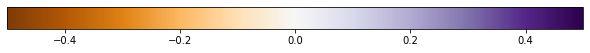

In [9]:
text = (a.Adf / a.Adf.abs().sum(axis=0)).droplevel(['acceptance','signature']).style.background_gradient( vmin=-0.5, vmax=0.5,cmap='PuOr')\
.format(lambda x: '' if x==0 else x)\
.set_table_styles([{'selector': 'table', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})\
.set_table_styles([{'selector': 'th', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})\
.format_index(precision=2).format_index(escape="latex", axis=0).format(na_rep='', precision = 2).highlight_null(color="white")\
  .to_latex(hrules= True,convert_css=True).replace('production_','production\_').replace('\\thsolid','').replace('\\begin{table}','').replace('\\end{table}','')

with open('report/A_matrix_example_nomalized.tex','w') as f:
  f.write(text)
temp = np.array([[-0.5,0.5]])
plt.figure(figsize=(10, 0.5))
img = plt.imshow(temp, cmap='PuOr')
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
plt.colorbar(orientation="horizontal", cax=cax)
plt.savefig("report/colorbar_A_matrix_example_nomalized.pdf",bbox_inches='tight')

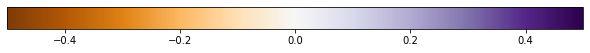

In [4]:
text = a.param.iloc[:,:15].style.background_gradient( vmin=-1, vmax=1,cmap='PuOr')\
.format(lambda x: '' if x==0 else x)\
.set_table_styles([{'selector': 'table', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})\
.set_table_styles([{'selector': 'th', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})\
.format_index(precision=2).format(na_rep='', precision = 2).highlight_null(color="white")\
  .to_latex(hrules= True,convert_css=True).replace('production_','production\_').replace('\\thsolid','').replace('\\begin{table}','').replace('\\end{table}','')

with open('report/param_table.tex','w') as f:
  f.write(text)
with open('report/A_matrix_example_nomalized.tex','w') as f:
  f.write(text)
temp = np.array([[-0.5,0.5]])
plt.figure(figsize=(10, 0.5))
img = plt.imshow(temp, cmap='PuOr')
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
plt.colorbar(orientation="horizontal", cax=cax)
plt.savefig("report/colorbar_param_example.pdf",bbox_inches='tight')

In [58]:
a = Fiteft.Fiteft(experiment='ATLAS-CONF-2020-053')
sig = (a.obs[['+total']]+a.obs[['+total']].abs()).to_numpy()/2
V = a.cor_exp*sig.dot(sig.T)
N = (a.Ndf - a.Ddf.to_numpy())
# val, vec = np.linalg.eig(N.T.dot(np.linalg.inv(V)).dot(N))

Your input to the likelihood function is a DataFrame with one of these colums:
['cHbox', 'cHDD', 'cHG', 'cuH', 'cuG', 'c(3)Hl', 'c0ll', 'cHWB', 'c(1)Hl', 'cHe', 'c(1)Hq', 'c(3)Hq', 'cHu', 'cHd', 'cHW', 'cHB', 'cG', 'cuW', 'cuB', 'cqq', 'c(1)qq', 'c(3)qq', 'c(31)qq', 'cuu', 'c(1)uu', 'c(1)ud', 'c(8)ud', 'c(1)qu', 'c(8)qu', 'c(1)qd', 'c(8)qd', 'cW', 'cdH', 'ceH']


In [51]:
df = N.T.dot(np.linalg.inv(V)).dot(N.reset_index(drop=True))
df = pd.DataFrame(np.linalg.inv(df), columns = df.columns,index = df.index)
style = df.where(np.identity(df.shape[0]).astype(bool)).abs().style.background_gradient( vmin=-1, vmax=1000,cmap='PuOr')\
.format('{:.0e}',na_rep='', precision = 2).highlight_null(color="white")\
.set_table_styles([{'selector': 'table', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})\
.set_table_styles([{'selector': 'th', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})
text = style.to_latex(hrules= True,convert_css=True).replace('production_','production\_').replace('\\thsolid','').replace('\\begin{table}','').replace('\\end{table}','')
with open('report/V_smeft_2020-053.tex','w') as f: f.write(text)

In [15]:
for exp in ['ATLAS-CONF-2020-053','ATLAS-CONF-2021-053','HIGG-2022-17']:
  a = Fiteft.fiteft(exp)
  text = a.Adf.droplevel(['acceptance','signature']).style.background_gradient( vmin=-1, vmax=1,cmap='PuOr')\
  .format(lambda x: '' if x==0 else x)\
  .set_table_styles([{'selector': 'table', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})\
  .set_table_styles([{'selector': 'th', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})\
  .format_index(precision=2).format_index(escape="latex", axis=0).format(na_rep='', precision = 2).highlight_null(color="white")\
    .to_latex(hrules= True,convert_css=True).replace('\\thsolid','').replace('\\begin{table}','').replace('\\end{table}','')

  with open(f'report/Adf_{exp}.tex','w') as f:
    f.write(text)

  text = a.obs.style.format_index(escape="latex", axis=1)\
        .format_index(escape="latex", axis=0)\
        .format(precision=2).to_latex( multicol_align = 't',
        column_format='l|l|l|l|c|c|c|c|c|c|c|c|c|c|c',
        clines='all;data',
        hrules= True).replace('production_','production\_')
  text = re.sub(r'(cline{\d+-\d+}).*', r'\1', text)
  text = re.sub(r'\\cline{\d+-\d+}\n\\bottomrule\n\\end{tabular}','\\\end{tabular}',text)
  with open(f'report/obs_table_{exp}.tex','w') as f:
    f.write(text)

  text = a.cor_exp.style.background_gradient( vmin=-1, vmax=1,cmap='PuOr')\
  .map_index(
    lambda v: "rotatebox:{90}--rwrap--latex;", level=[0,1], axis=1)\
  .format(lambda x: '' if x==0 else x)\
  .set_table_styles([{'selector': 'table', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})\
  .set_table_styles([{'selector': 'th', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})\
  .format_index(precision=2).format_index(escape="latex", axis=0).format(na_rep='', precision = 2).highlight_null(color="white")\
    .to_latex(hrules= True,convert_css=True).replace('\\thsolid','').replace('\\begin{table}','').replace('\\end{table}','')
  with open(f'report/cor_table_{exp}.tex','w') as f:
    f.write(text)

  text = a.rot.style.background_gradient( vmin=-1, vmax=1,cmap='PuOr')\
  .format(lambda x: '' if x==0 else x)\
  .set_table_styles([{'selector': 'table', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})\
  .set_table_styles([{'selector': 'th', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})\
  .format_index(precision=2).format_index(escape="latex", axis=0).format(na_rep='', precision = 2).highlight_null(color="white")\
    .to_latex(hrules= True,convert_css=True).replace('\\thsolid','').replace('\\begin{table}','').replace('\\end{table}','')
  with open(f'report/rot_table_{exp}.tex','w') as f:
    f.write(text)

Your input to the likelihood function is a DataFrame with one of these colums:
['c(3)Hq', 'c[1]HW-HB-HWB-HDD-uW-uB', 'c[2]HW-HB-HWB-HDD-uW-uB', 'c[3]HW-HB-HWB-HDD-uW-uB', 'c[1]Hu-Hd-Hq(1)', 'c[1]Hl(1)-He', 'c[1]Hl(3)-ll0', 'c[1]HG-uG-uH-top', 'c[2]HG-uG-uH-top', 'c[3]HG-uG-uH-top']


Your input to the likelihood function is a DataFrame with one of these colums:
['c(3)Hq', 'cdH', 'ceH', 'c[1]Hl(1)-He', 'c[1]Hl(3)-ll0', 'c[1]Hu-Hd-Hq(1)', 'c[2]Hu-Hd-Hq(1)', 'c[1]HW-HB-HWB-HDD-uW-uB-W', 'c[2]HW-HB-HWB-HDD-uW-uB-W', 'c[3]HW-HB-HWB-HDD-uW-uB-W', 'c[1]HG-uG-uH', 'c[2]HG-uG-uH', 'c[1]top']
Your input to the likelihood function is a DataFrame with one of these colums:
['ceH,22', 'ceH,33', 'c(3)Hq', 'cbH', 'e[1]ggF', 'e[2]ggF', 'e[3]ggF', 'e[1]Hgaga,Zga', 'e[2]Hgaga,Zga', 'e[3]Hgaga,Zga', 'e[1]ZH', 'e[2]ZH', 'e[3]ZH', 'e[4]ZH', 'e[1]ttH', 'e[2]ttH', 'e[3]ttH', 'e[1]glob', 'e[1]Hllll']


# rotation matrix

## 2020-053

In [3]:
import Fiteft
a = Fiteft.fiteft(experiment='ATLAS-CONF-2020-053')

Your input to the likelihood function is a DataFrame with at least one of these colums:
['c(3)Hq', 'c[1]HW-HB-HWB-HDD-uW-uB', 'c[2]HW-HB-HWB-HDD-uW-uB', 'c[3]HW-HB-HWB-HDD-uW-uB', 'c[1]Hu-Hd-Hq(1)', 'c[1]Hl(1)-He', 'c[1]Hl(3)-ll0', 'c[1]HG-uG-uH-top', 'c[2]HG-uG-uH-top', 'c[3]HG-uG-uH-top']


In [3]:
Delta = (a.obs[['+total']]+a.obs[['-total']].abs().to_numpy()).to_numpy()/2
V = a.cor_exp*Delta.dot(Delta.T)
V = pd.read_csv('data/ATLAS-CONF-2020-053/correlation_expected.csv', sep='\s+',index_col=None,header=None)
N = (a.Ndf - a.Ddf.to_numpy())
V_eft_inv = N.T.dot(np.linalg.inv(V)).dot(N.reset_index(drop=True))
V_eft = pd.DataFrame(np.linalg.inv(V_eft_inv), columns = V_eft_inv.columns,index = V_eft_inv.index)

In [81]:
val, vec= (np.linalg.eig(V_eft_inv))
df = pd.DataFrame(np.real(vec).T,columns=N.columns).set_axis(np.real(val))
df.index.name= 'eigen value'
df = df.loc[:,N.columns]
df.index += df.index+np.vectorize(lambda x:0.00000001 if x else 0.)(df.index.duplicated())
df = df.loc[df.index>0.01]
style = df\
.round(2).style.background_gradient( vmin=-1, vmax=1,cmap='PuOr').\
format(lambda x: '' if x==0 else x)\
.set_table_styles([{'selector': 'table', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})\
.set_table_styles([{'selector': 'th', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})\
.format_index(precision=2)
text = style.to_latex(hrules= True,convert_css=True).replace('production_','production\_').replace('\\thsolid','').replace('\\begin{table}','').replace('\\end{table}','')
with open('report/eigen_2020-053.tex','w') as f: f.write(text)
# style.to_html('validation/ATLAS-CONF-2020-053/latex/eigen_vectors.html')
style

,cHbox,cHDD,cHG,cuH,cuG,c(3)Hl,c0ll,cHWB,c(1)Hl,cHe,c(1)Hq,c(3)Hq,cHu,cHd,cHW,cHB,cG,cuW,cuB,cqq,c(1)qq,c(3)qq,c(31)qq,cuu,c(1)uu,c(1)ud,c(8)ud,c(1)qu,c(8)qu,c(1)qd,c(8)qd,cW,cdH,ceH
eigen value,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
171013.76,,,0.27,,0.01,-0.01,,0.45,,,,0.01,,,-0.26,-0.81,,-0.02,-0.04,,,,,,,,,,,,,-0.02,,
48204.16,,,0.96,,0.04,,,-0.13,,,,-0.01,,,0.07,0.23,,0.01,0.01,,,,,,,,,,,,,0.01,,
490.20,-0.02,,-0.01,,-0.02,0.03,-0.03,-0.03,,0.01,0.04,-0.98,-0.09,0.03,-0.13,0.01,,,,,,,0.01,,,,,,,,,,,
12.67,-0.09,,-0.03,0.09,0.7,0.16,-0.12,-0.05,-0.1,0.08,-0.02,-0.03,0.06,-0.02,0.17,-0.09,-0.15,0.03,-0.01,-0.03,-0.2,-0.1,-0.49,-0.02,-0.22,,-0.03,-0.01,-0.14,,-0.03,-0.01,-0.06,
8.72,0.09,0.04,,0.02,0.06,-0.26,0.19,0.27,0.05,-0.08,-0.34,-0.12,0.77,-0.23,0.04,0.14,,0.01,0.01,,,,,,,,,,,,,,0.05,
6.96,-0.16,-0.02,0.01,-0.01,-0.09,0.54,-0.38,-0.27,-0.16,0.13,-0.2,0.06,0.34,-0.1,-0.47,,0.03,-0.01,-0.01,0.01,0.04,,0.1,,0.04,,0.01,,0.03,,0.01,-0.01,-0.11,-0.01
3.03,-0.05,-0.03,0.01,,-0.12,0.35,-0.17,0.07,-0.12,0.07,-0.03,-0.1,0.13,-0.04,0.79,-0.21,0.09,-0.02,-0.02,0.02,0.1,0.02,0.23,0.01,0.1,,0.02,,0.07,,0.02,-0.01,-0.09,
0.76,0.04,-0.02,0.02,-0.11,-0.66,0.1,-0.03,0.03,0.01,-0.01,-0.02,-0.01,0.06,-0.02,0.1,-0.02,-0.31,0.01,,-0.04,-0.24,-0.06,-0.53,-0.02,-0.25,,-0.03,-0.01,-0.15,,-0.03,,,
0.38,-0.03,0.04,,0.11,-0.05,0.03,,0.12,-0.01,-0.01,0.05,,-0.02,,-0.02,0.06,0.01,0.37,,,0.04,-0.9,0.1,,0.04,,0.01,,0.03,,0.01,,0.01,


In [11]:
style = V_eft.iloc[:17,:17].where(np.identity(V_eft.iloc[:17,:17].shape[0]).astype(bool)).abs().style.background_gradient( vmin=-1, vmax=1700,cmap='PuOr')\
.format('{:.0e}',na_rep='', precision = 2).highlight_null(color="white")\
.set_table_styles([{'selector': 'table', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})\
.set_table_styles([{'selector': 'th', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})
text = style.to_latex(hrules= True,convert_css=True).replace('production_','production\_').replace('\\thsolid','').replace('\\begin{table}','').replace('\\end{table}','')
with open('report/V_smeft_2020-053_1.tex','w') as f: f.write(text)
style
style = V_eft.iloc[17:,17:].where(np.identity(V_eft.iloc[17:,17:].shape[0]).astype(bool)).abs().style.background_gradient( vmin=-1, vmax=1000,cmap='PuOr')\
.format('{:.0e}',na_rep='', precision = 2).highlight_null(color="white")\
.set_table_styles([{'selector': 'table', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})\
.set_table_styles([{'selector': 'th', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})
text = style.to_latex(hrules= True,convert_css=True).replace('production_','production\_').replace('\\thsolid','').replace('\\begin{table}','').replace('\\end{table}','')
with open('report/V_smeft_2020-053_2.tex','w') as f: f.write(text)
style

,cuW,cuB,cqq,c(1)qq,c(3)qq,c(31)qq,cuu,c(1)uu,c(1)ud,c(8)ud,c(1)qu,c(8)qu,c(1)qd,c(8)qd,cW,cdH,ceH
cuW,8e+13,,,,,,,,,,,,,,,,
cuB,,4e+12,,,,,,,,,,,,,,,
cqq,,,9e+16,,,,,,,,,,,,,,
c(1)qq,,,,4e+15,,,,,,,,,,,,,
c(3)qq,,,,,1e+13,,,,,,,,,,,,
c(31)qq,,,,,,7e+14,,,,,,,,,,,
cuu,,,,,,,5e+18,,,,,,,,,,
c(1)uu,,,,,,,,6e+15,,,,,,,,,
c(1)ud,,,,,,,,,3e+20,,,,,,,,
c(8)ud,,,,,,,,,,3e+17,,,,,,,


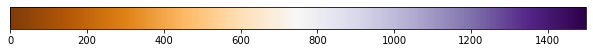

In [10]:
temp = np.array([[-1,1500]])
plt.figure(figsize=(10, 0.5))
img = plt.imshow(temp, cmap='PuOr')
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
plt.colorbar(orientation="horizontal", cax=cax)
plt.savefig("report/colorbar_Vsmeft_2020-053.pdf",bbox_inches='tight')

In [4]:
df = N/ N.abs().sum(axis=0)
temp = [((df - df.loc[:,[i]].to_numpy())).abs().sum() for i in df.columns]
temp2 = [((df + df.loc[:,[i]].to_numpy())).abs().sum() for i in df.columns]
df = np.minimum(pd.concat(temp,axis=1).T,pd.concat(temp2,axis=1).T)
df = (2-df)/2
df = df.set_axis(df.columns,axis=0)

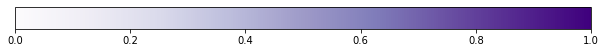

In [47]:
style = df.style.background_gradient( vmin=-1, vmax=1,cmap='PuOr')\
.format('{:.2f}',na_rep='', precision = 2).highlight_null(color="white")
text = style.to_latex(hrules= True,convert_css=True).replace('production_','production\_').replace('\\thsolid','').replace('\\begin{table}','').replace('\\end{table}','')
with open('report/c_similarity_2020-053.tex','w') as f: f.write(text)

temp = np.array([[-0,1]])
plt.figure(figsize=(10, 0.5))
img = plt.imshow(temp, cmap='Purples')
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
plt.colorbar(orientation="horizontal", cax=cax)
plt.savefig("report/colorbar_c_similarity_2020-053.pdf",bbox_inches='tight')

In [6]:
style = df.drop(['cHDD','cHWB','cHW','cHB','cuW','cuB','cW'],axis=1)\
.drop(['cHDD','cHWB','cHW','cHB','cuW','cuB','cW'],axis=0)\
.drop(['cHbox','cdH','ceH'],axis=0)\
.drop(['cHbox','cdH','ceH'],axis=1)\
.drop(['cG','cqq','c(1)qq','c(31)qq','cuu','c(1)uu','c(1)ud','c(8)ud','c(1)qu','c(8)qu','c(1)qd','c(8)qd'],axis=1)\
.drop(['cG','cqq','c(1)qq','c(31)qq','cuu','c(1)uu','c(1)ud','c(8)ud','c(1)qu','c(8)qu','c(1)qd','c(8)qd'],axis=0)\
.style.background_gradient( vmin=-1, vmax=1,cmap='PuOr')\
.format('{:.2f}',na_rep='', precision = 2).highlight_null(color="white")
text = style.to_latex(hrules= True,convert_css=True).replace('production_','production\_').replace('\\thsolid','').replace('\\begin{table}','').replace('\\end{table}','')
with open('report/c_similarity2_2020-053.tex','w') as f: f.write(text)
style

,cHG,cuH,cuG,c(3)Hl,c0ll,c(1)Hl,cHe,c(1)Hq,c(3)Hq,cHu,cHd,c(3)qq
cHG,1.00,0.64,0.87,0.34,0.34,0.36,0.36,0.02,0.03,0.02,0.02,0.01
cuH,0.64,1.00,0.63,0.45,0.44,0.40,0.33,0.10,0.16,0.11,0.11,0.14
cuG,0.87,0.63,1.00,0.35,0.34,0.32,0.32,0.01,0.02,0.01,0.01,0.13
c(3)Hl,0.34,0.45,0.35,1.00,0.91,0.22,0.30,0.14,0.29,0.19,0.19,0.13
c0ll,0.34,0.44,0.34,0.91,1.00,0.28,0.37,0.16,0.33,0.22,0.22,0.12
c(1)Hl,0.36,0.40,0.32,0.22,0.28,1.00,0.88,0.15,0.16,0.14,0.15,0.07
cHe,0.36,0.33,0.32,0.30,0.37,0.88,1.00,0.14,0.19,0.17,0.18,0.07
c(1)Hq,0.02,0.10,0.01,0.14,0.16,0.15,0.14,1.00,0.46,0.88,0.88,0.00
c(3)Hq,0.03,0.16,0.02,0.29,0.33,0.16,0.19,0.46,1.00,0.51,0.53,0.01
cHu,0.02,0.11,0.01,0.19,0.22,0.14,0.17,0.88,0.51,1.00,0.98,0.00


In [112]:
def subvec(names):
  val, vec= (np.linalg.eig(N.reset_index(drop=True)[names].T.dot(V).dot(N.reset_index(drop=True)[names])))
  df = pd.DataFrame(np.real(vec).T,columns=names).set_axis(np.real(val))
  df.index.name= 'eigen value'
  df.index += df.index+np.vectorize(lambda x:0.00000001 if x else 0.)(df.index.duplicated())
  style = df\
  .round(2).style.background_gradient( vmin=-1, vmax=1,cmap='PuOr').\
  format(lambda x: '' if x==0 else x)\
  .set_table_styles([{'selector': 'table', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})\
  .set_table_styles([{'selector': 'th', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})\
  .format_index(precision=2)
  return style,df

In [114]:
df2 = pd.concat([subvec(['cHDD','cHWB','cHW','cHB','cuW','cuB','cW'])[1],
          subvec(['cG','cqq','c(1)qq','c(31)qq','cuu','c(1)uu','c(1)ud','c(8)ud','c(1)qu','c(8)qu','c(1)qd','c(8)qd'])[1],
          subvec(['c(3)Hl','c0ll'])[1],
          subvec(['c(1)Hl','cHe'])[1],
          subvec(['c(1)Hq','cHu','cHd'])[1],
          subvec(['c(3)Hq'])[1],
          subvec(['cHG','cuH','cuG'])[1],
          subvec(['cHbox','cdH','ceH'])[1],
          subvec(['c(3)qq'])[1]
          ], axis=1
    )
# df2 = df2.loc[(df2.index > 0.4)]
# df2 = df2.set_axis(['cHWB-cHW-cHB[1]',
# 'cHWB-cHW-cHB[2]',
# 'cHWB-cHW-cHB[3]',
# 'cG-cqq',
# 'c(3)Hl-c0ll',
# 'c(1)Hl-cHe',
# 'c(1)Hq-cHu-cHd',
# 'c(3)Hq',
# 'cHG-cuH-cuG[1]',
# 'cHG-cuH-cuG[2]',
# 'cHbox-cdH-ceH'], axis=0)
style = df2.style.background_gradient( vmin=-1, vmax=1,cmap='PuOr')\
    .format('{:.2f}',na_rep='', precision = 2).highlight_null(color="white")\
.set_table_styles([{'selector': 'table', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})\
.set_table_styles([{'selector': 'th', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})
text = style.to_latex(hrules= True,convert_css=True).replace('production_','production\_').replace('\\thsolid\n','').replace('\\begin{table}\n','').replace('\n\\end{table}\n','')
with open('report/subvecs_2020-053.tex','w') as f: f.write(text)
style

,cHDD,cHWB,cHW,cHB,cuW,cuB,cW,cG,cqq,c(1)qq,c(31)qq,cuu,c(1)uu,c(1)ud,c(8)ud,c(1)qu,c(8)qu,c(1)qd,c(8)qd,c(3)Hl,c0ll,c(1)Hl,cHe,c(1)Hq,cHu,cHd,c(3)Hq,cHG,cuH,cuG,cHbox,cdH,ceH,c(3)qq
eigen value,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
128677.078634,0.00,-0.47,0.27,0.84,0.02,0.04,0.02,,,,,,,,,,,,,,,,,,,,,,,,,,,
13.003360,-0.00,-0.25,-0.95,0.17,0.01,0.01,0.01,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.981195,-0.11,-0.84,0.13,-0.51,-0.02,-0.05,-0.02,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.054650,-0.02,-0.00,0.00,-0.03,1.00,-0.01,0.00,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.010700,0.98,-0.09,0.01,-0.05,0.02,-0.14,-0.05,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.001546,-0.14,0.03,-0.01,0.08,-0.01,-0.91,-0.37,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.000008,-0.00,0.00,0.00,-0.00,-0.00,-0.38,0.93,,,,,,,,,,,,,,,,,,,,,,,,,,,
6.762219,,,,,,,,-0.25,-0.05,-0.34,-0.80,-0.03,-0.35,0.00,-0.05,-0.02,-0.23,0.00,-0.05,,,,,,,,,,,,,,,
0.017777,,,,,,,,0.96,0.04,-0.02,-0.26,0.01,-0.04,0.00,-0.04,-0.00,-0.04,0.00,-0.05,,,,,,,,,,,,,,,


In [116]:
df2 = pd.concat([subvec(['cHDD','cHWB','cHW','cHB','cuW','cuB','cW'])[1],
          subvec(['cG','cqq','c(1)qq','c(31)qq','cuu','c(1)uu','c(1)ud','c(8)ud','c(1)qu','c(8)qu','c(1)qd','c(8)qd','c(3)qq'])[1],
          subvec(['c(3)Hl','c0ll'])[1],
          subvec(['c(1)Hl','cHe'])[1],
          subvec(['c(1)Hq','cHu','cHd'])[1],
          subvec(['c(3)Hq'])[1],
          subvec(['cHG','cuH','cuG'])[1],
          subvec(['cHbox','cdH','ceH'])[1]], axis=1
    )
df2 = df2.loc[(df2.index > 0.4)]
df2 = df2.set_axis(['cHWB-cHW-cHB[1]',
'cHWB-cHW-cHB[2]',
'cHWB-cHW-cHB[3]',
'cG-cqq',
'c(3)Hl-c0ll',
'c(1)Hl-cHe',
'c(1)Hq-cHu-cHd',
'c(3)Hq',
'cHG-cuH-cuG[1]',
'cHG-cuH-cuG[2]',
'cHbox-cdH-ceH'], axis=0)
style = df2.style.background_gradient( vmin=-1, vmax=1,cmap='PuOr')\
    .format('{:.2f}',na_rep='', precision = 2).highlight_null(color="white")\
.set_table_styles([{'selector': 'table', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})\
.set_table_styles([{'selector': 'th', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})
text = style.to_latex(hrules= True,convert_css=True).replace('production_','production\_').replace('\\thsolid\n','').replace('\\begin{table}\n','').replace('\n\\end{table}\n','')
with open('report/subvecs_cut_2020-053.tex','w') as f: f.write(text)
style

,cHDD,cHWB,cHW,cHB,cuW,cuB,cW,cG,cqq,c(1)qq,c(31)qq,cuu,c(1)uu,c(1)ud,c(8)ud,c(1)qu,c(8)qu,c(1)qd,c(8)qd,c(3)qq,c(3)Hl,c0ll,c(1)Hl,cHe,c(1)Hq,cHu,cHd,c(3)Hq,cHG,cuH,cuG,cHbox,cdH,ceH
cHWB-cHW-cHB[1],0.00,-0.47,0.27,0.84,0.02,0.04,0.02,,,,,,,,,,,,,,,,,,,,,,,,,,,
cHWB-cHW-cHB[2],-0.00,-0.25,-0.95,0.17,0.01,0.01,0.01,,,,,,,,,,,,,,,,,,,,,,,,,,,
cHWB-cHW-cHB[3],-0.11,-0.84,0.13,-0.51,-0.02,-0.05,-0.02,,,,,,,,,,,,,,,,,,,,,,,,,,,
cG-cqq,,,,,,,,0.25,0.05,0.33,0.80,0.03,0.35,-0.00,0.05,0.02,0.23,-0.00,0.05,-0.04,,,,,,,,,,,,,,
c(3)Hl-c0ll,,,,,,,,,,,,,,,,,,,,,0.87,-0.49,,,,,,,,,,,,
c(1)Hl-cHe,,,,,,,,,,,,,,,,,,,,,,,0.78,-0.62,,,,,,,,,,
c(1)Hq-cHu-cHd,,,,,,,,,,,,,,,,,,,,,,,,,0.39,-0.88,0.27,,,,,,,
c(3)Hq,,,,,,,,,,,,,,,,,,,,,,,,,,,,1.00,,,,,,
cHG-cuH-cuG[1],,,,,,,,,,,,,,,,,,,,,,,,,,,,,1.00,-0.00,0.04,,,
cHG-cuH-cuG[2],,,,,,,,,,,,,,,,,,,,,,,,,,,,,-0.04,0.08,1.00,,,


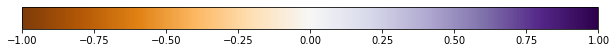

In [12]:
temp = np.array([[-1,1]])
plt.figure(figsize=(10, 0.5))
img = plt.imshow(temp, cmap='PuOr')
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
plt.colorbar(orientation="horizontal", cax=cax)
plt.savefig("report/rotation-matrix_2020-053.pdf",bbox_inches='tight')

In [97]:
temp = pd.DataFrame([],columns =df2.columns)
style = pd.concat([temp,a.rot.set_index(a.rot.index.to_series().str[:12] + '\dots').iloc[[1,2,3,8,9,6,5,4,0,7]]],axis=0).replace(0,np.nan).style.background_gradient( vmin=-1, vmax=1,cmap='PuOr')\
    .format('{:.2f}',na_rep='', precision = 2).highlight_null(color="white")\
.set_table_styles([{'selector': 'table', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})\
.set_table_styles([{'selector': 'th', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})
text = style.to_latex(hrules= True,convert_css=True).replace('production_','production\_').replace('\\thsolid\n','').replace('\\begin{table}\n','').replace('\n\\end{table}\n','')
with open('report/rotation-matrix_reference_2020-053.tex','w') as f: f.write(text)
style

/tmp/ipykernel_10656/2128113782.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  style = pd.concat([temp,a.rot.set_index(a.rot.index.to_series().str[:12] + '\dots').iloc[[1,2,3,8,9,6,5,4,0,7]]],axis=0).replace(0,np.nan).style.background_gradient( vmin=-1, vmax=1,cmap='PuOr')\


,cHDD,cHWB,cHW,cHB,cuW,cuB,cW,cG,cqq,c(1)qq,c(31)qq,cuu,c(1)uu,c(1)ud,c(8)ud,c(1)qu,c(8)qu,c(1)qd,c(8)qd,c(3)qq,c(3)Hl,c0ll,c(1)Hl,cHe,c(1)Hq,cHu,cHd,c(3)Hq,cHG,cuH,cuG,cHbox,cdH,ceH
c[1]HW-HB-HW\dots,,0.47,-0.27,-0.84,-0.02,-0.05,,,,,,,,,,,,,,,,,,,,,,,,,,,,
c[2]HW-HB-HW\dots,,-0.20,-0.96,0.19,,0.02,,,,,,,,,,,,,,,,,,,,,,,,,,,,
c[3]HW-HB-HW\dots,0.07,0.86,-0.08,0.50,0.03,0.06,,,,,,,,,,,,,,,,,,,,,,,,,,,,
c[2]HG-uG-uH\dots,,,,,,,,-0.18,-0.23,-0.03,-0.54,-0.02,-0.24,,-0.04,-0.01,-0.15,,-0.04,-0.05,,,,,,,,,-0.03,0.06,0.73,,,
c[3]HG-uG-uH\dots,,,,,,,,0.29,0.25,0.04,0.55,0.02,0.26,,0.03,0.01,0.16,,0.03,0.05,,,,,,,,,-0.03,0.10,0.67,,,
c[1]Hl(3)-ll\dots,,,,,,,,,,,,,,,,,,,,,0.87,-0.50,,,,,,,,,,,,
c[1]Hl(1)-He\dots,,,,,,,,,,,,,,,,,,,,,,,0.78,-0.62,,,,,,,,,,
c[1]Hu-Hd-Hq\dots,,,,,,,,,,,,,,,,,,,,,,,,,0.42,-0.87,0.26,,,,,,,
c(3)Hq\dots,,,,,,,,,,,,,,,,,,,,,,,,,,,,1.00,,,,,,
c[1]HG-uG-uH\dots,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0.99,,0.03,,,


## 2021-053

In [3]:
import Fiteft
a = Fiteft.fiteft(experiment='ATLAS-CONF-2021-053')

Your input to the likelihood function is a DataFrame with one of these colums:
['c(3)Hq', 'c[1]HW-HB-HWB-HDD-uW-uB', 'c[2]HW-HB-HWB-HDD-uW-uB', 'c[3]HW-HB-HWB-HDD-uW-uB', 'c[1]Hu-Hd-Hq(1)', 'c[1]Hl(1)-He', 'c[1]Hl(3)-ll0', 'c[1]HG-uG-uH-top', 'c[2]HG-uG-uH-top', 'c[3]HG-uG-uH-top']


In [93]:
Delta = (a.obs[['+total']]+a.obs[['-total']].abs().to_numpy()).to_numpy()/2
V = (a.cor_exp*Delta.dot(Delta.T)).to_numpy()
# V = pd.read_csv('data/ATLAS-CONF-2020-053/correlation_expected.csv', sep='\s+',index_col=None,header=None)
N = (a.Ndf - a.Ddf.to_numpy())
V_eft_inv = N.T.dot(np.linalg.inv(V)).dot(N.reset_index(drop=True))
V_eft = pd.DataFrame(np.linalg.inv(V_eft_inv), columns = V_eft_inv.columns,index = V_eft_inv.index)

In [83]:
df = N/ N.abs().sum(axis=0)
temp = [((df - df.loc[:,[i]].to_numpy())).abs().sum() for i in df.columns]
temp2 = [((df + df.loc[:,[i]].to_numpy())).abs().sum() for i in df.columns]
df = np.minimum(pd.concat(temp,axis=1).T,pd.concat(temp2,axis=1).T)
df = (2-df)/2
df = df.set_axis(df.columns,axis=0)

In [77]:
style = df.style.background_gradient( vmin=-1, vmax=1,cmap='PuOr')\
.format('{:.2f}',na_rep='', precision = 2).highlight_null(color="white")
# text = style.to_latex(hrules= True,convert_css=True).replace('production_','production\_').replace('\\thsolid','').replace('\\begin{table}','').replace('\\end{table}','')
# with open('report/c_similarity_2020-053.tex','w') as f: f.write(text)
style

,cHbox,cHDD,cHG,cuH,cuG,c(3)Hl,c0ll,cHW,cHB,cHWB,c(3)Hq,cHu,cHd,c(1)Hq,c(1)Hl,cHe,cG,cuW,cuB,c(1)qq,cqq,c(3)qq,c(31)qq,cuu,c(1)uu,c(1)ud,c(8)ud,c(1)qu,c(8)qu,c(1)qd,c(8)qd,cW,cdH,ceH
cHbox,1.00,0.71,0.72,0.75,0.73,0.91,0.90,0.75,0.90,0.84,0.11,0.10,0.07,0.05,0.82,0.82,0.04,0.17,0.19,0.05,0.05,0.04,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.19,0.19,0.19
cHDD,0.71,1.00,0.55,0.58,0.56,0.65,0.61,0.68,0.61,0.61,0.16,0.09,0.08,0.11,0.53,0.53,0.08,0.43,0.46,0.10,0.10,0.08,0.10,0.09,0.10,0.09,0.09,0.09,0.10,0.09,0.09,0.46,0.46,0.46
cHG,0.72,0.55,1.00,0.96,0.98,0.70,0.72,0.62,0.76,0.67,0.04,0.01,0.00,0.01,0.78,0.77,0.00,0.15,0.20,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.20,0.20,0.20
cuH,0.75,0.58,0.96,1.00,0.95,0.71,0.74,0.64,0.78,0.68,0.05,0.02,0.01,0.02,0.77,0.77,0.01,0.14,0.19,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.19,0.19,0.19
cuG,0.73,0.56,0.98,0.95,1.00,0.70,0.73,0.62,0.77,0.67,0.04,0.01,0.00,0.01,0.78,0.77,0.01,0.15,0.20,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.19,0.19,0.19
c(3)Hl,0.91,0.65,0.70,0.71,0.70,1.00,0.96,0.76,0.90,0.89,0.12,0.12,0.09,0.07,0.84,0.84,0.03,0.15,0.21,0.04,0.04,0.03,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.21,0.21,0.21
c0ll,0.90,0.61,0.72,0.74,0.73,0.96,1.00,0.76,0.93,0.90,0.12,0.11,0.08,0.06,0.88,0.88,0.02,0.16,0.23,0.03,0.03,0.02,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.23,0.23,0.23
cHW,0.75,0.68,0.62,0.64,0.62,0.76,0.76,1.00,0.78,0.83,0.24,0.10,0.10,0.07,0.71,0.71,0.02,0.17,0.21,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.21,0.21,0.21
cHB,0.90,0.61,0.76,0.78,0.77,0.90,0.93,0.78,1.00,0.90,0.09,0.08,0.06,0.04,0.90,0.90,0.02,0.16,0.22,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.22,0.22,0.22
cHWB,0.84,0.61,0.67,0.68,0.67,0.89,0.90,0.83,0.90,1.00,0.11,0.11,0.08,0.05,0.83,0.83,0.02,0.15,0.21,0.03,0.03,0.02,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.21,0.21,0.21


In [95]:
def subvec(names):
  val, vec= (np.linalg.eig(N.reset_index(drop=True)[names].T.dot(V).dot(N.reset_index(drop=True)[names])))
  df = pd.DataFrame(np.real(vec).T,columns=names).set_axis(np.real(val))
  df.index.name= 'eigen value'
  df.index += df.index+np.vectorize(lambda x:0.00000001 if x else 0.)(df.index.duplicated())
  style = df\
  .round(2).style.background_gradient( vmin=-1, vmax=1,cmap='PuOr').\
  format(lambda x: '' if x==0 else x)\
  .set_table_styles([{'selector': 'table', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})\
  .set_table_styles([{'selector': 'th', 'props': [('border-style', 'solid'), ('border-width', '1px'), ('border-color', 'black')]}]).set_properties(**{'border': '1px solid black !important'})\
  .format_index(precision=2)
  return style,df

In [106]:
Coeffs = ['cHG','cuH','cuG']
style = subvec(Coeffs)[0]
# text = style.to_latex(hrules= True,convert_css=True).replace('production_','production\_').replace('\\thsolid\n','').replace('\\begin{table}\n','').replace('\n\\end{table}\n','')
# with open('report/subvec1-053.tex','w') as f: f.write(text)
style

,cG
eigen value,
0.00,1.0


In [108]:
Coeffs = ['c(3)Hl','c0ll']
style = subvec(Coeffs)[0]
# text = style.to_latex(hrules= True,convert_css=True).replace('production_','production\_').replace('\\thsolid\n','').replace('\\begin{table}\n','').replace('\n\\end{table}\n','')
# with open('report/subvec1-053.tex','w') as f: f.write(text)
style

,cuW
eigen value,
0.00,1.0


In [ ]:
['cHu','cHd']\
+['cuB','cW','cdH','ceH']\
+['c(1)qq','cqq','c(3)qq','c(31)qq','cuu','c(1)uu','c(1)ud','c(8)ud','c(1)qu','c(8)qu','c(1)qd','c(8)qd']

In [107]:
style = df.drop(
 ['c(3)Hl','c0ll']\
+ ['cHG','cuH','cuG']\
+['cHu','cHd']\
+['c(1)Hl','cHe']
+['cuB','cW','cdH','ceH','cuW']\
+['c(1)qq','cqq','c(3)qq','c(31)qq','cuu','c(1)uu','c(1)ud','c(8)ud','c(1)qu','c(8)qu','c(1)qd','c(8)qd','cG'],axis=1)\
.drop( ['c(3)Hl','c0ll']\
+ ['cHG','cuH','cuG']\
+['cHu','cHd']\
+['c(1)Hl','cHe']
+['cuB','cW','cdH','ceH','cuW']\
+['c(1)qq','cqq','c(3)qq','c(31)qq','cuu','c(1)uu','c(1)ud','c(8)ud','c(1)qu','c(8)qu','c(1)qd','c(8)qd','cG'],axis=0)\
.style.background_gradient( vmin=-1, vmax=1,cmap='PuOr')\
.format('{:.2f}',na_rep='', precision = 2).highlight_null(color="white")
# text = style.to_latex(hrules= True,convert_css=True).replace('production_','production\_').replace('\\thsolid','').replace('\\begin{table}','').replace('\\end{table}','')
# with open('report/c_similarity2_2020-053.tex','w') as f: f.write(text)
style

,cHbox,cHDD,cHW,cHB,cHWB,c(3)Hq,c(1)Hq,cuW
cHbox,1.00,0.71,0.75,0.90,0.84,0.11,0.05,0.17
cHDD,0.71,1.00,0.68,0.61,0.61,0.16,0.11,0.43
cHW,0.75,0.68,1.00,0.78,0.83,0.24,0.07,0.17
cHB,0.90,0.61,0.78,1.00,0.90,0.09,0.04,0.16
cHWB,0.84,0.61,0.83,0.90,1.00,0.11,0.05,0.15
c(3)Hq,0.11,0.16,0.24,0.09,0.11,1.00,0.22,0.17
c(1)Hq,0.05,0.11,0.07,0.04,0.05,0.22,1.00,0.12
cuW,0.17,0.43,0.17,0.16,0.15,0.17,0.12,1.00


# appendix

In [29]:
with open('/home/dung/project/Fiteft/report/tempdef','r') as f: text = f.read()
with open('/home/dung/project/Fiteft/report/temptable','r') as f: text2 = f.read()

In [ ]:
pd.read_csv('/home/dung/project/Fiteft/report/temptable', )

In [28]:
df = pd.DataFrame(re.findall(r'\\newcommand\\(\w+)\s+.(.+).', text))
df2 = pd.DataFrame(re.findall(r'\\newcommand{\\(\w+)}{(.+)}', text))

In [33]:
for i in df.iterrows():
 text2 = text2.replace((i[1][0]),i[1][1]) 
for i in df2.iterrows():
 text2 = text2.replace((i[1][0]),i[1][1]) 

In [37]:
print(text2)

\cH        &  \scalebox{0.8}{\\ensuremath{(H^\dag H)^{3}}} \\ \interrowfill
\\protect\ensuremath{c_{Hb}}\xspaceox &  \scalebox{0.8}{\\ensuremath{(H^\dag H)^{3}}box} \\ \interrowfill
\cG &  \scalebox{0.8}{\\protect\ensuremath{f^{abc} G_\mu^{a\nu} G_\nu^{b\rho} G_\rho^{c\mu}}\xspace} \\ \interrowfill
\cW &  \scalebox{0.8}{\\ensuremath{\epsilon^{IJK} W^{I\nu}_\mu W^{J\rho}_\nu W^{K\mu}_\rho}} \\ \interrowfill
\\protect\ensuremath{c_{HD}}\xspaceD &  \scalebox{0.8}{\\ensuremath{(H^\dag H)^{3}}DD} \\ \interrowfill
\cHG &  \scalebox{0.8}{\\ensuremath{(H^\dag H)^{3}}G} \\ \interrowfill
\cHB &  \scalebox{0.8}{\\ensuremath{(H^\dag H)^{3}}B} \\ \interrowfill
\cHW &  \scalebox{0.8}{\\ensuremath{(H^\dag H)^{3}}W} \\ \interrowfill
\cHWB &  \scalebox{0.8}{\\ensuremath{(H^\dag H)^{3}}WB} \\ \interrowfill
\hline \interrowfill
\\cHlone[1] &  \scalebox{0.8}{\\ensuremath{(H^\dag H)^{3}}lOneOne} \\ \interrowfill
\\cHltwo[1] &  \scalebox{0.8}{\\ensuremath{(H^\dag H)^{3}}lOneTwo} \\ \interrowfill
\\cHlthree[